# What are the outliers (60 days)

Do we get the same relationships when we change the model so that the crop grows 60 days after the model starts, not 21 days after.

Notebook dedicated to running tests and figure out what causes those outliers on the second trajectory.

Questions addressed in this notebook:
- Q1. [Is it related to s_star crossings?](#sstar)
- Q2. [Initial values of s and stress?](#s0)
- Q3. [Is it related to residuals?](#residuals)
- Q4. [Initial values of s and stress?](#s02)
- Q5. [Summary stats blue vs. orange](stats)
- Q6. [Low rainfall](#rf)
- Q7. [Explore n, k & r of dynamic stress](#nr)

Last updated: 2 July 2020

## Imports

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import seaborn as sns
import proplot as plot
import sys
from scipy.stats import t
from scipy.optimize import curve_fit
import time
import progressbar

# We need to add the module path to our system path so 
# that our notebook can find our local objects and code:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'
plot.rc['savefig.transparent'] = 'False'

## Functions

In [2]:
def dyn_stress(n_sim = 1000, station = 'OL JOGI FARM', texture = 'clay loam', lgp=180, pd_sim=60): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 1000 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg stress, total rf
    start = 60 
    end = start + lgp
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]

    # dont need this but helpful for debugging
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]
    sat = [df[start:end]['s'] for df in output]
    stress = [df[start:end]['stress'] for df in output]
    
    o = output
    
    # Part 6. Output the dynamic stress and yield values
    # prev crop.calc_dstress
    x = [crop.calc_dstress(s=df.s, stress=df.stress) for df in o] #for i in np.arange(n_sim)
    #print(x)
    
    # Part 7. TODO: Define kc, a little janky and needs to be automated
    start = 60
    end = 60 + 180
    kc = o[1][start:end]['kc'].tolist()
    
    return  x, total_rf, sat, stress, o, crop, output, kc, start, end, #output, avg_stress, total_stress, total_rf, mstr_memb, dstr_memb, yield_kg_ha

# Note: Not great practice to return all of these variables, but for testing it's useful
data, rf, sat, stress, o, crop, output, kc, start, end = dyn_stress()

# check that time series starts on day 60
sat

# Turn dynamic water stress data into a tuple
df = pd.DataFrame.from_records(data, columns =['AvgStress2','DynamicStress','Yield'])
df['RF'] = rf

# We'll be using these variables a lot
x = df.RF
y = df.Yield

max(df.RF)

811.9969439212896

### Scatter plot of raw data
We want to figure out what's driving that second group 

Text(0.5, 0, 'Rainfall (mm)')

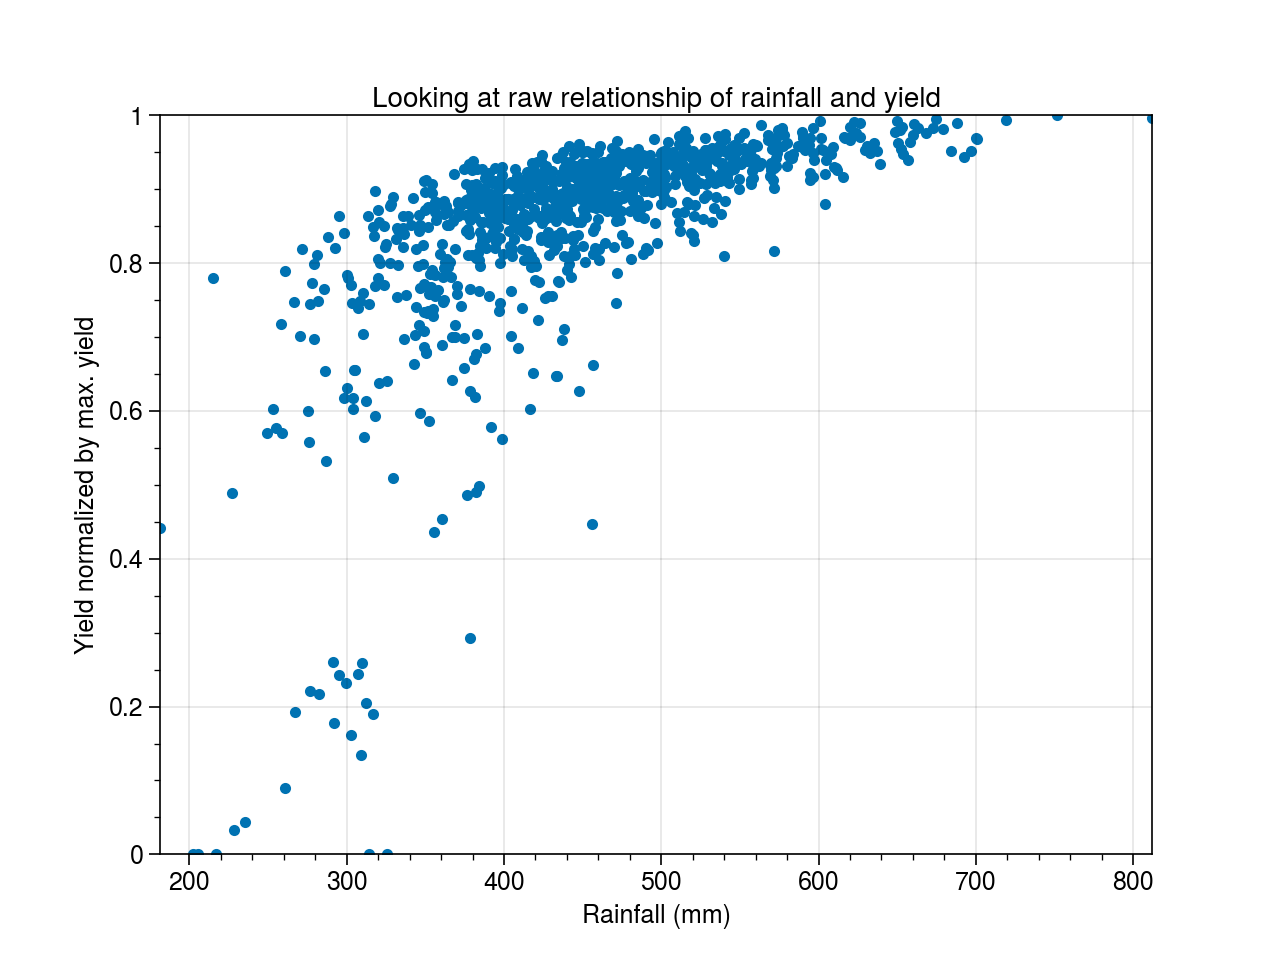

In [3]:
# Scatter plot of raw data
max(df.Yield)

df['Yield_norm'] = df.Yield/max(df.Yield)

plt.scatter(df.RF, df.Yield_norm)
#plt.ylim(-.10,1.10)
#plt.xlim(100,900)
plt.title('Looking at raw relationship of rainfall and yield')
plt.ylabel('Yield normalized by max. yield')
plt.xlabel('Rainfall (mm)')

## Q1. Are the second group of simulations related to time series that have values above s star?
### Subset simulations that experienced s_star crossing <a id='sstar'></a>

Color points on whether or not they have a value in the time series that crosses s_star...

We want to select the simulation numbers based on index that experienced s_star crossing

In [4]:
# For any simulation, we can see whether there is a value of s greater than or equal to s_star
i = 4
if len(output[i][output[i].s >= crop.s_star]) > 0:
    print('True')

output[i].s

True


0      0.668639
1      0.675607
2      0.667179
3      0.659190
4      0.651614
         ...   
242    0.594566
243    0.609938
244    0.602347
245    0.595436
246    0.603062
Name: s, Length: 247, dtype: float64

In [5]:
# This tells us where in the time series s crosses s star
indx_memb = np.where(output[i].s >= crop.s_star)
indx_memb

# This is a dataframe of those occurrences
output[i][output[i].s >= crop.s_star]

# versus the whole time series
output[i][start:end]

kc   LAI    stress          R         s         E        ET  \
60   0.300000  0.75  0.219988   0.000000  0.662743  1.209569  1.846734   
61   0.300000  0.75  0.250066   0.000000  0.654983  1.152038  1.751958   
62   0.300000  0.75  0.280382   0.000000  0.647622  1.098330  1.662917   
63   0.300000  0.75  0.310761   0.000000  0.640635  1.048149  1.579198   
64   0.300000  0.75  0.341056  20.136795  0.634000  1.001224  1.500424   
..        ...   ...       ...        ...       ...       ...       ...   
235  0.653333  3.00  0.243445   0.000000  0.656650  0.377997  2.809672   
236  0.640000  3.00  0.292273   0.000000  0.644844  0.350068  2.555081   
237  0.626667  3.00  0.340548   0.000000  0.634109  0.325298  2.324186   
238  0.613333  3.00  0.387664   0.000000  0.624343  0.303298  2.114689   
239  0.600000  3.00  0.433185   0.000000  0.615458  0.283733  1.924527   

            T    L       dsdt    dos  doy  
60   0.637165  0.0  -1.846734    1.0   60  
61   0.599920  0.0  -1.751958    2.0   61  
62   0.564587  0.0  -1.662917    3.0   62  
63   0.531049  0.0  -1.579198    4.0   63  
64   0.499200  0.0  18.636371    5.0   64  
..        ...  ...        ...    ...  ...  
235  2.431675  0.0  -2.809672  176.0  235  
236  2.205012  0.0  -2.555081  177.0  236  
237  1.998888  0.0  -2.324186  178.0  237  
238  1.811391  0.0  -2.114689  179.0  238  
239  1.640794  0.0  -1.924527  180.0  239  

[180 rows x 12 columns]

In [6]:
s_min = []
n_sim = 1000
no_sims = np.arange(0,n_sim)

# figure out index number for simulation
for i in no_sims:
    # What this does is if the length of the dataframe is greater than 0 then it prints the 
    # simulation number which means that it has a crossing
    if len(output[i][start:end][output[i].s >= crop.s_star]) > 0:
        s_min.append(i)
    #s_min.append(_s_min)
    
result = pd.DataFrame({'sim_no':s_min}).sim_no.tolist()
good = result

# put all those indices together and change the color of the scatterplot

# How many simulations do cross s star?
len(good)

<ipython-input-6-869c6cbff263>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(output[i][start:end][output[i].s >= crop.s_star]) > 0:


964

In [7]:
# this is not the smartest way of doing this, but I need two dataframes one with the sims that cross star and the other one that doesnt
#result['flag'] = result.loc[result.index.isin(good)]
#result
df1 = df[df.index.isin(good)]
df2 = df[~df.index.isin(good)]

print(len(df))
print(len(df1))
print(len(df2))

1000
964
36


Text(0.5, 0, 'Rainfall (mm)')

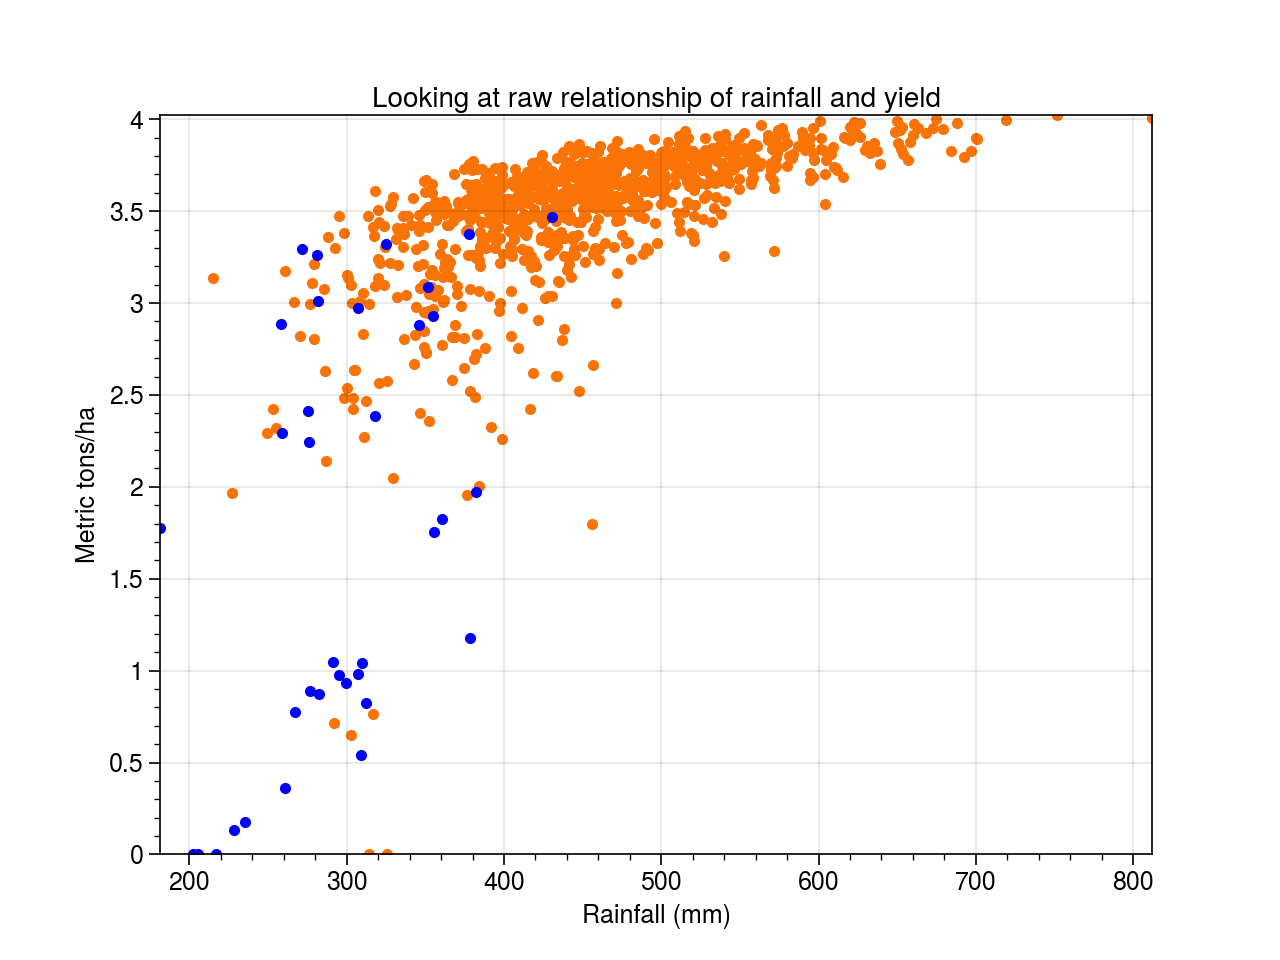

In [8]:
# scatter plot of raw data
max(df.Yield)

#df1['Yield_norm'] = df.Yield/max(df.Yield)
#df1['Yield_norm'] = df1.Yield/max(df1.Yield)

plt.scatter(df1.RF, df1.Yield/1000, color='orange')
plt.scatter(df2.RF, df2.Yield/1000, color='blue')
#plt.ylim(-.10,1.10)
#plt.xlim(100,900)
plt.title('Looking at raw relationship of rainfall and yield')
plt.ylabel('Metric tons/ha')
plt.xlabel('Rainfall (mm)')

- So, conclusion, whether saturation time series goes above s star does not determine whether points into second trajectory.
- However, it could have something to do with whether the crop fails
- Not testing this out yet

## Q2: What are the initial values of s and stress when the model starts? <a id='s0'></a>

Maybe the crop is not consistently stressed for all of the model runs

count    964.000000
mean       0.697370
std        0.067209
min        0.529309
25%        0.648113
50%        0.696510
75%        0.744706
max        0.864435
Name: 0, dtype: float64
count    36.000000
mean      0.645749
std       0.045390
min       0.551405
25%       0.615848
50%       0.645018
75%       0.676919
max       0.764801
Name: 0, dtype: float64


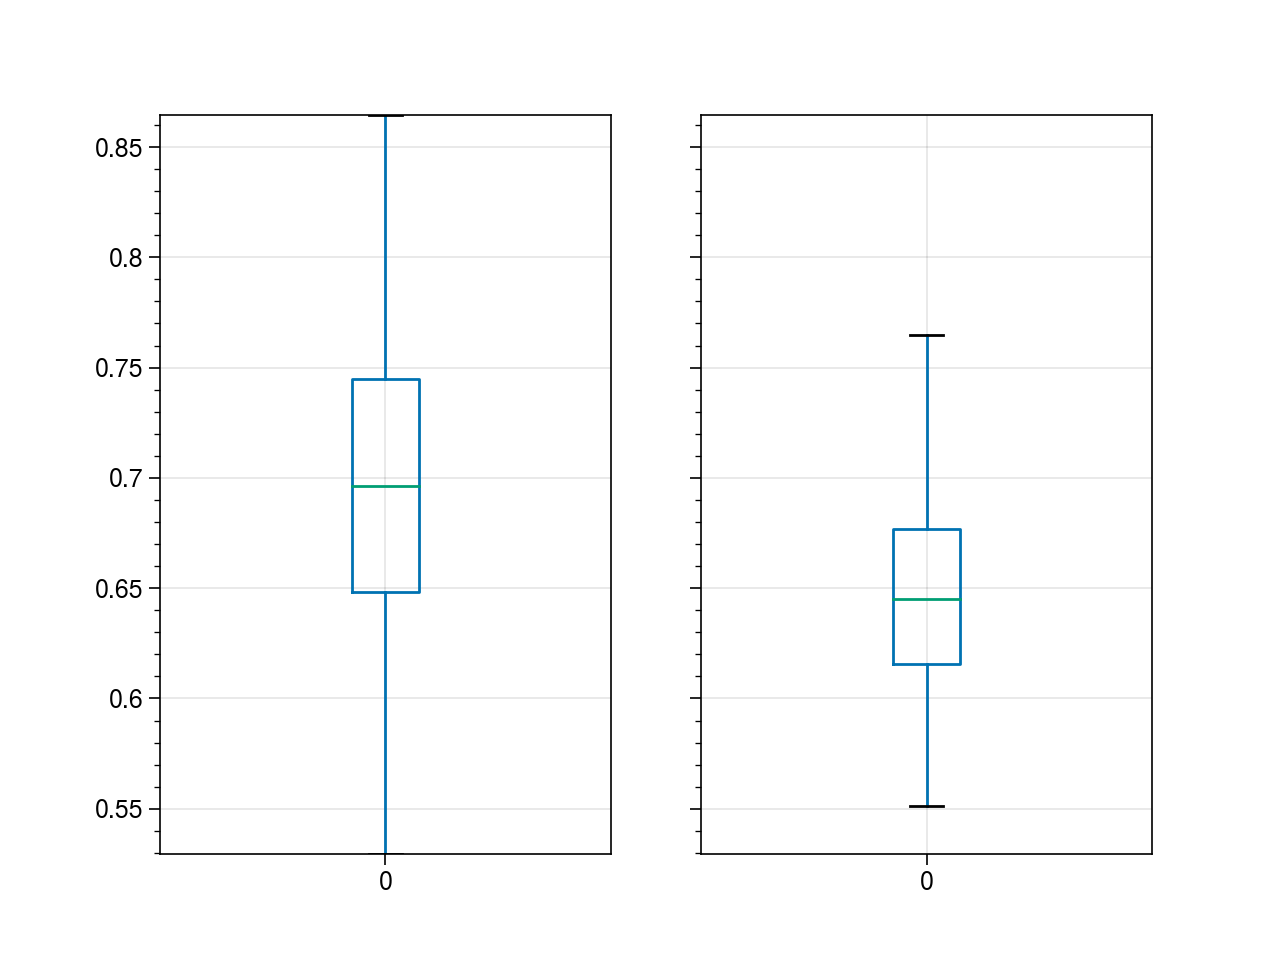

In [9]:
s0 = pd.DataFrame(list(zip(*sat))[0]).reset_index()

# check out some summary statistics
s0[0].describe()

# now subdivide by two categories
d1 = s0[s0.index.isin(good)]
d2 = s0[~s0.index.isin(good)]

# summary stats again
print(d1[0].describe())
print(d2[0].describe())

# not a clear difference here
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
d1[0].plot.box(ax=ax[0]) 
d2[0].plot.box(ax=ax[1]) 

In [10]:
# st0 = pd.DataFrame(list(zip(*stress))[0]).reset_index()

# # check out some summary statistics
# st0[0].describe()

# # now subdivide by two categories
# d1 = st0[st0.index.isin(good)]
# d2 = st0[~st0.index.isin(good)]

# # summary stats again
# print(d1[0].describe())
# print(d2[0].describe())

# # not a clear difference here
# fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
# d1[0].plot.box(ax=ax[0]) 
# d2[0].plot.box(ax=ax[1]) 

## Q3. Define the points on that second trajectory using residuals <a id='residuals'></a>

Defined as errors below `some_num`. For 1000 runs, how many are the outliers?

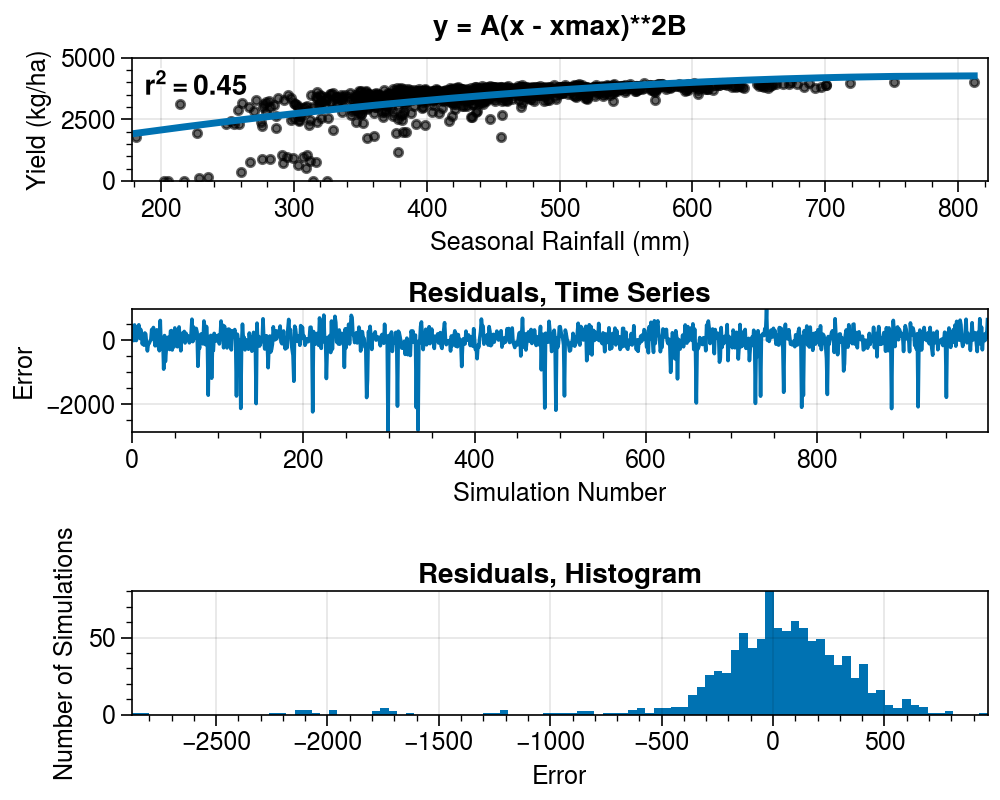

In [11]:
# New fit
residuals = plot_newfit(df.RF, df.Yield, 'Seasonal Rainfall (mm)', 'Yield (kg/ha)')

In [12]:
# Explore errors that are below `some_num` and see if there are commonalities
some_num = -999 #-568

residuals[residuals.le(some_num)]

# return rows in pandas dataframe based on index from other column
print(len(df[df.index.isin(residuals[residuals.le(some_num)].index)]))

residuals[residuals.le(some_num)]

29


89    -1721.617924
93    -1191.452435
122   -1747.084348
127   -2133.758762
145   -1983.437183
189   -1286.372278
211   -2242.212352
227   -1200.428202
274   -1795.368543
275   -1246.489858
299   -2877.582039
310   -2063.331404
332   -2108.759441
334   -2813.033935
482   -2121.509349
495   -2190.977592
505   -1744.323397
629   -1007.237134
637   -1211.974948
659   -1963.764481
728   -1976.700025
734   -1752.412262
761   -1630.726909
782   -2099.111988
784   -1728.694972
812   -1697.354372
887   -2139.861878
918   -2084.711380
951   -1787.535934
dtype: float64

In [13]:
# select these indices
bimod = df[df.index.isin(residuals[residuals.le(some_num)].index)]
bimod.index

Int64Index([ 89,  93, 122, 127, 145, 189, 211, 227, 274, 275, 299, 310, 332,
            334, 482, 495, 505, 629, 637, 659, 728, 734, 761, 782, 784, 812,
            887, 918, 951],
           dtype='int64')

In [14]:
# print a whole bunch of time series with these values.
# TODO. This is not a pretty or efficient way to do this!
# but it works

# convert list of lists into pandas dataframe
df_sat = pd.DataFrame(sat)
df_stress = pd.DataFrame(stress)

df_sat2 = df_sat.reset_index()
df_sat3 = df_sat2.reset_index()

df_sat3['sim_no'] = df_sat3['level_0'] + 1
df_sat4 = df_sat3.drop(['level_0','index'], axis=1)
df_sat4 # there must be  more efficient way to do this
bimod_sat = df_sat4[df_sat4.sim_no.isin(bimod.index)]
df_sat4[df_sat4.sim_no.isin(bimod.index)] # this is true, ignore index

len(bimod_sat) == len(bimod.index) # True! great!

bimod_sat = bimod_sat.reset_index()

colnames = bimod_sat.sim_no.tolist()

#bimod_sat.plot()
bimod_sat = bimod_sat.T.drop(['sim_no', 'index'],axis=0)
bimod_sat.columns = colnames

# currently index goes from 21 to 180, which is day of simulation, but I want day of year
bimod_sat.index = bimod_sat.index - 59
bimod_sat

89        93        122       127       145       189       211  \
1    0.739664  0.679866  0.567895  0.627621  0.684591  0.626160  0.702949   
2    0.727755  0.671214  0.564714  0.621632  0.675689  0.620242  0.823031   
3    0.716511  0.714998  0.561674  0.641219  0.667257  0.614615  0.820000   
4    0.754140  0.776403  0.558769  0.669176  0.659264  0.609260  0.804208   
5    0.741412  0.762392  0.555993  0.661084  0.651684  0.604162  0.795664   
..        ...       ...       ...       ...       ...       ...       ...   
176  0.710323  0.582560  0.633150  0.687406  0.664372  0.841653  0.607949   
177  0.693618  0.577416  0.623471  0.672800  0.673869  0.857993  0.600536   
178  0.801904  0.572729  0.614665  0.659526  0.660640  0.821729  0.706643   
179  0.778480  0.568459  0.607804  0.647460  0.648473  0.825067  0.741781   
180  0.764946  0.564567  0.600404  0.636488  0.637409  0.807370  0.722178   

          227       274       275  ...       659       728       734  \
1    0.820000  0.616389  0.600733  ...  0.688046  0.766855  0.699069   
2    0.804208  0.610948  0.596042  ...  0.678961  0.789256  0.689394   
3    0.789046  0.620432  0.591571  ...  0.670357  0.774679  0.680238   
4    0.774477  0.677592  0.587309  ...  0.662203  0.760768  0.671567   
5    0.760578  0.669059  0.583245  ...  0.654471  0.747661  0.663350   
..        ...       ...       ...  ...       ...       ...       ...   
176  0.717942  0.602561  0.648808  ...  0.659684  0.626887  0.679744   
177  0.709077  0.595631  0.637713  ...  0.647604  0.617773  0.679593   
178  0.692486  0.589321  0.627622  ...  0.709987  0.611725  0.665700   
179  0.677416  0.679782  0.618442  ...  0.693313  0.603973  0.672146   
180  0.663722  0.665872  0.610088  ...  0.678167  0.596917  0.658932   

          761       782       784       812       887       918       951  
1    0.591149  0.731719  0.770109  0.608215  0.694111  0.746932  0.813235  
2    0.586907  0.729770  0.756463  0.603167  0.684703  0.734613  0.797714  
3    0.619905  0.723246  0.756867  0.598360  0.681718  0.722988  0.782808  
4    0.614294  0.712252  0.743983  0.593781  0.684649  0.712008  0.768479  
5    0.667515  0.726758  0.731831  0.589416  0.675744  0.701632  0.754928  
..        ...       ...       ...       ...       ...       ...       ...  
176  0.692564  0.612497  0.686794  0.726321  0.692635  0.635690  0.645068  
177  0.757062  0.604676  0.672244  0.708145  0.677551  0.625782  0.693432  
178  0.736045  0.597557  0.659021  0.804659  0.663845  0.622925  0.678275  
179  0.749368  0.591075  0.647000  0.781199  0.651386  0.614168  0.664503  
180  0.729063  0.585172  0.637210  0.785956  0.640236  0.606197  0.662973  

[180 rows x 29 columns]

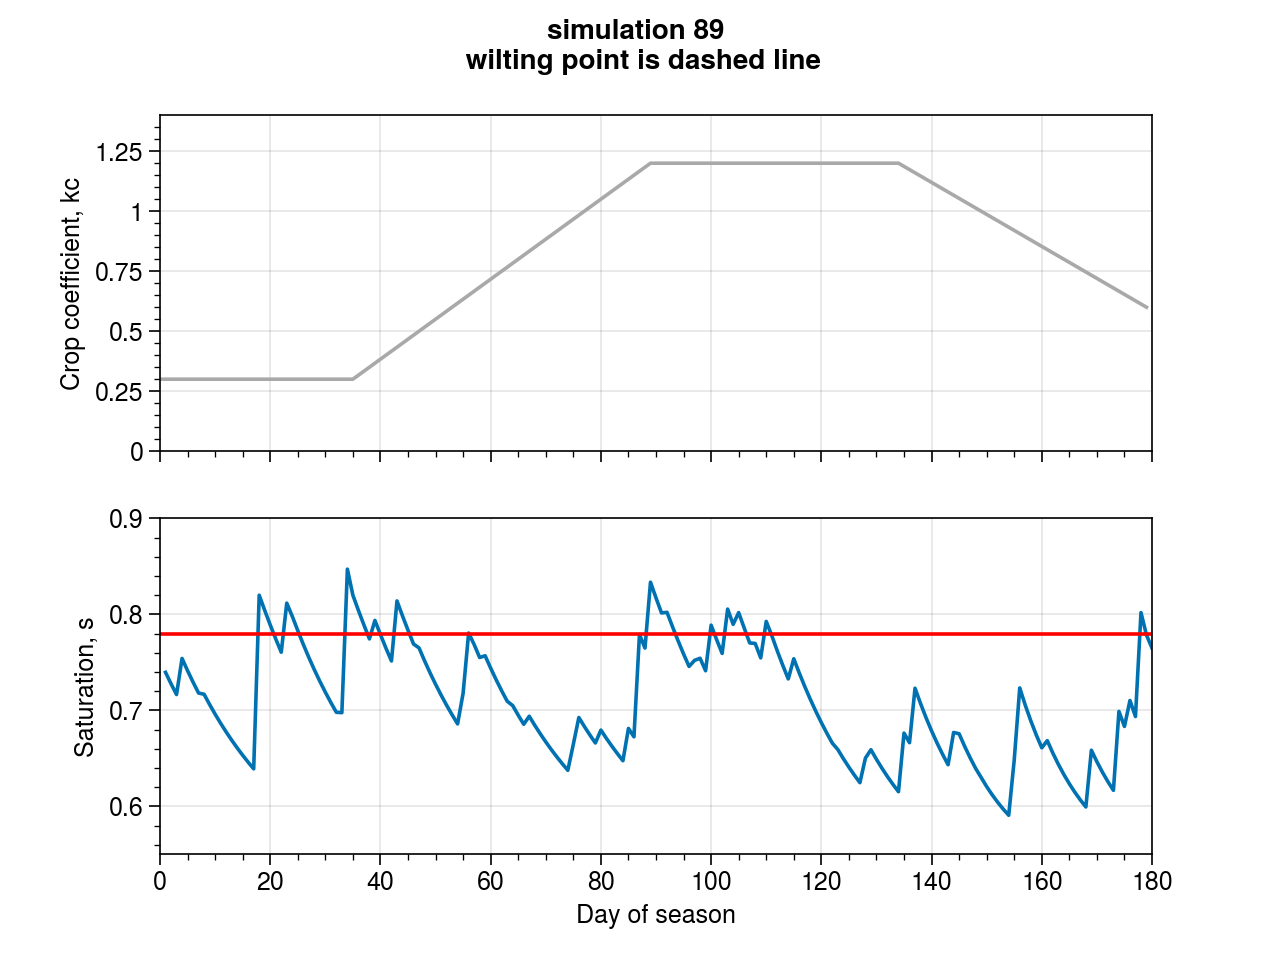

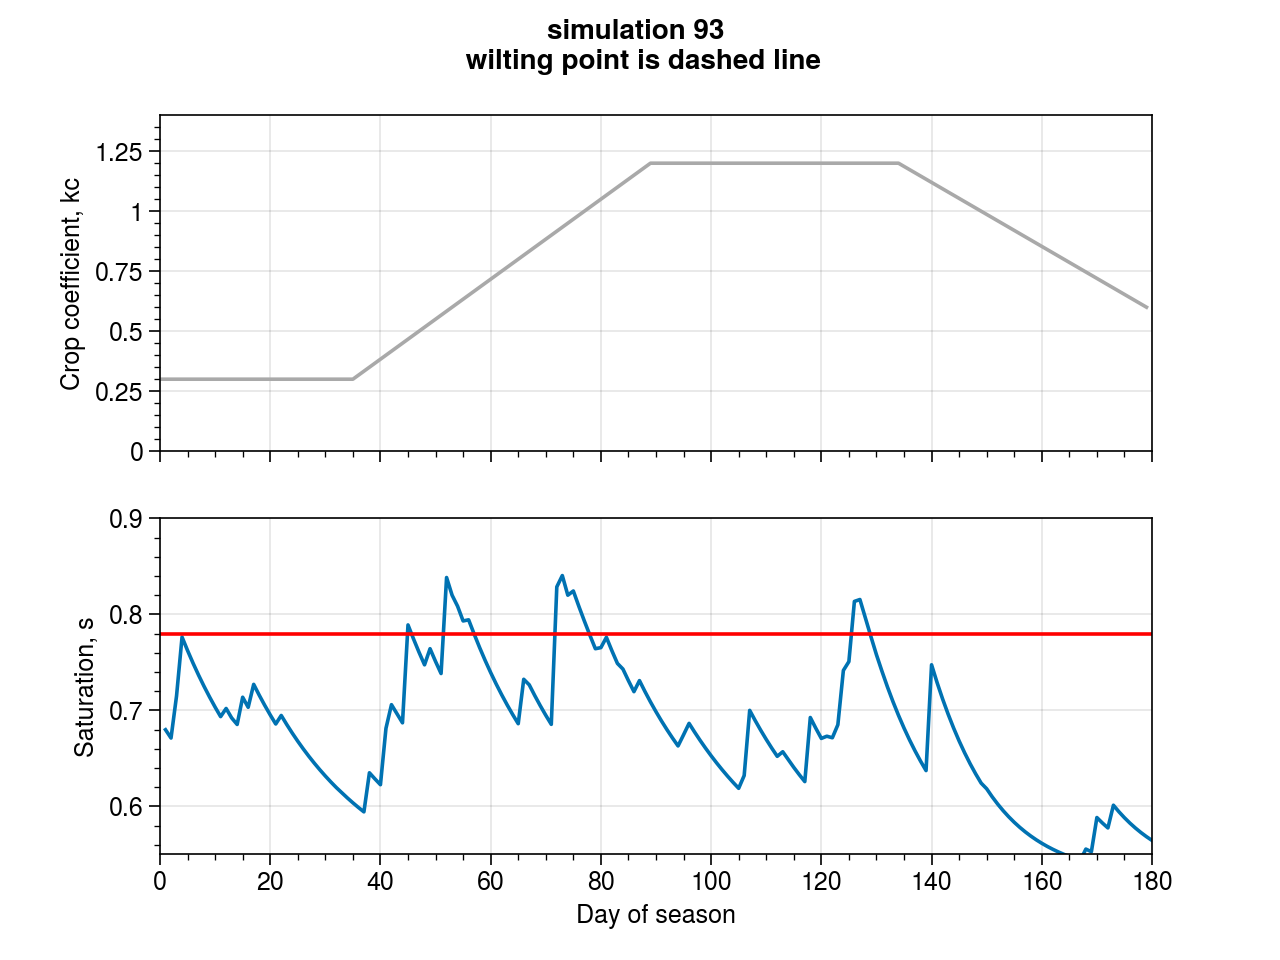

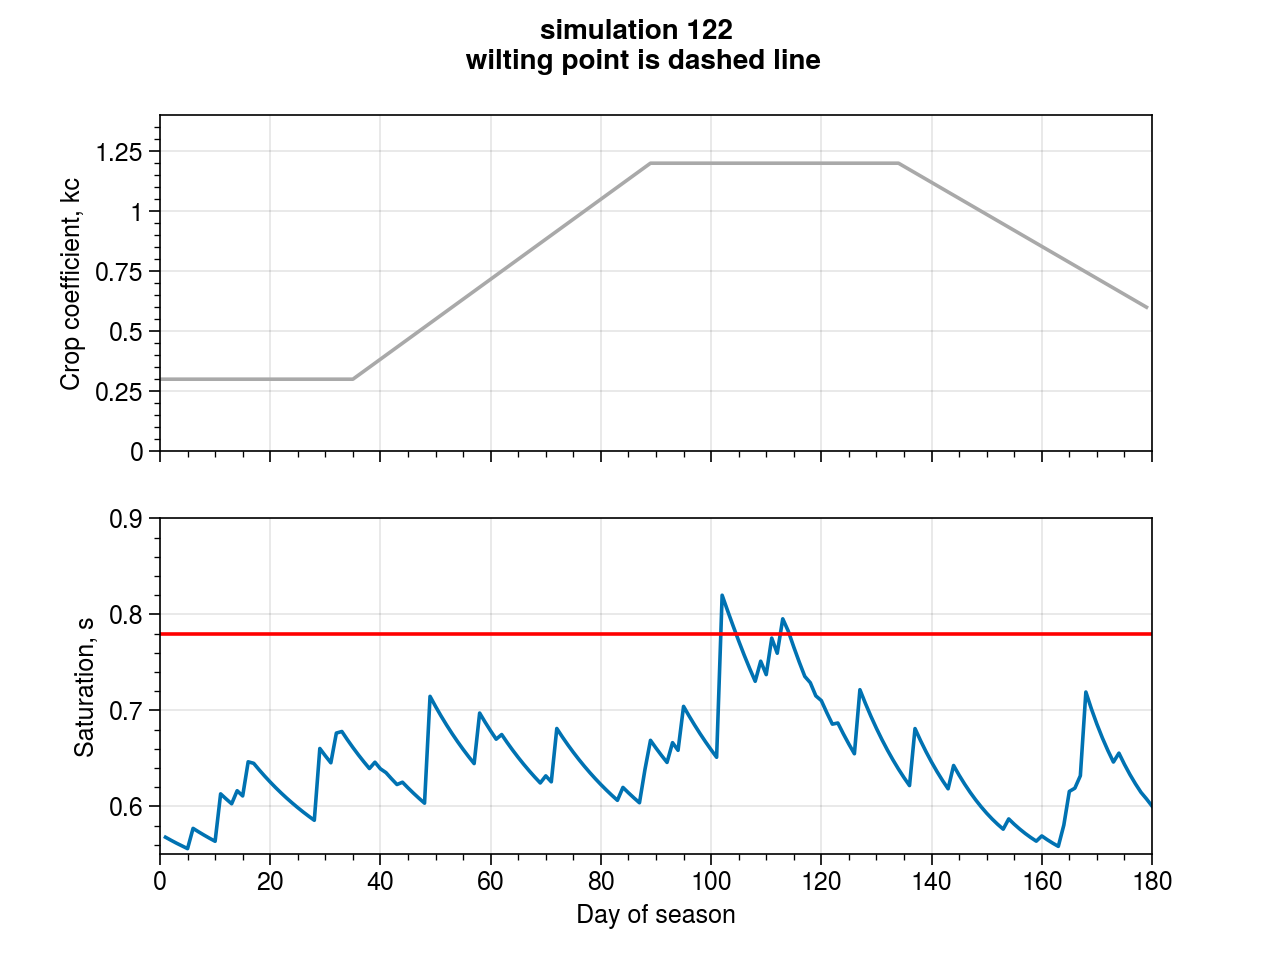

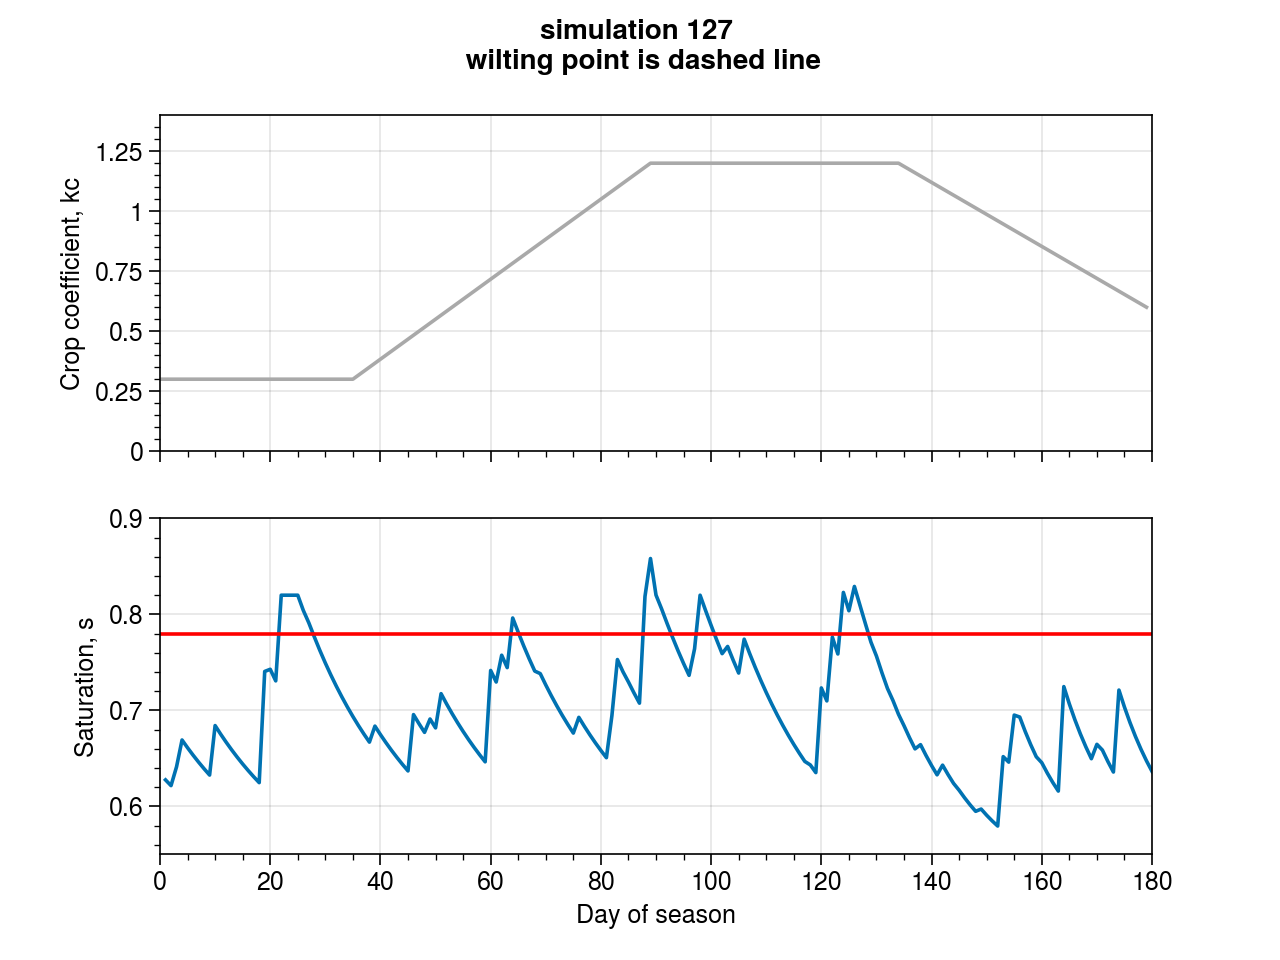

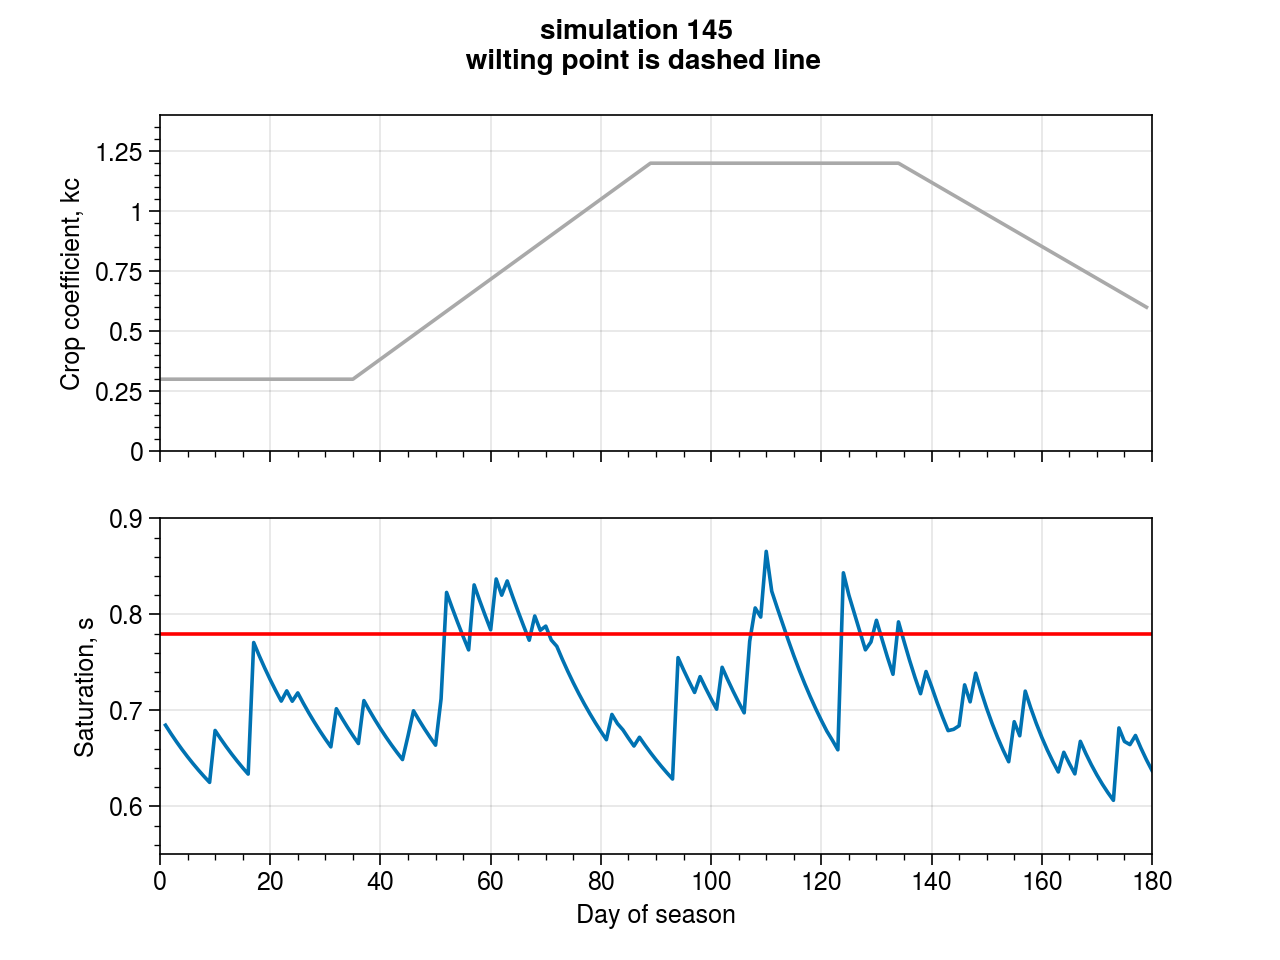

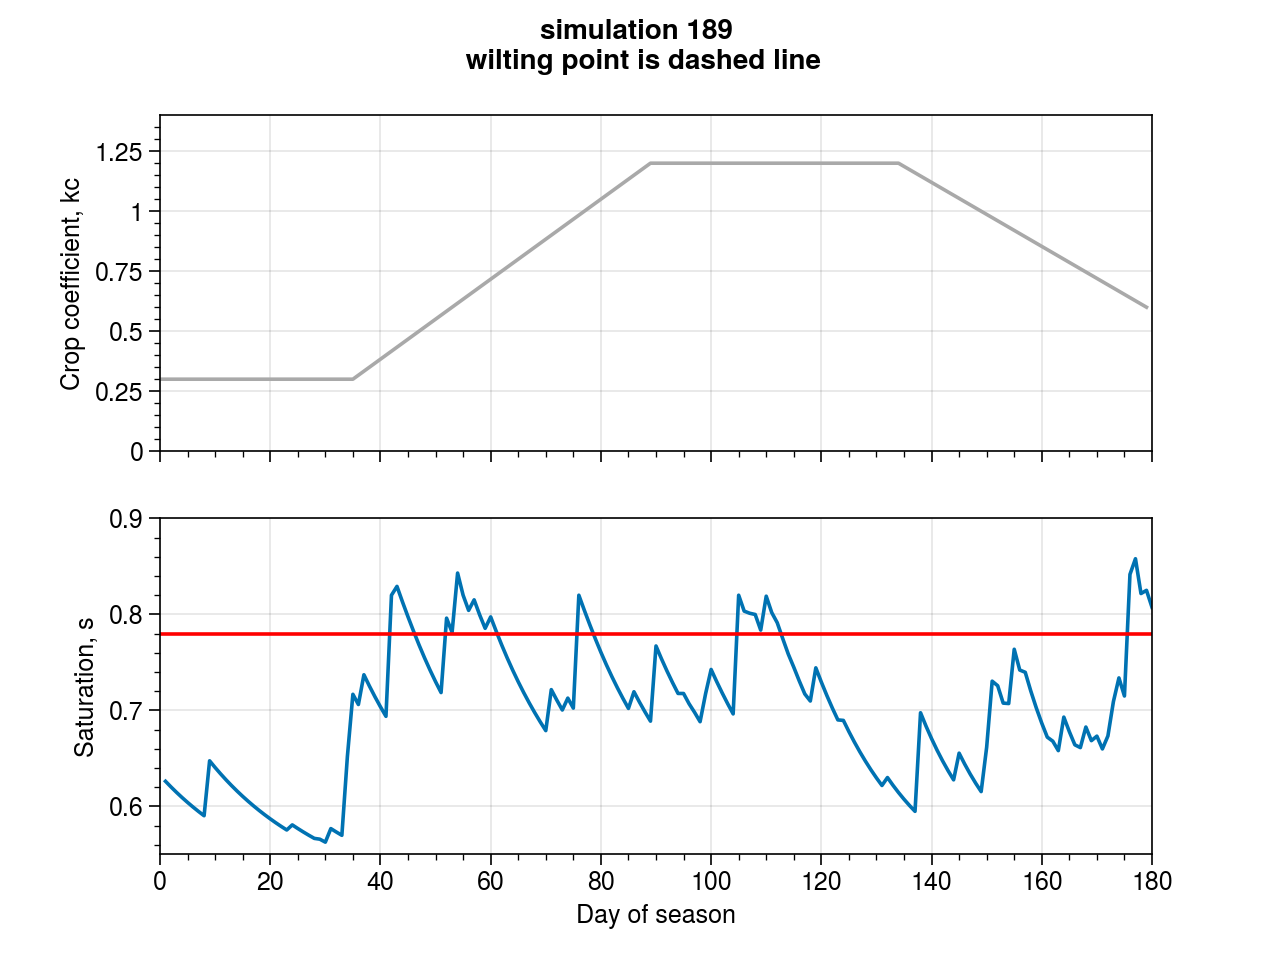

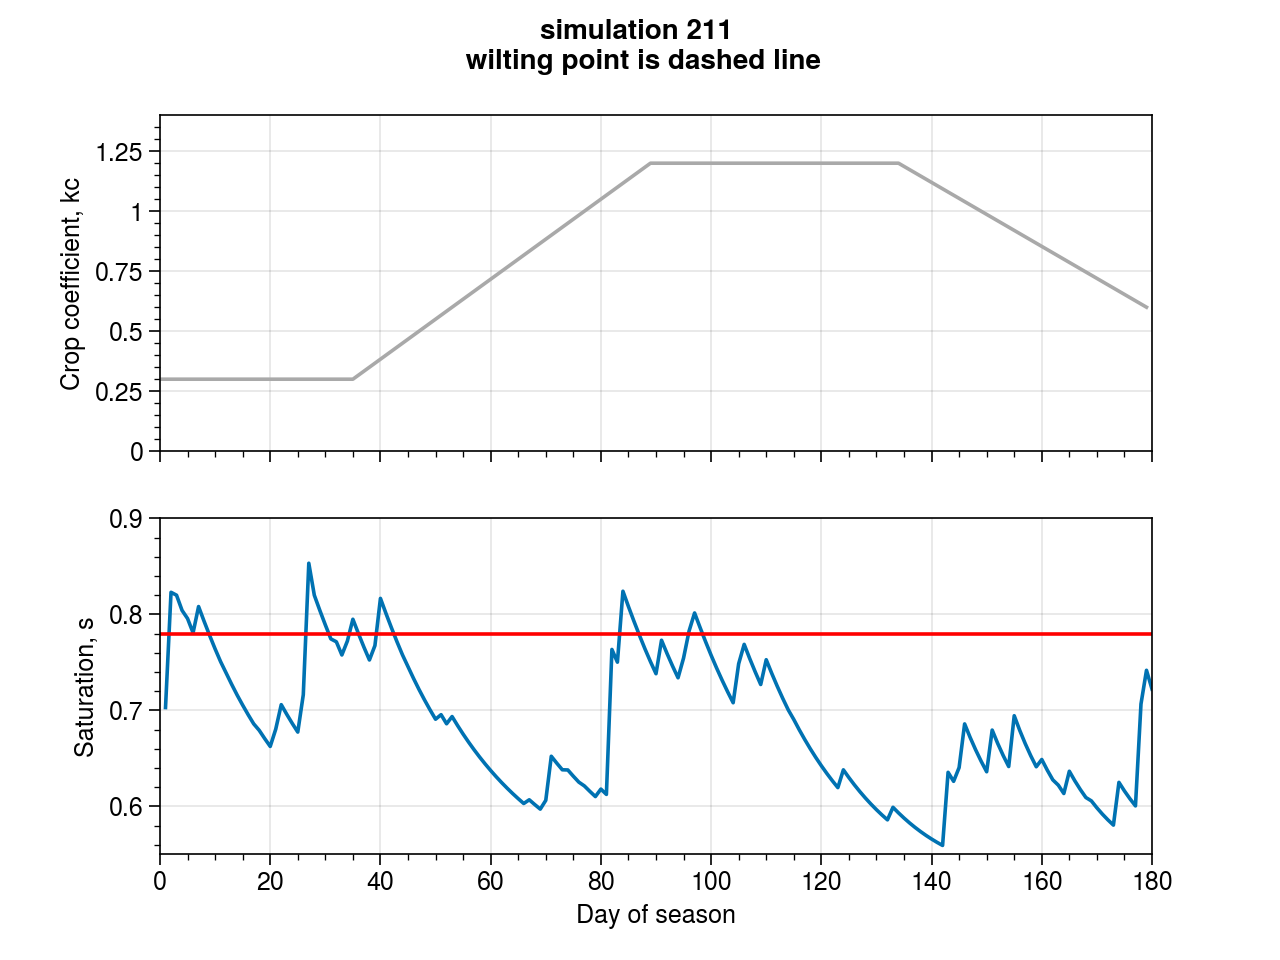

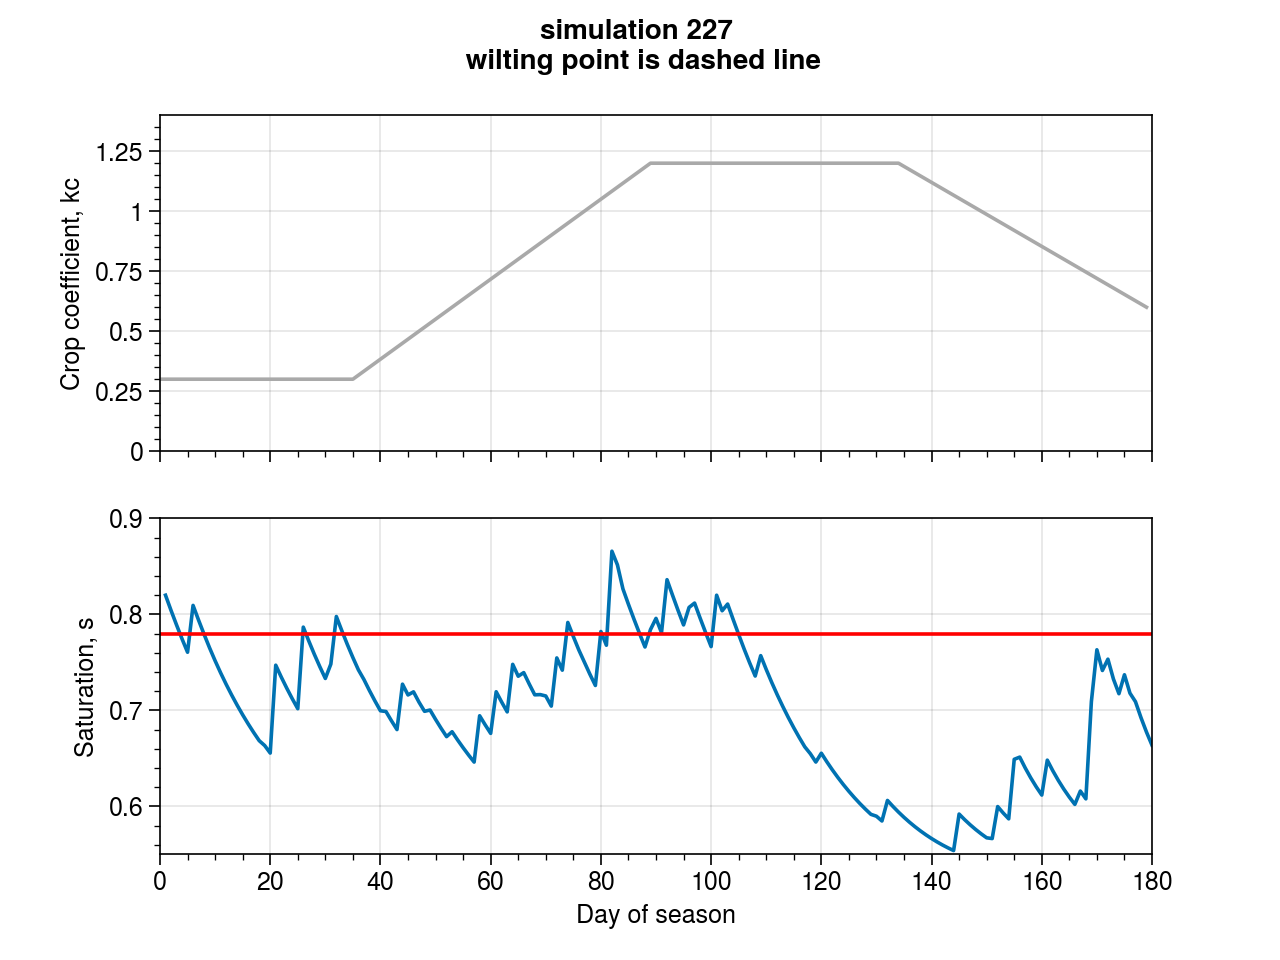

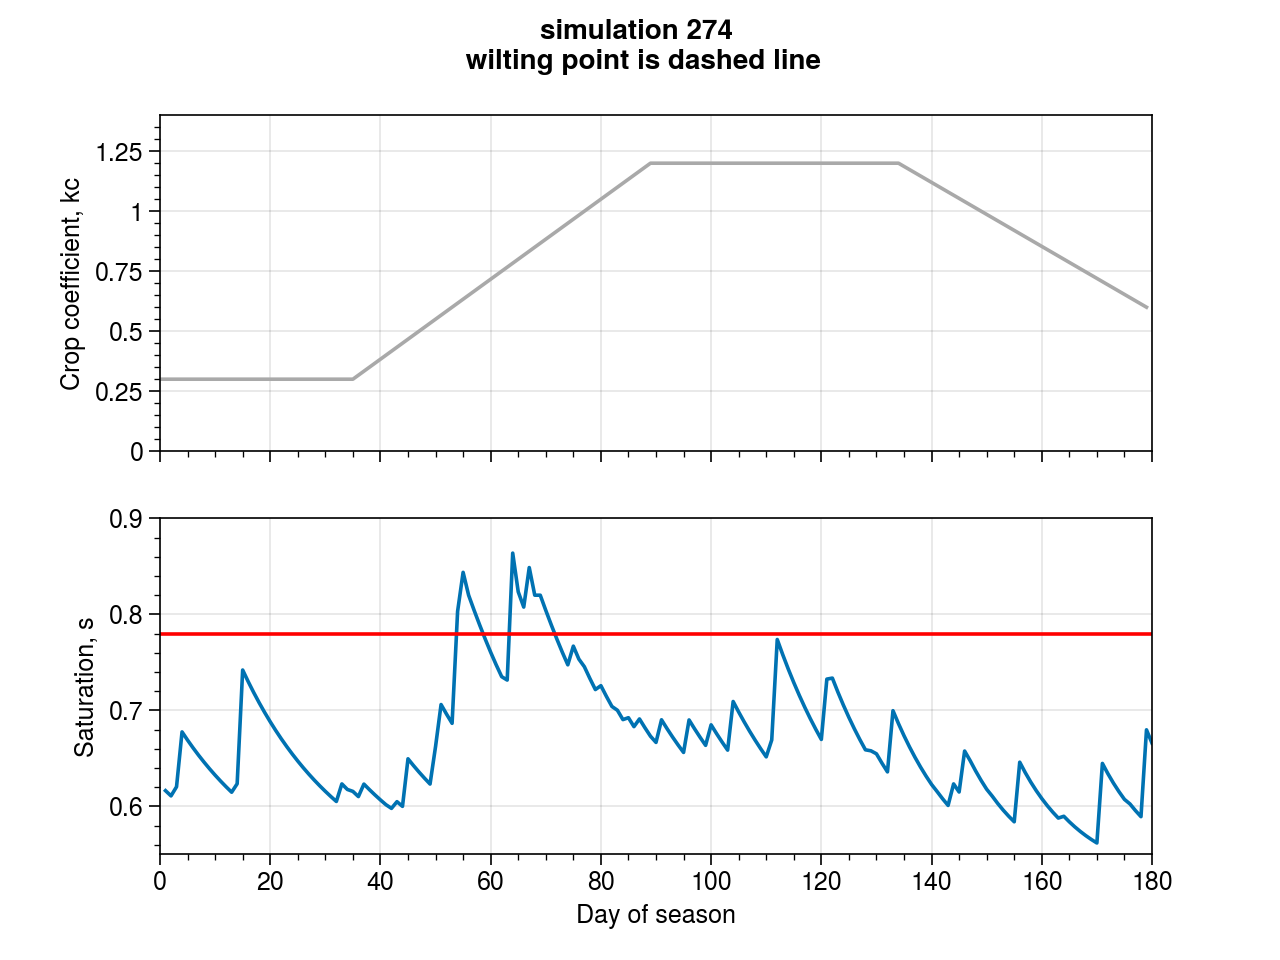

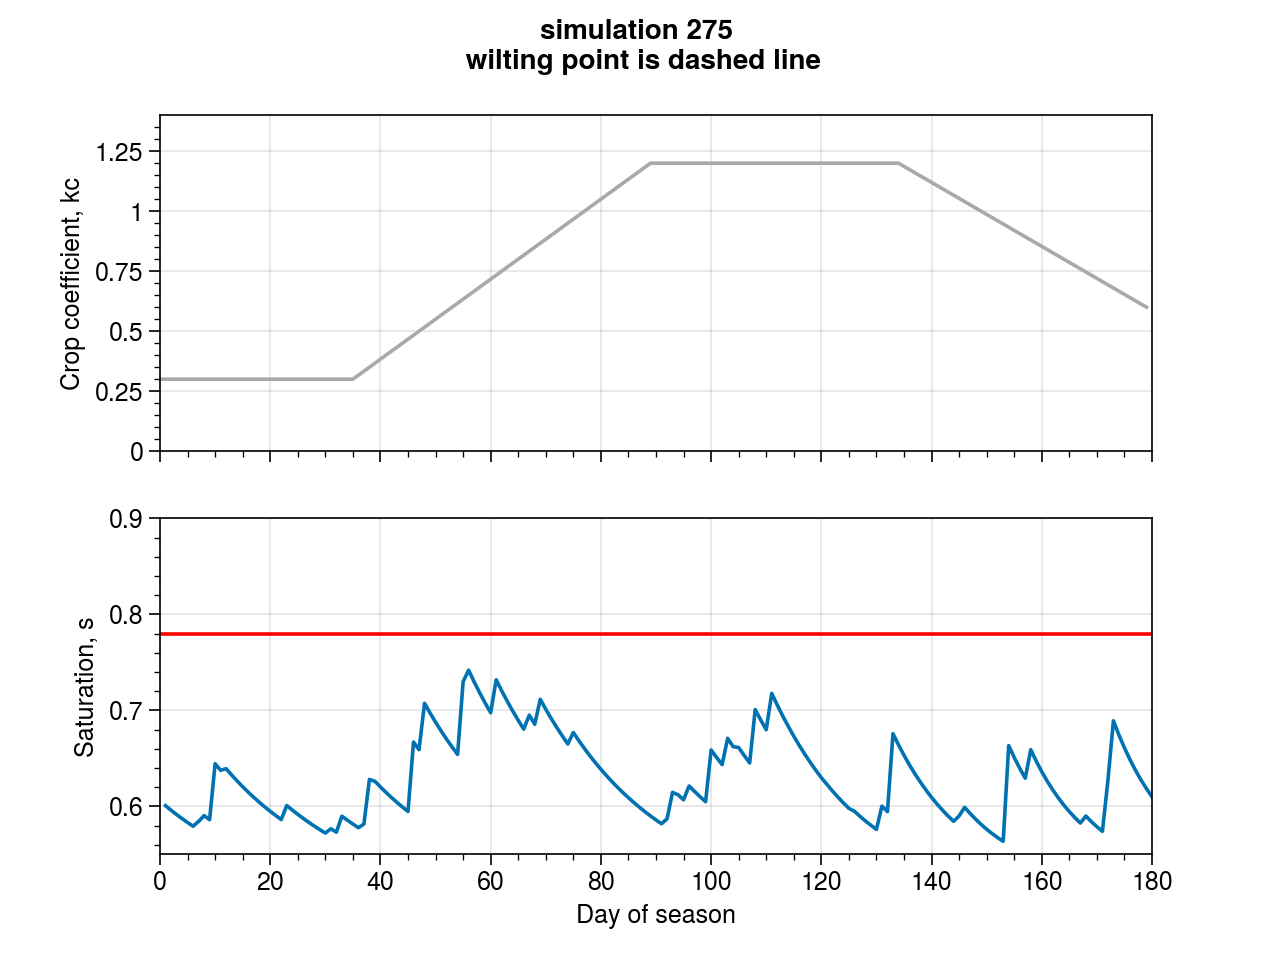

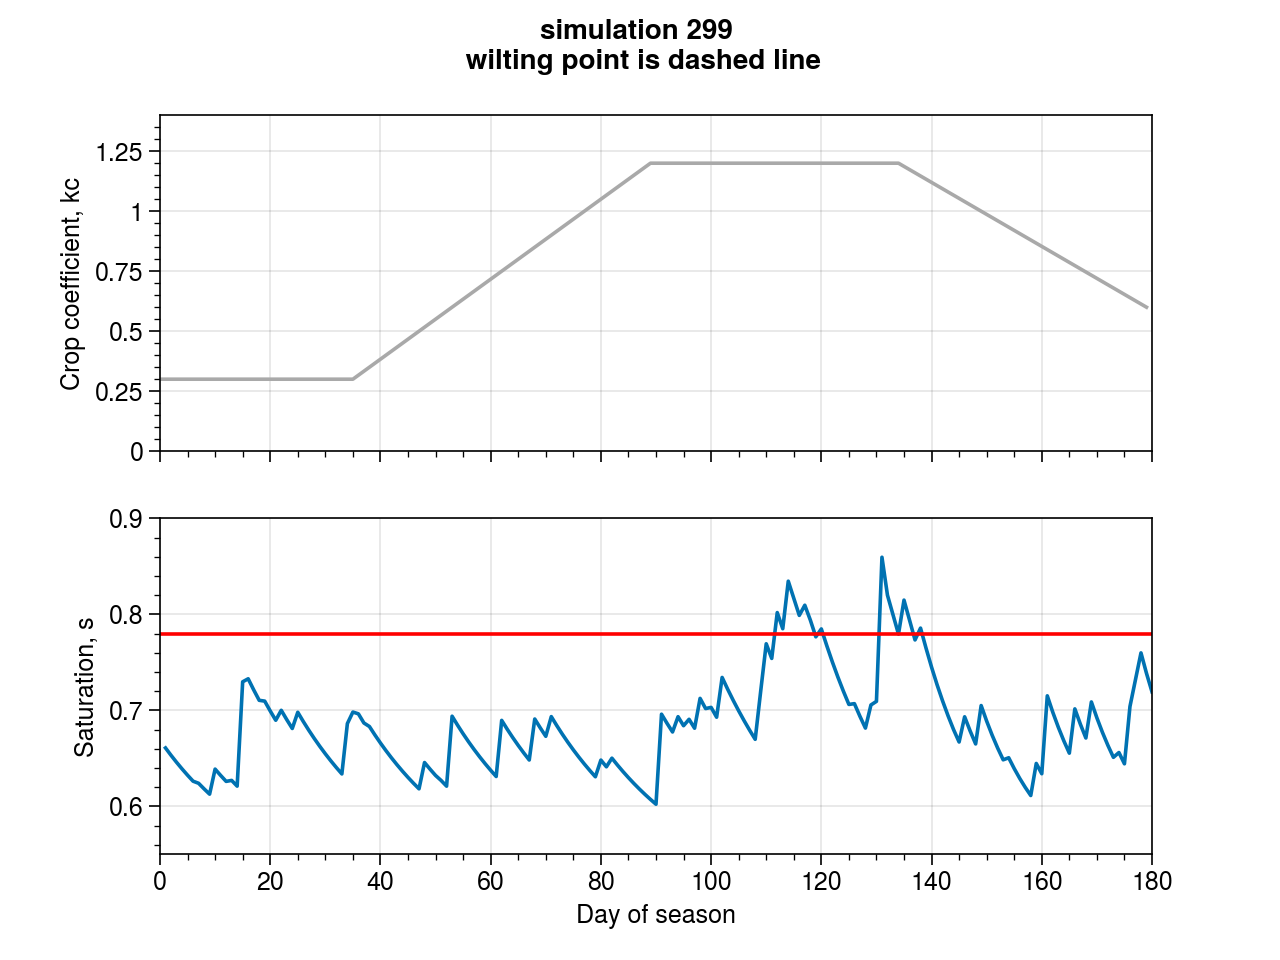

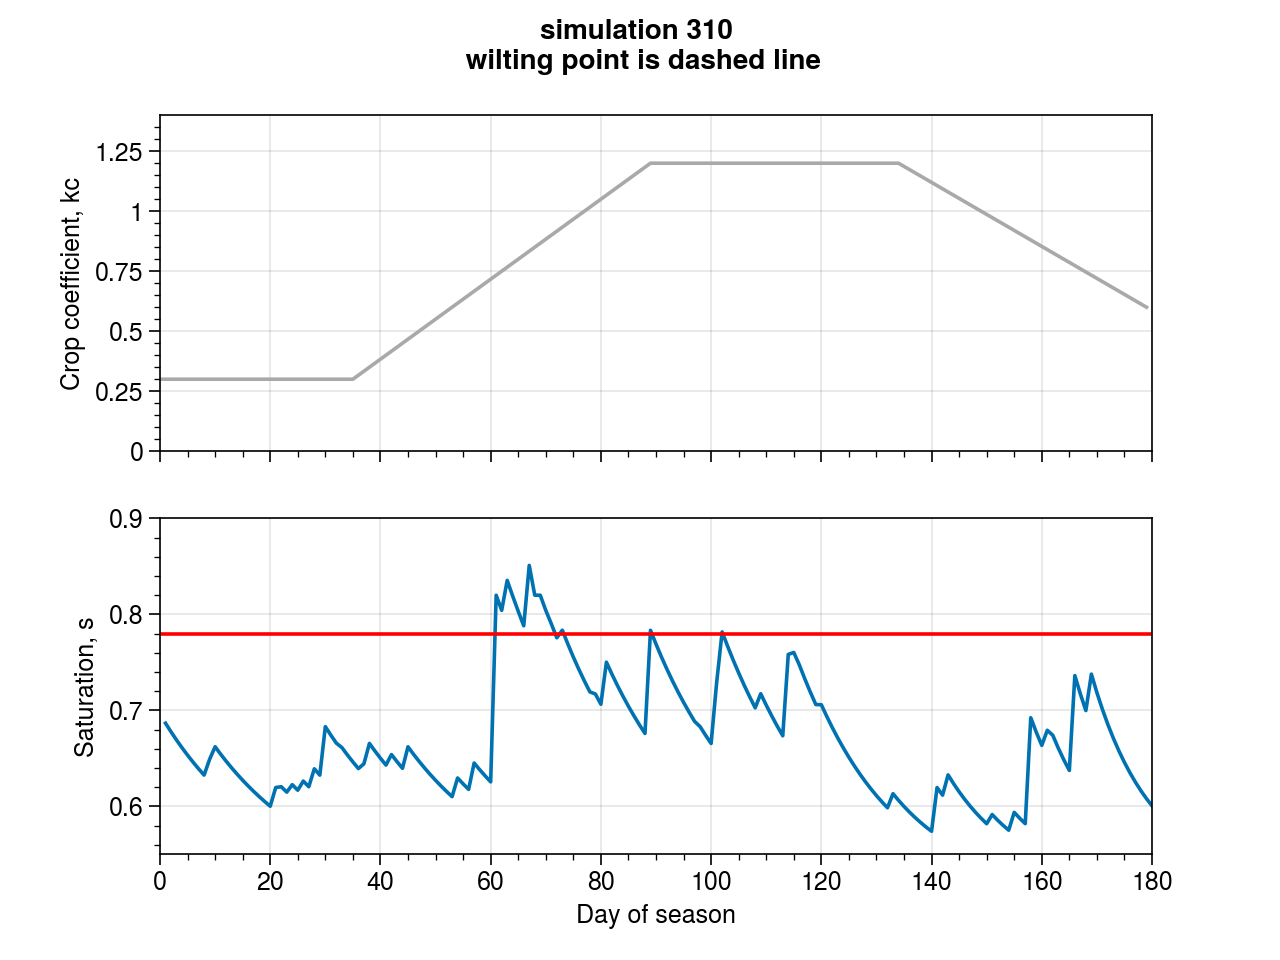

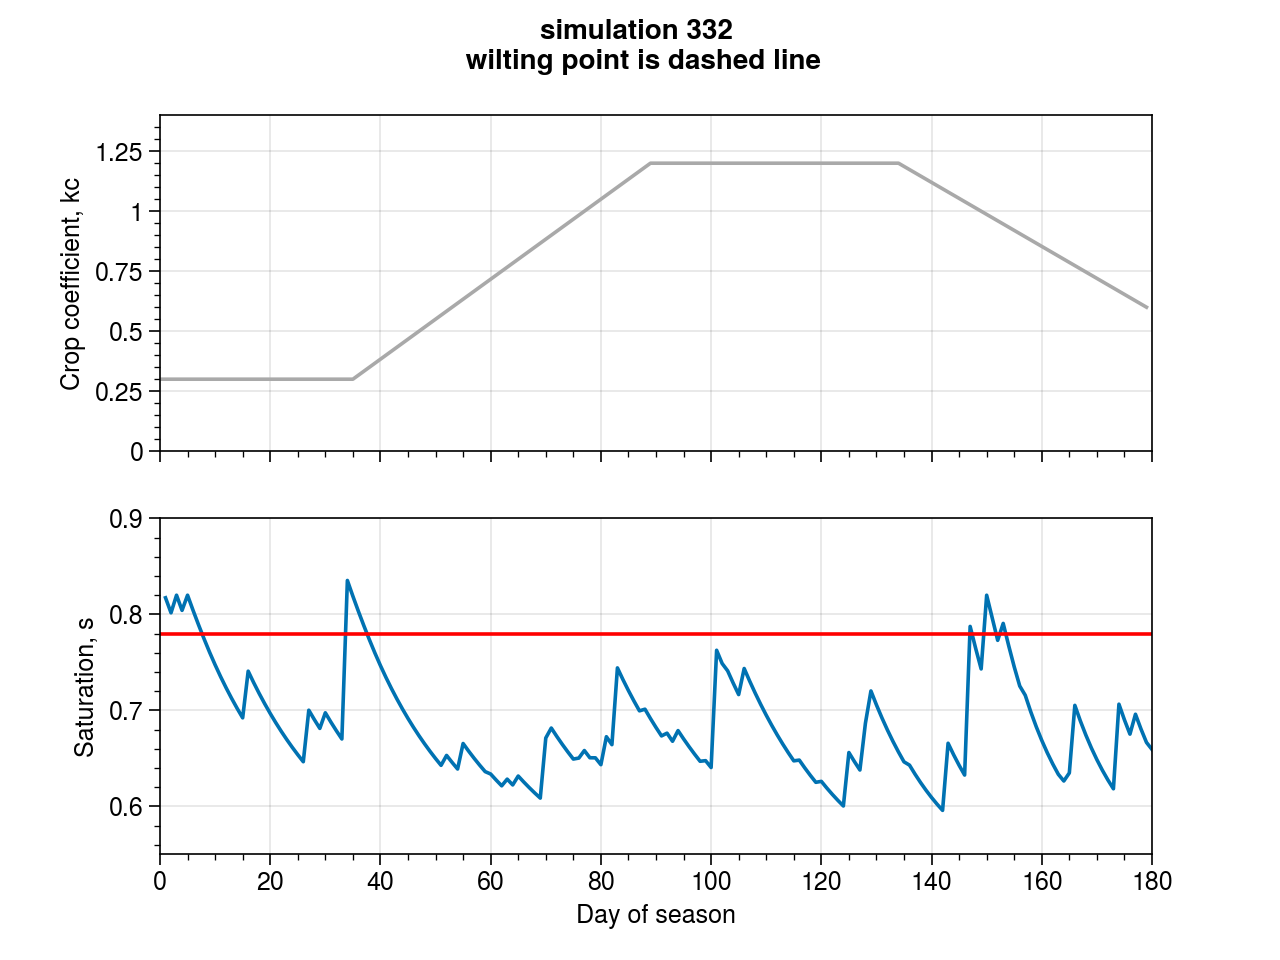

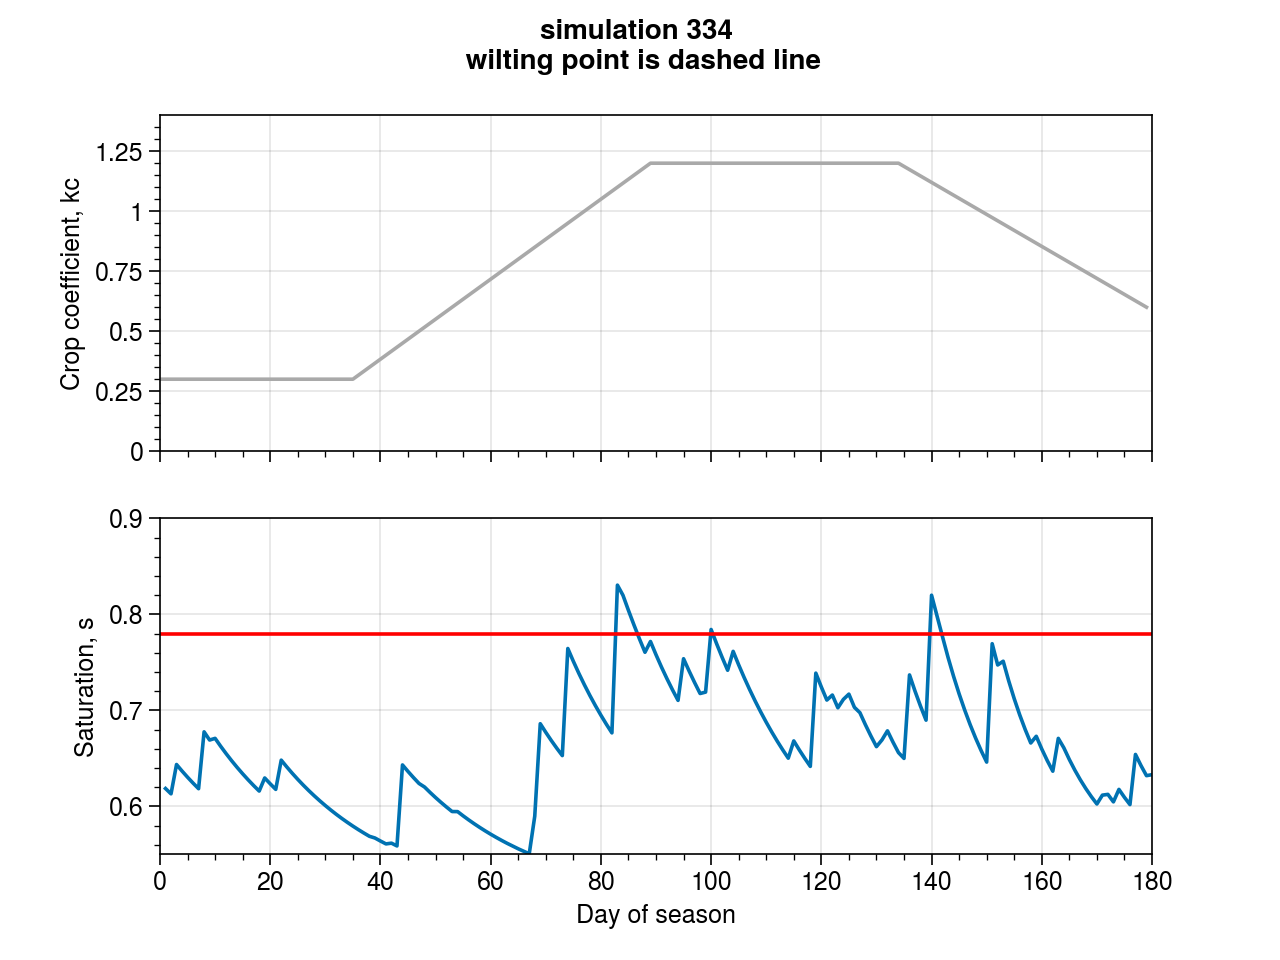

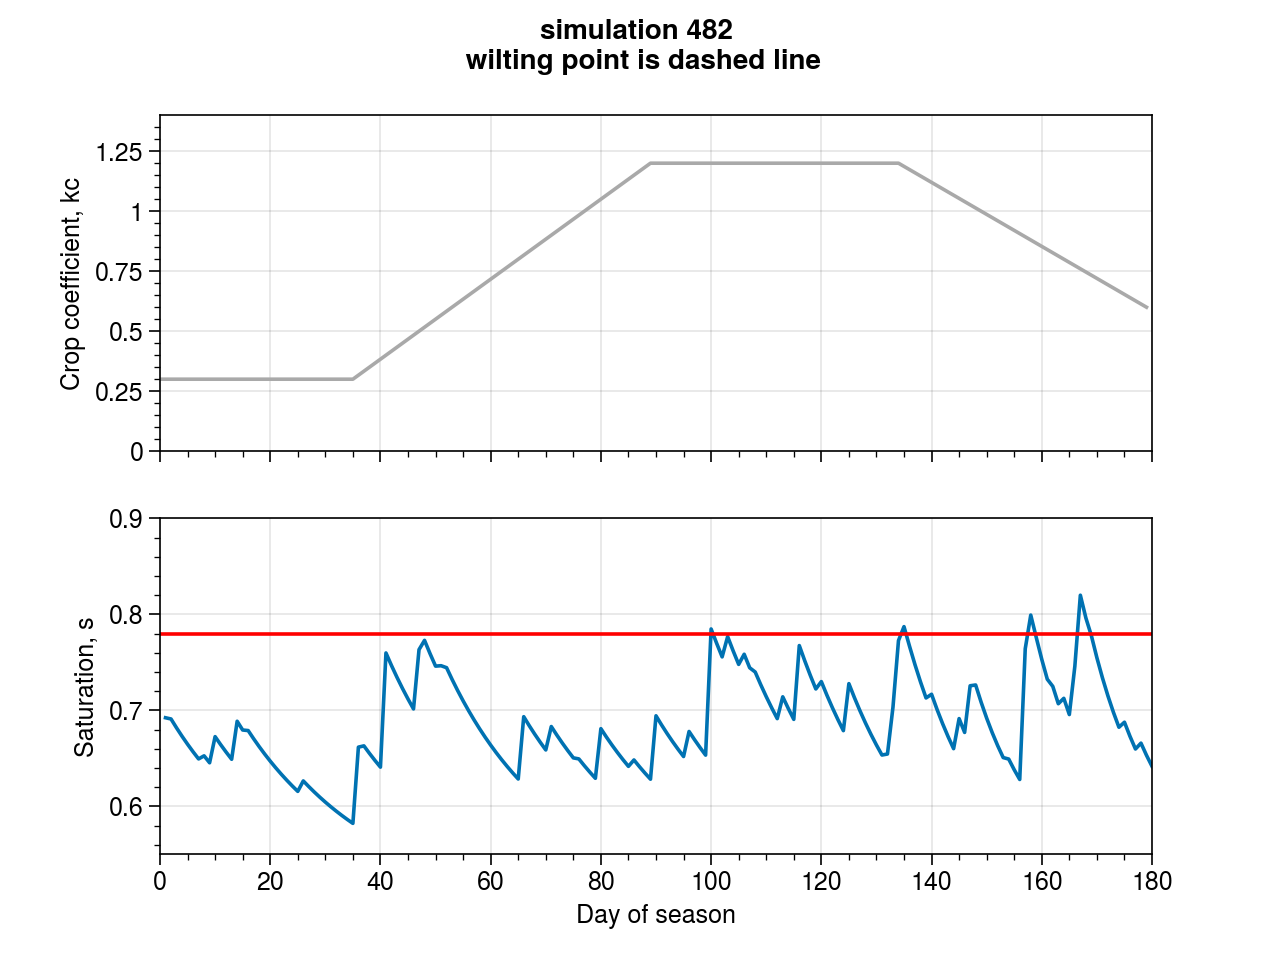

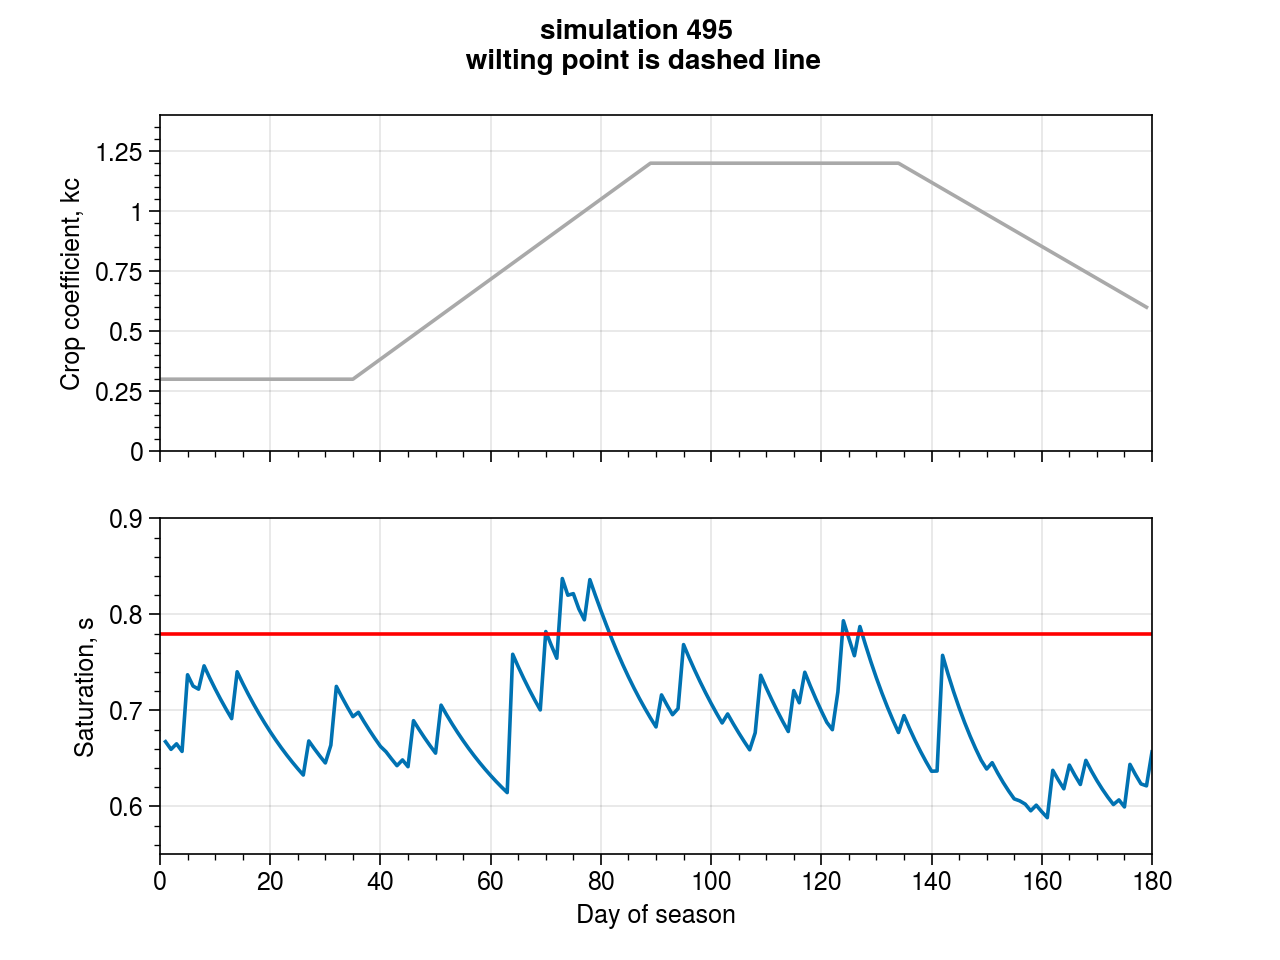

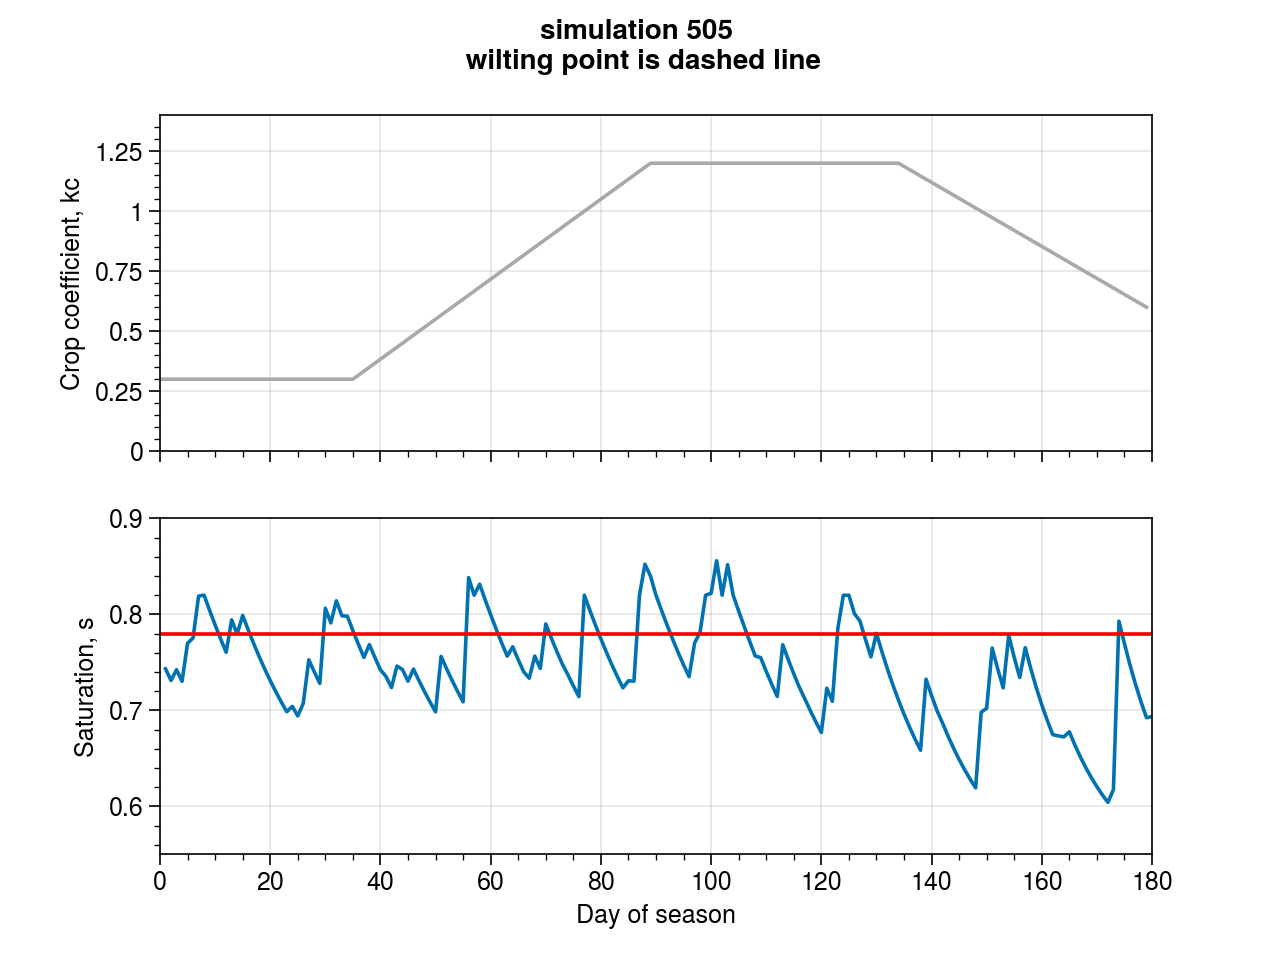

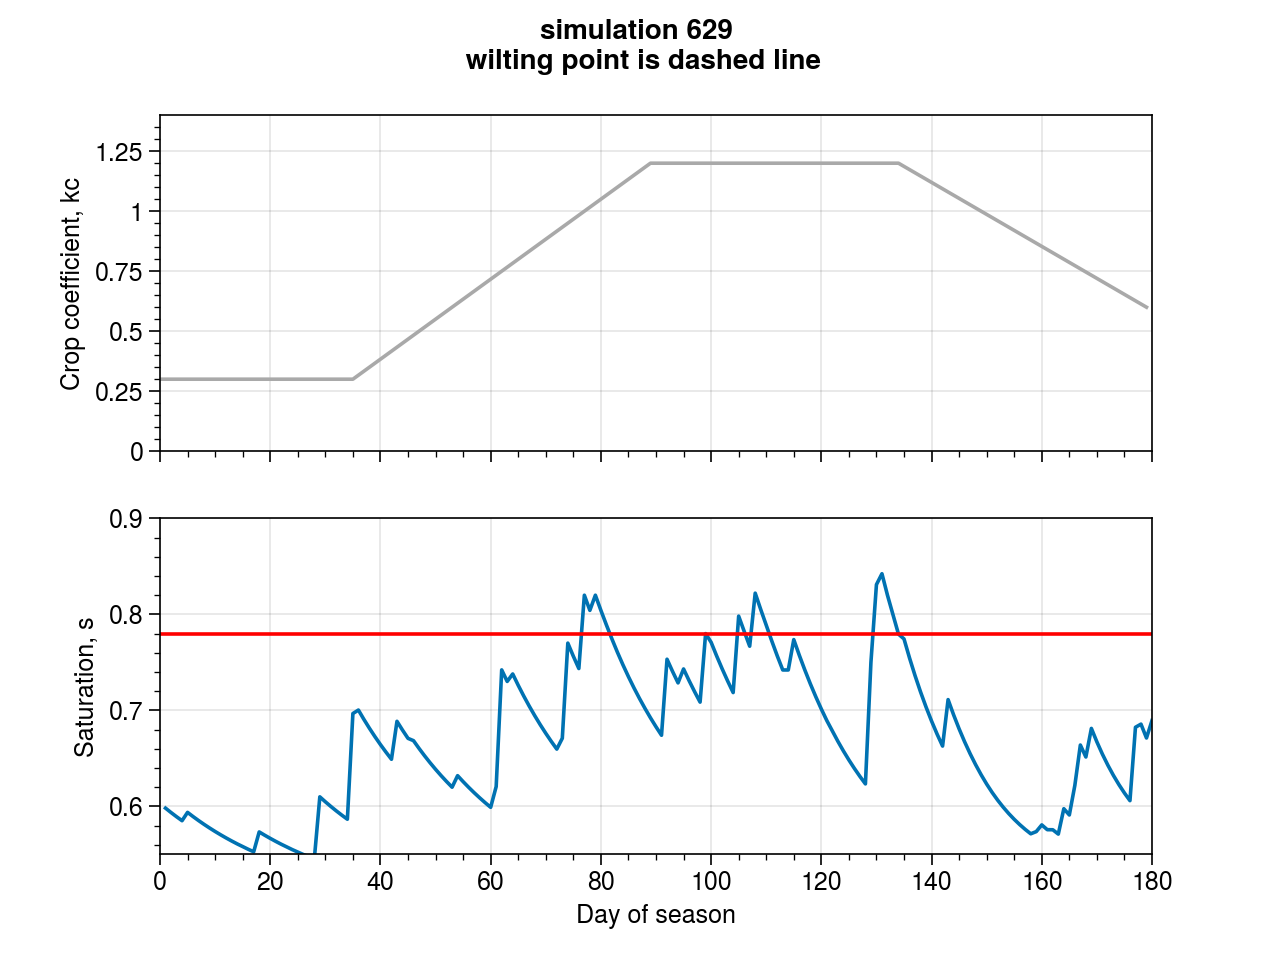

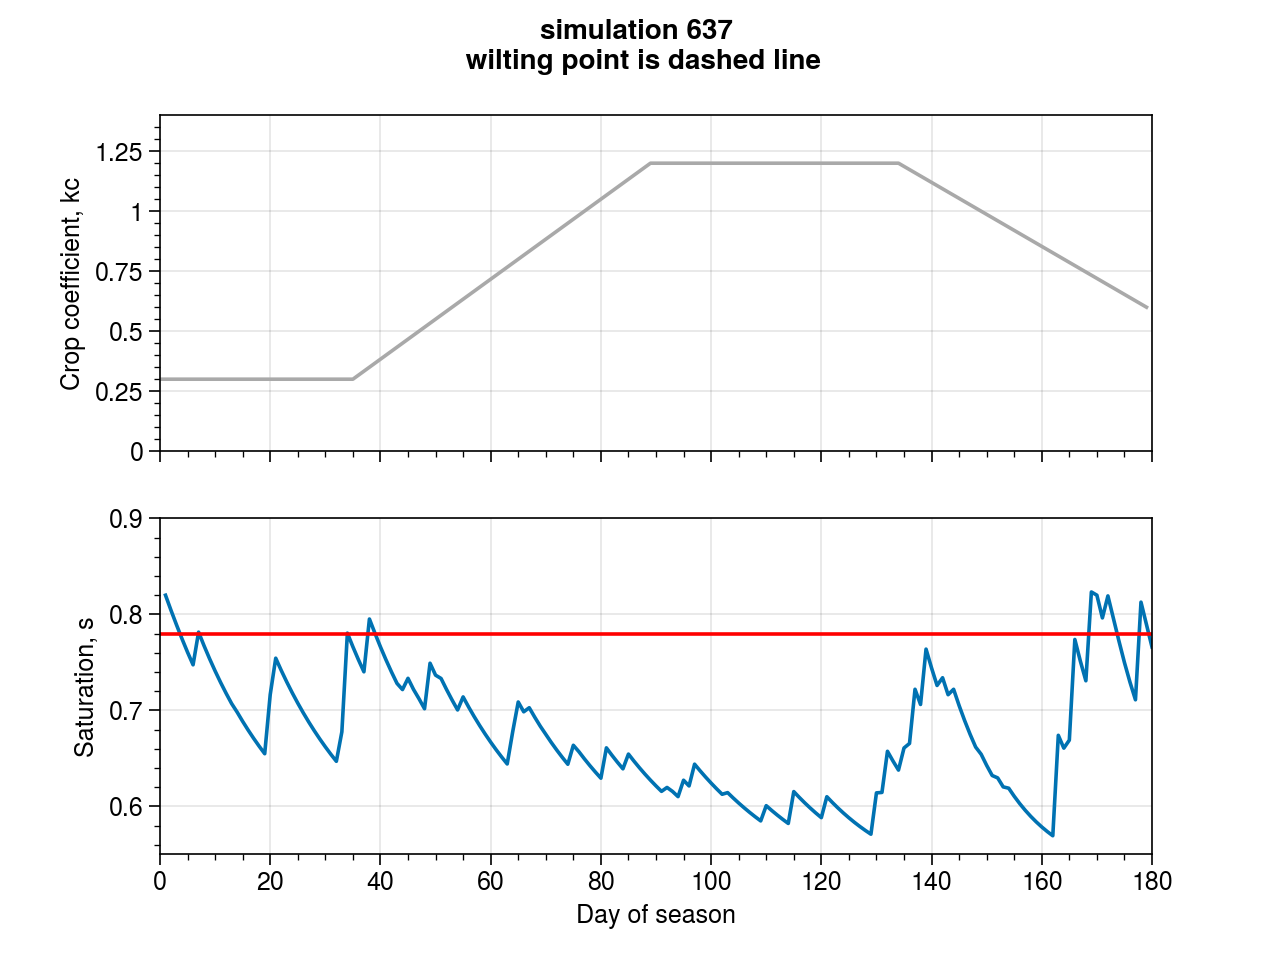

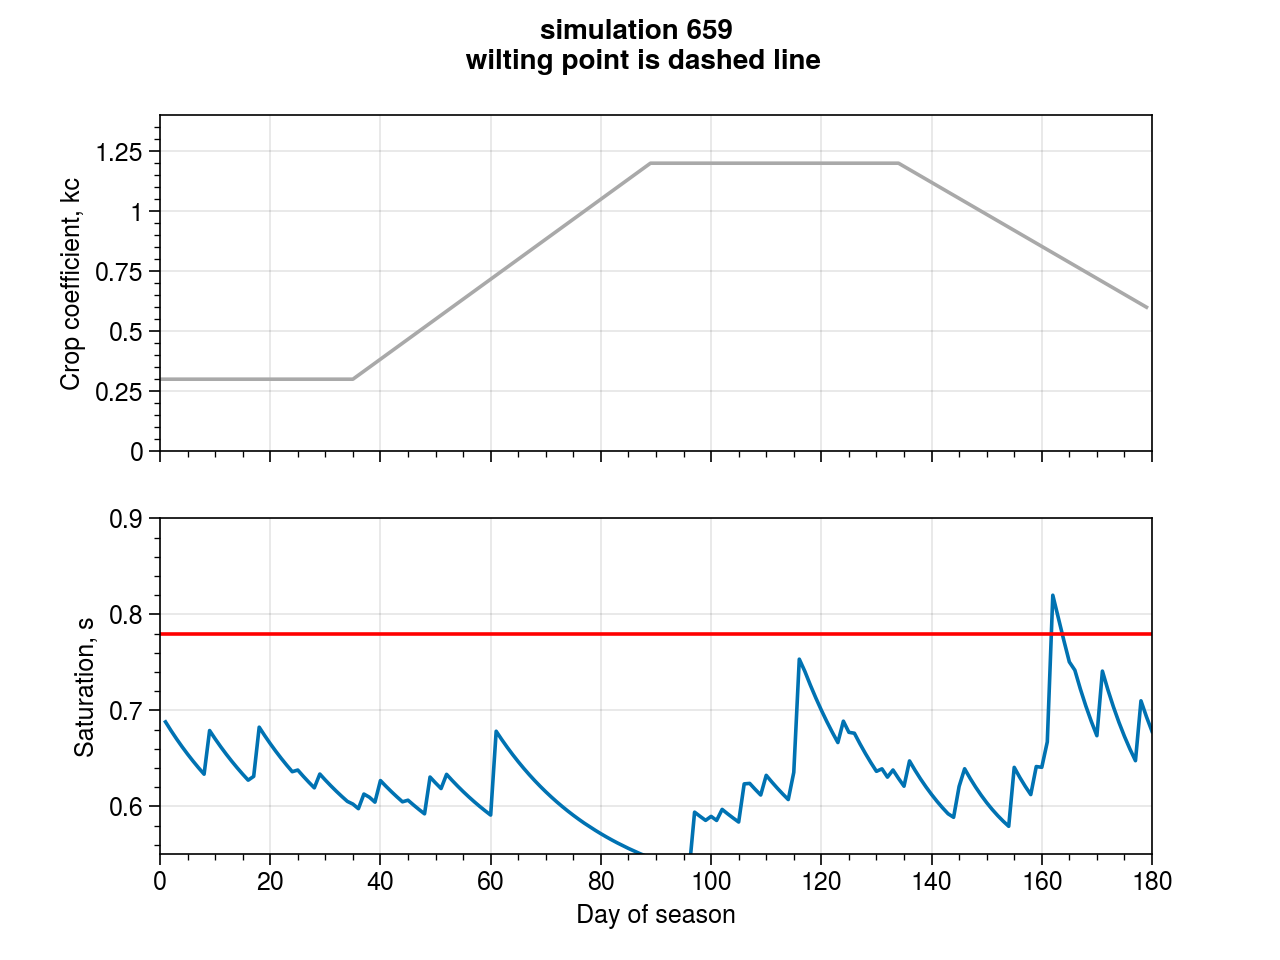

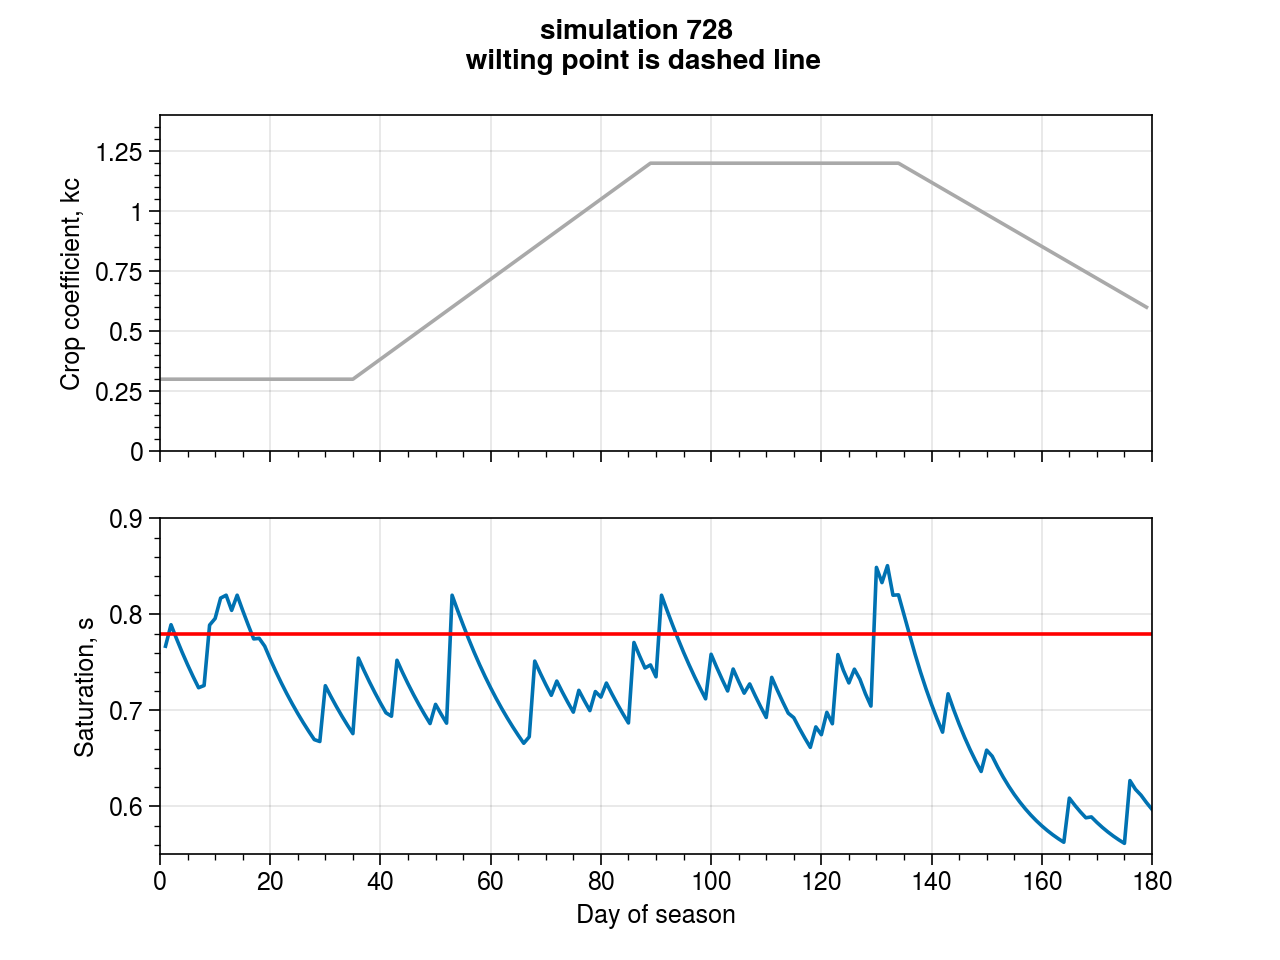

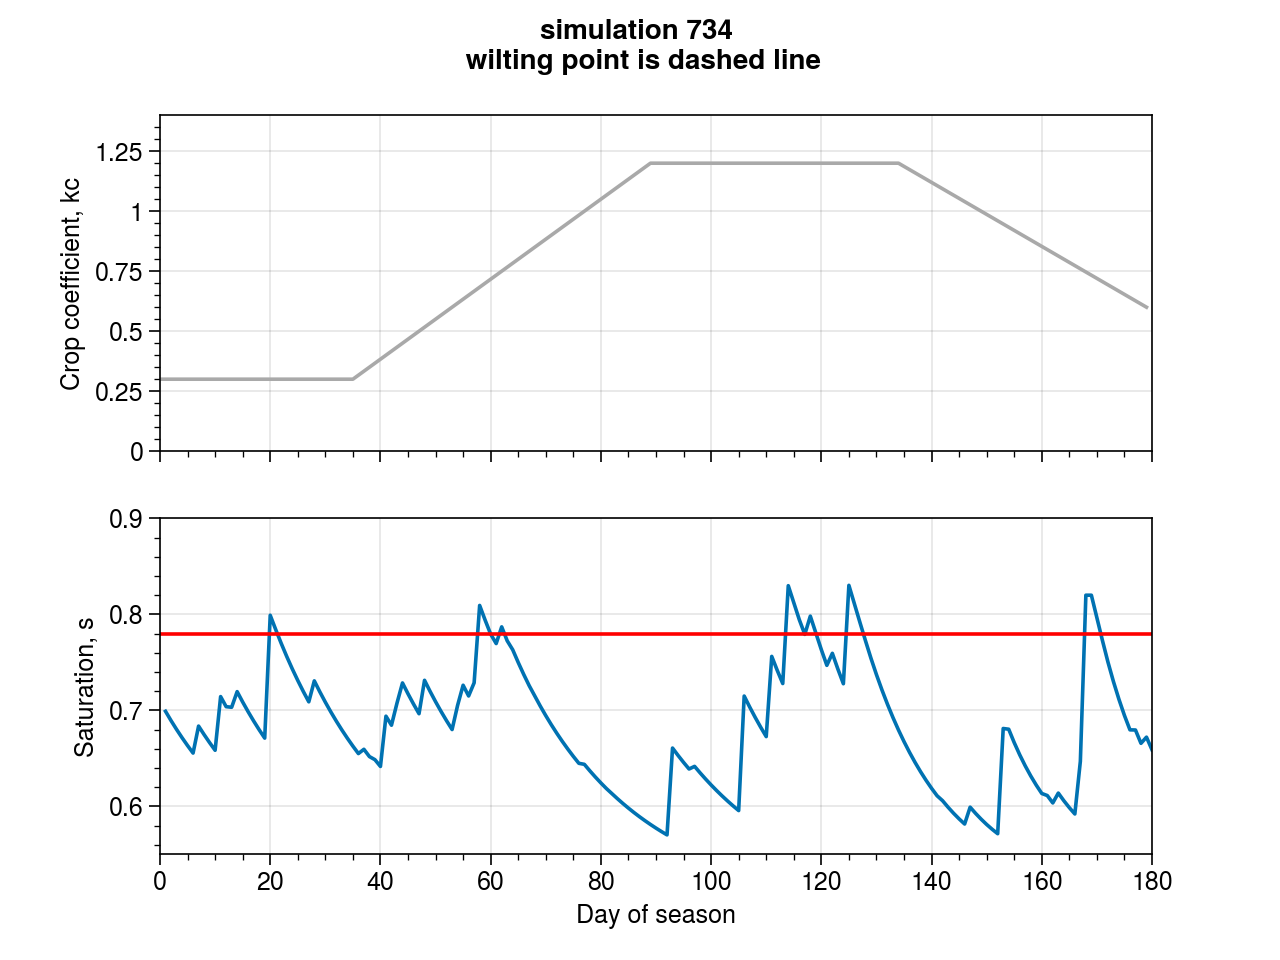

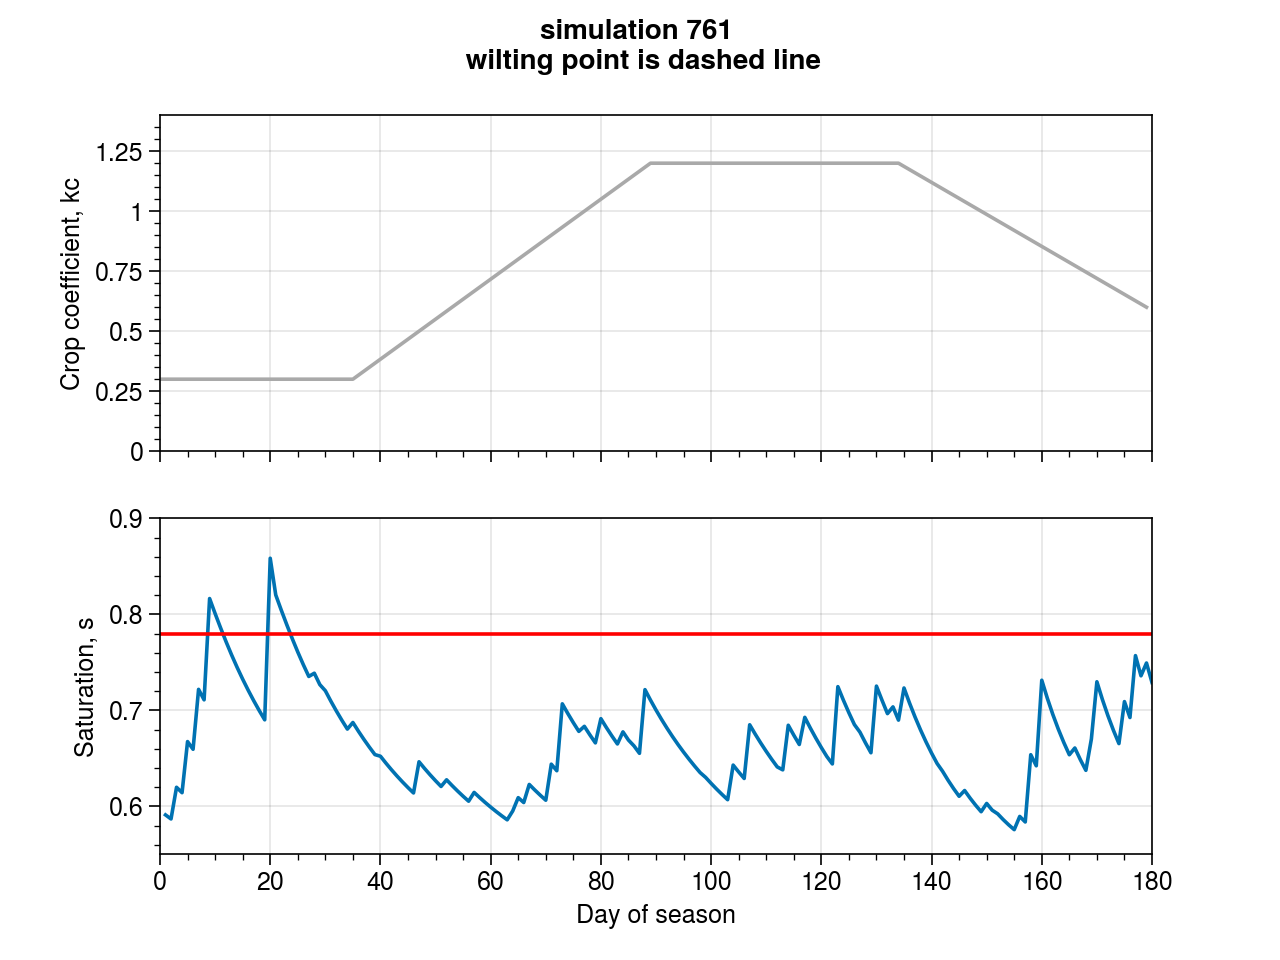

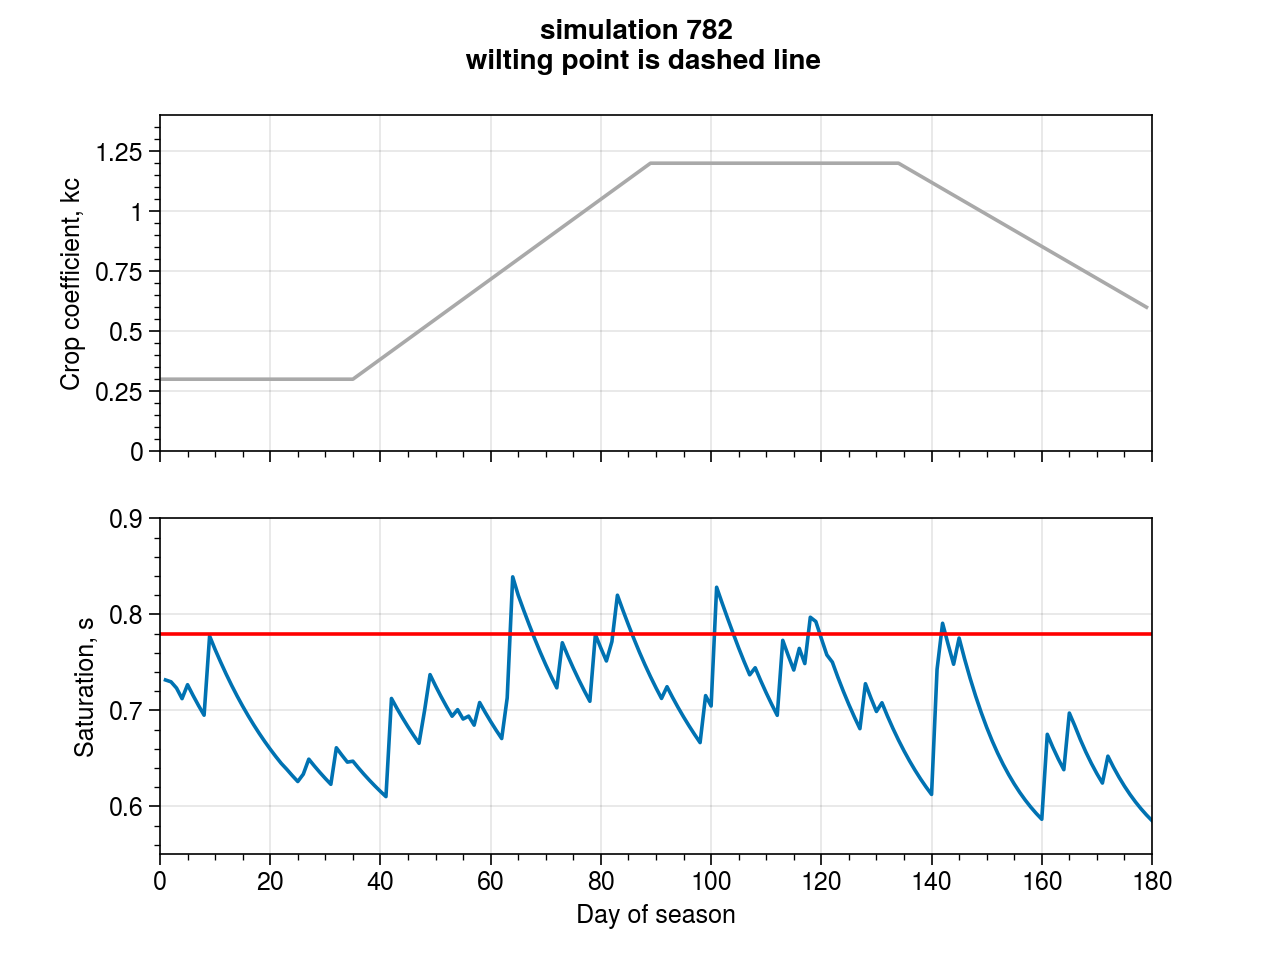

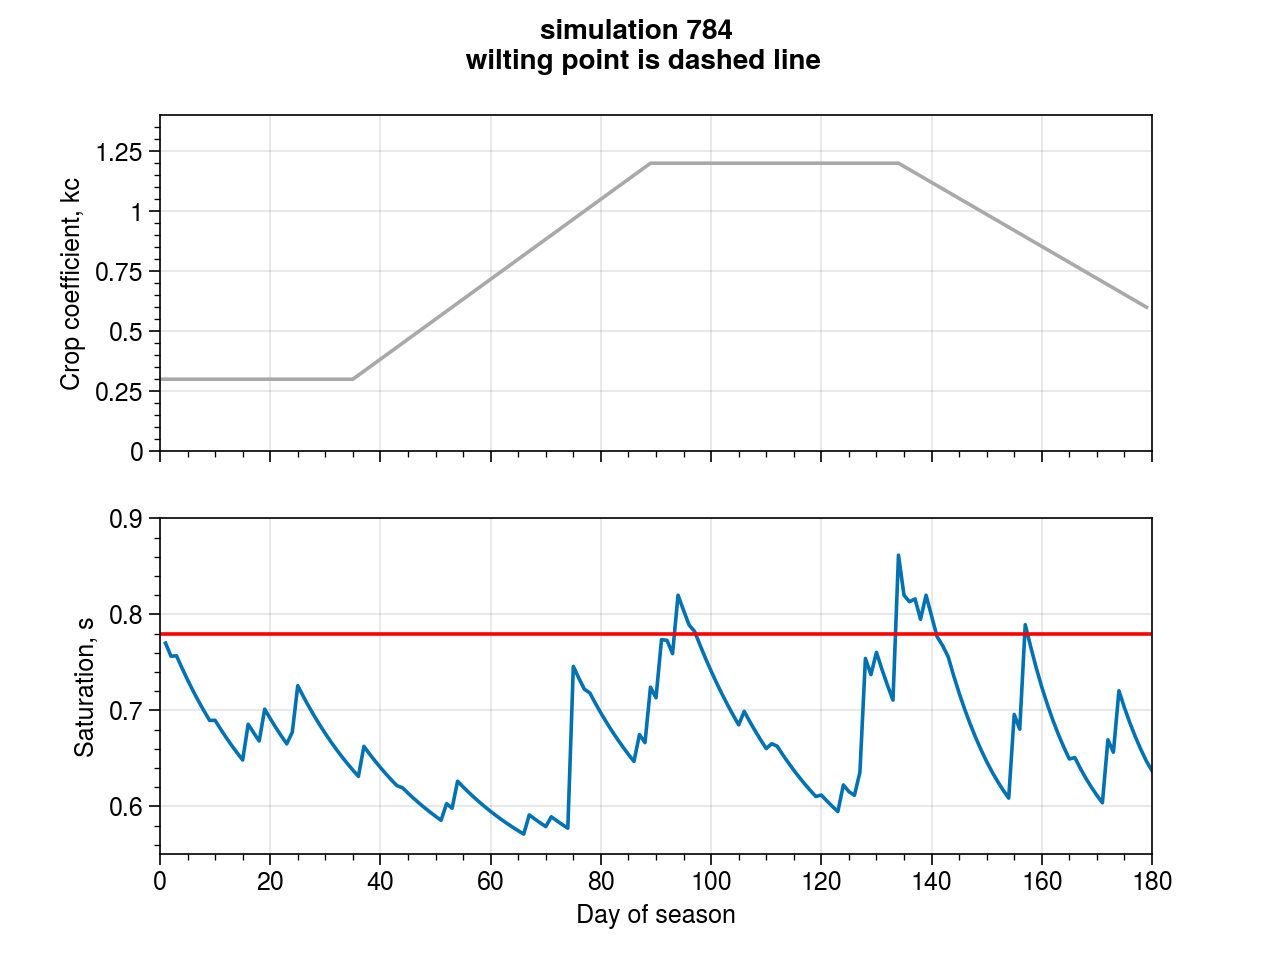

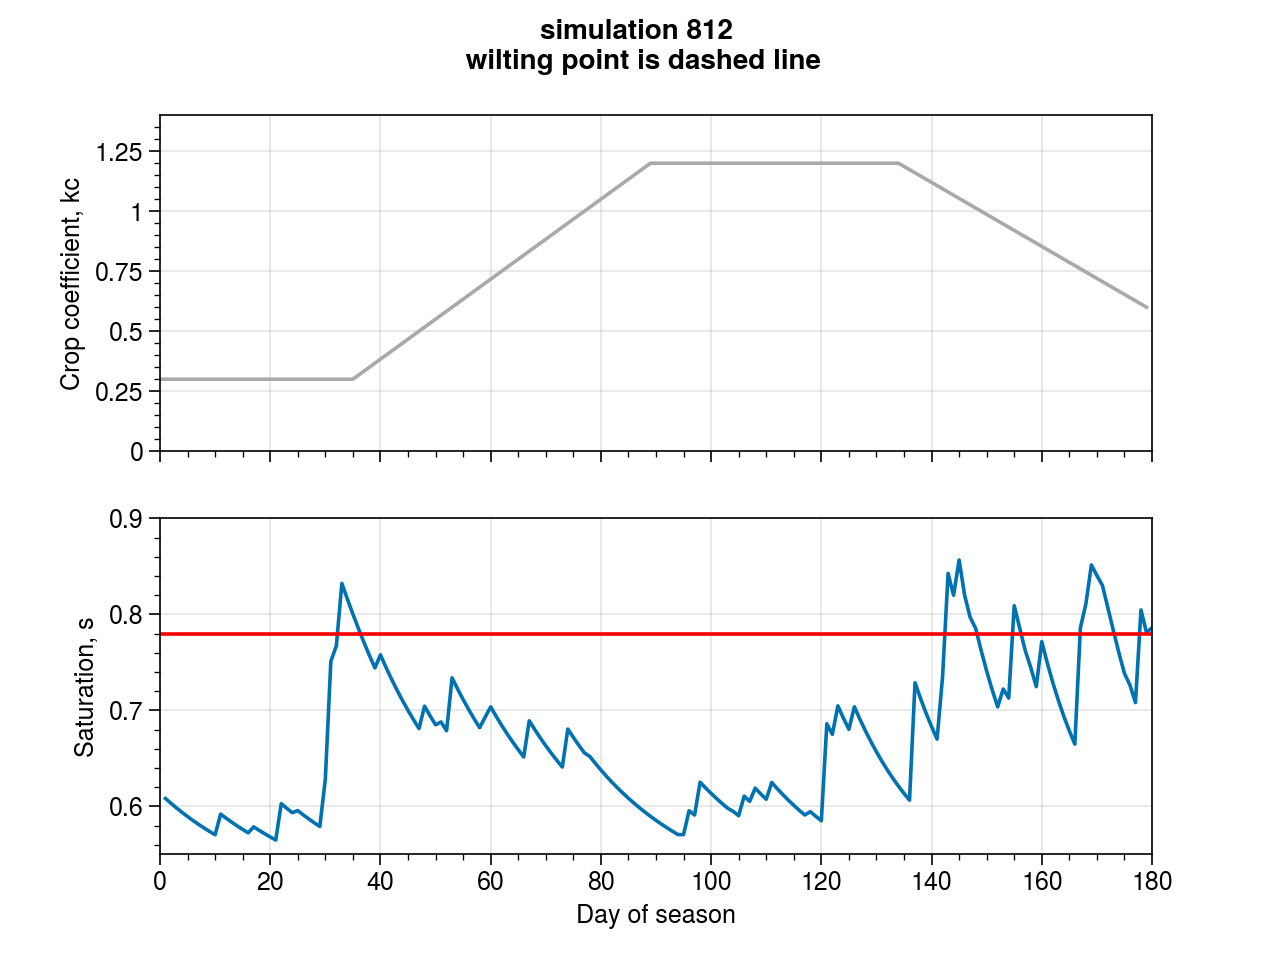

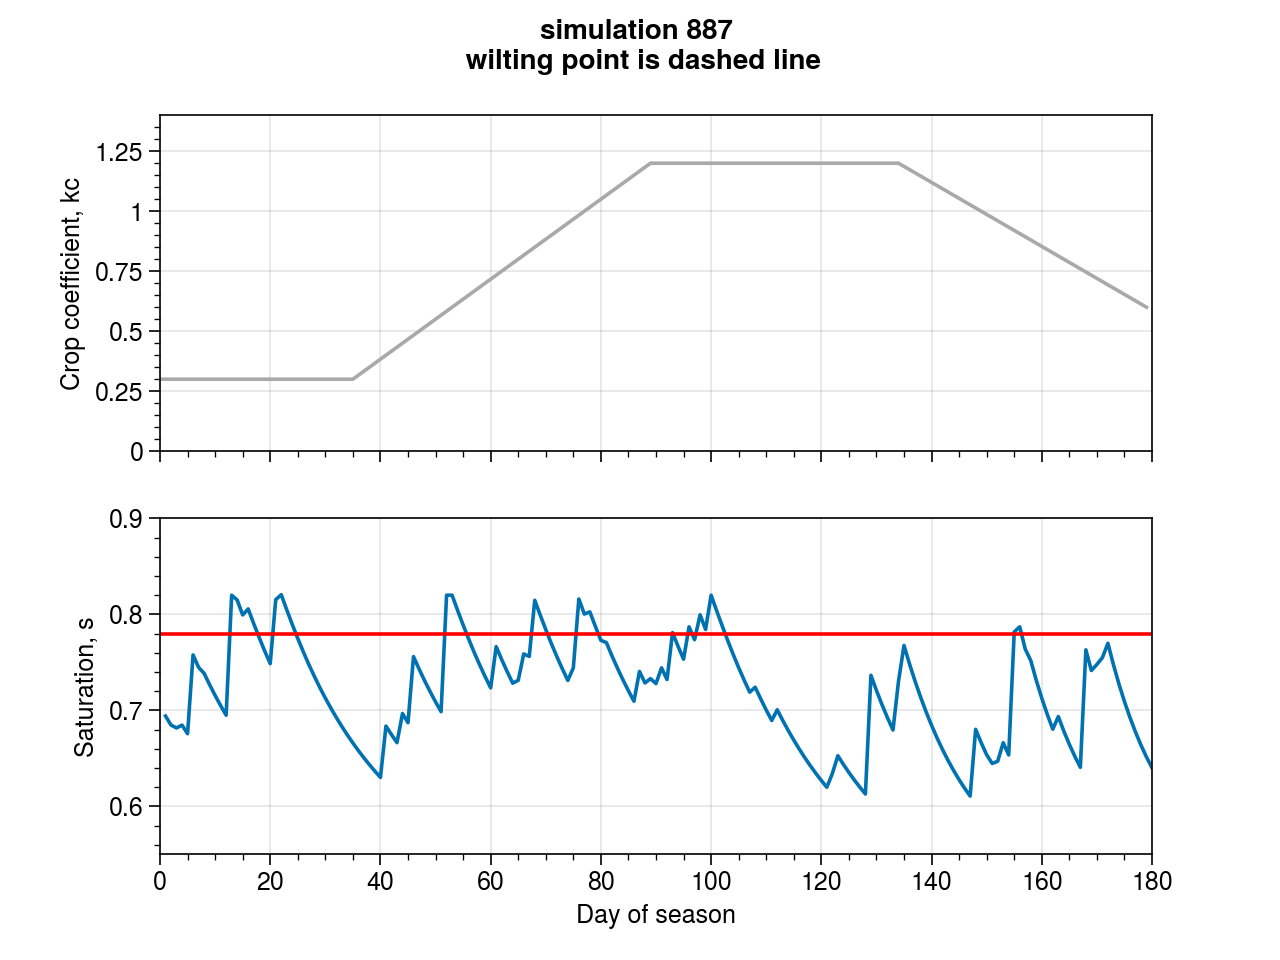

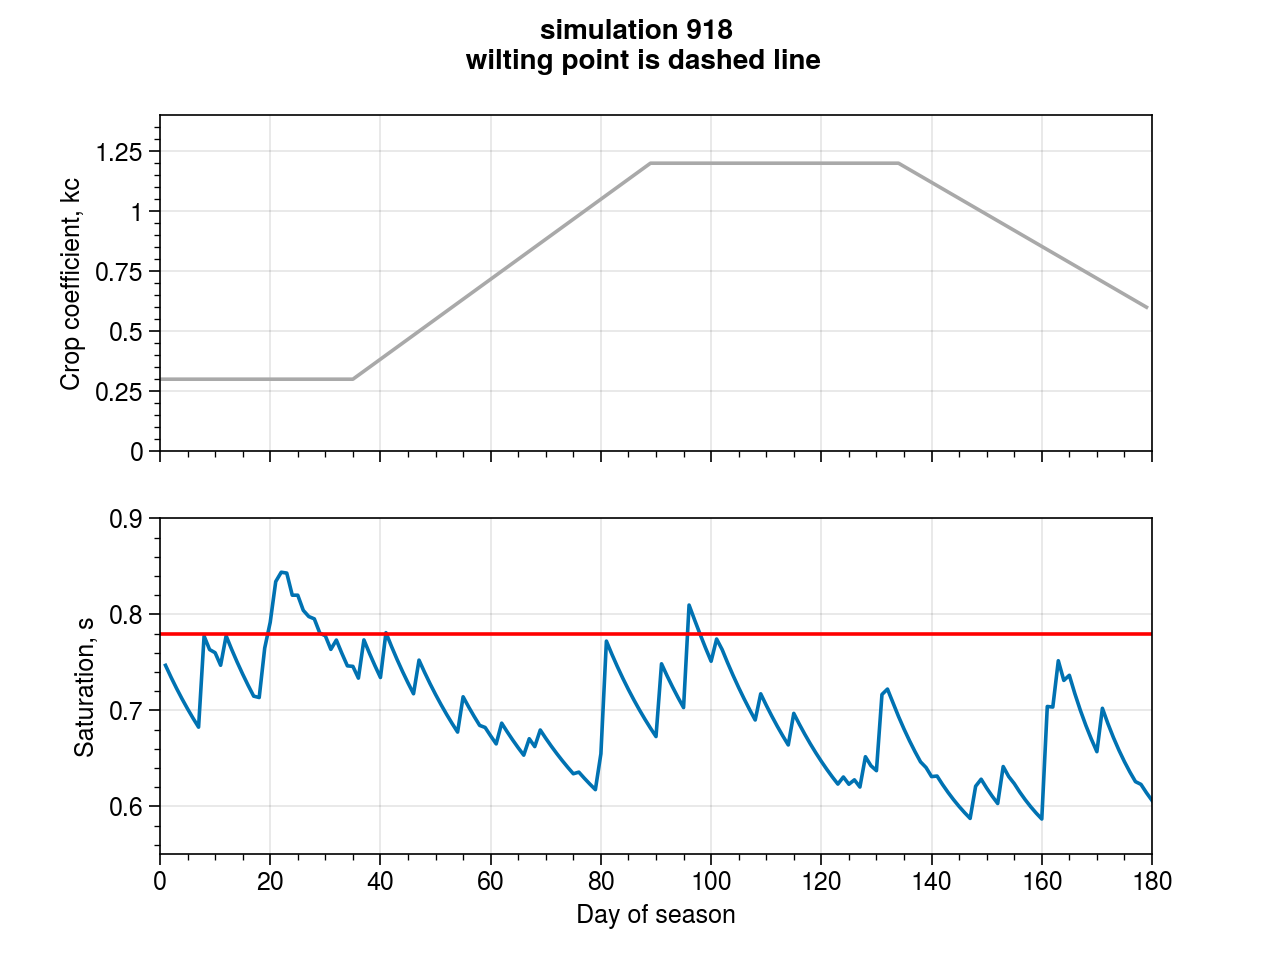

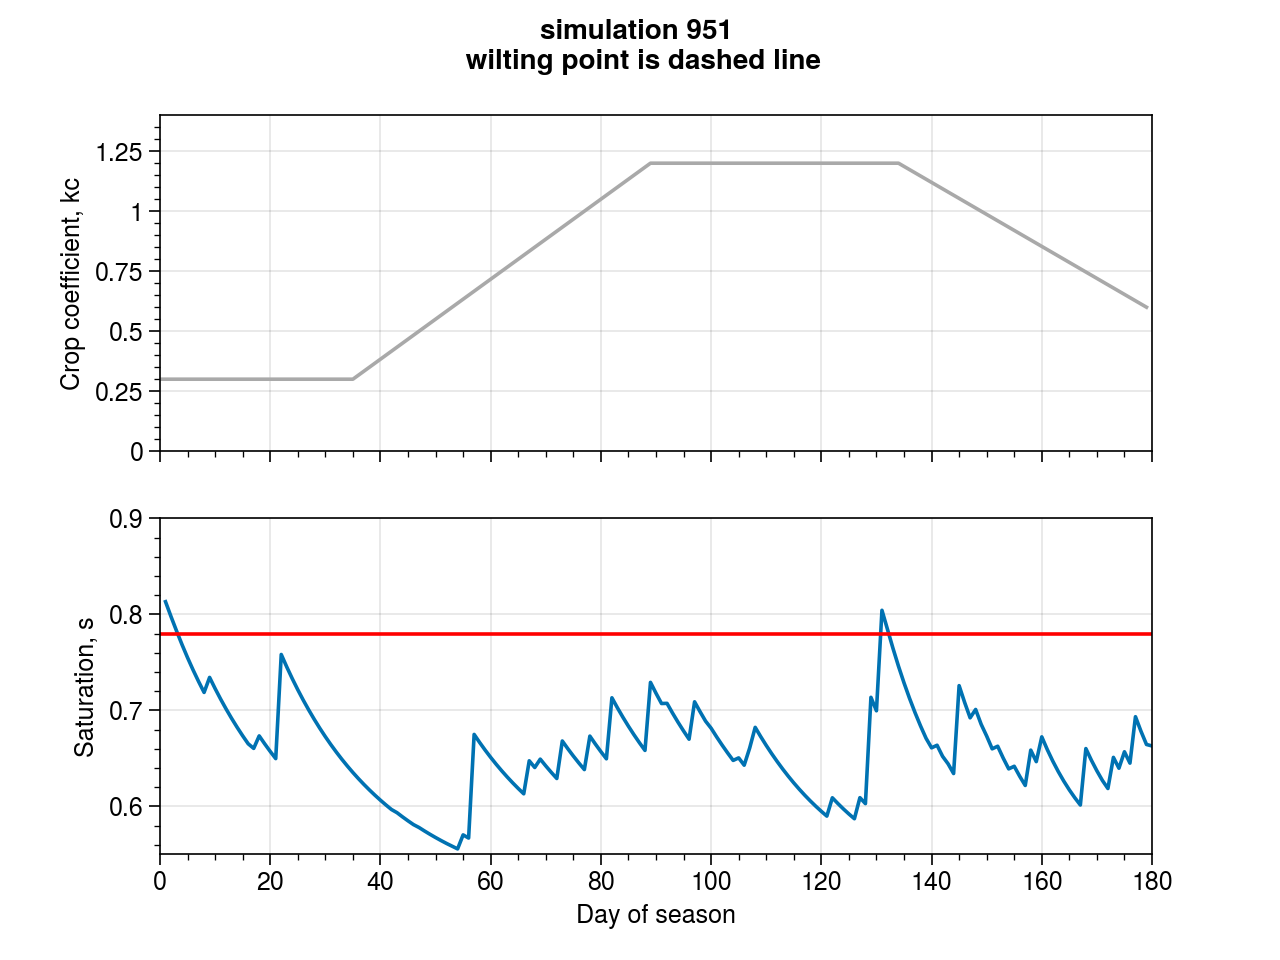

In [15]:
for i in bimod_sat.columns:
    
    fig, ax = plt.subplots(nrows=2, sharex = True) #constrained_layout=True
    bimod_sat[i].plot() # color='blue'
    #plt.title('wilting point is dashed line')
    plt.ylabel('Saturation, s')
    plt.xlabel('Day of season')
    plt.axhline(y=crop.s_star, color='r', linestyle='-')
    plt.axhline(y=crop.sw, color='r', linestyle='--')
    ax[1].set_ylim([0.55, 0.9])
    
    #secondary axis was too messy so adding secondary plot
    fig.suptitle('simulation %d \n wilting point is dashed line'%i)
    ax[0].plot(kc, color='darkgray') # , marker='o'
    ax[0].set_ylim([0, 1.4]) #xlim=(0, 0.4), 
    ax[0].set_ylabel('Crop coefficient, kc') # r'p($\bar{s}$)'
    
    # TODO: Would be good to annotate this plot with the total yield from the season
    #plt.savefig(str(i)+'_saturation.png')

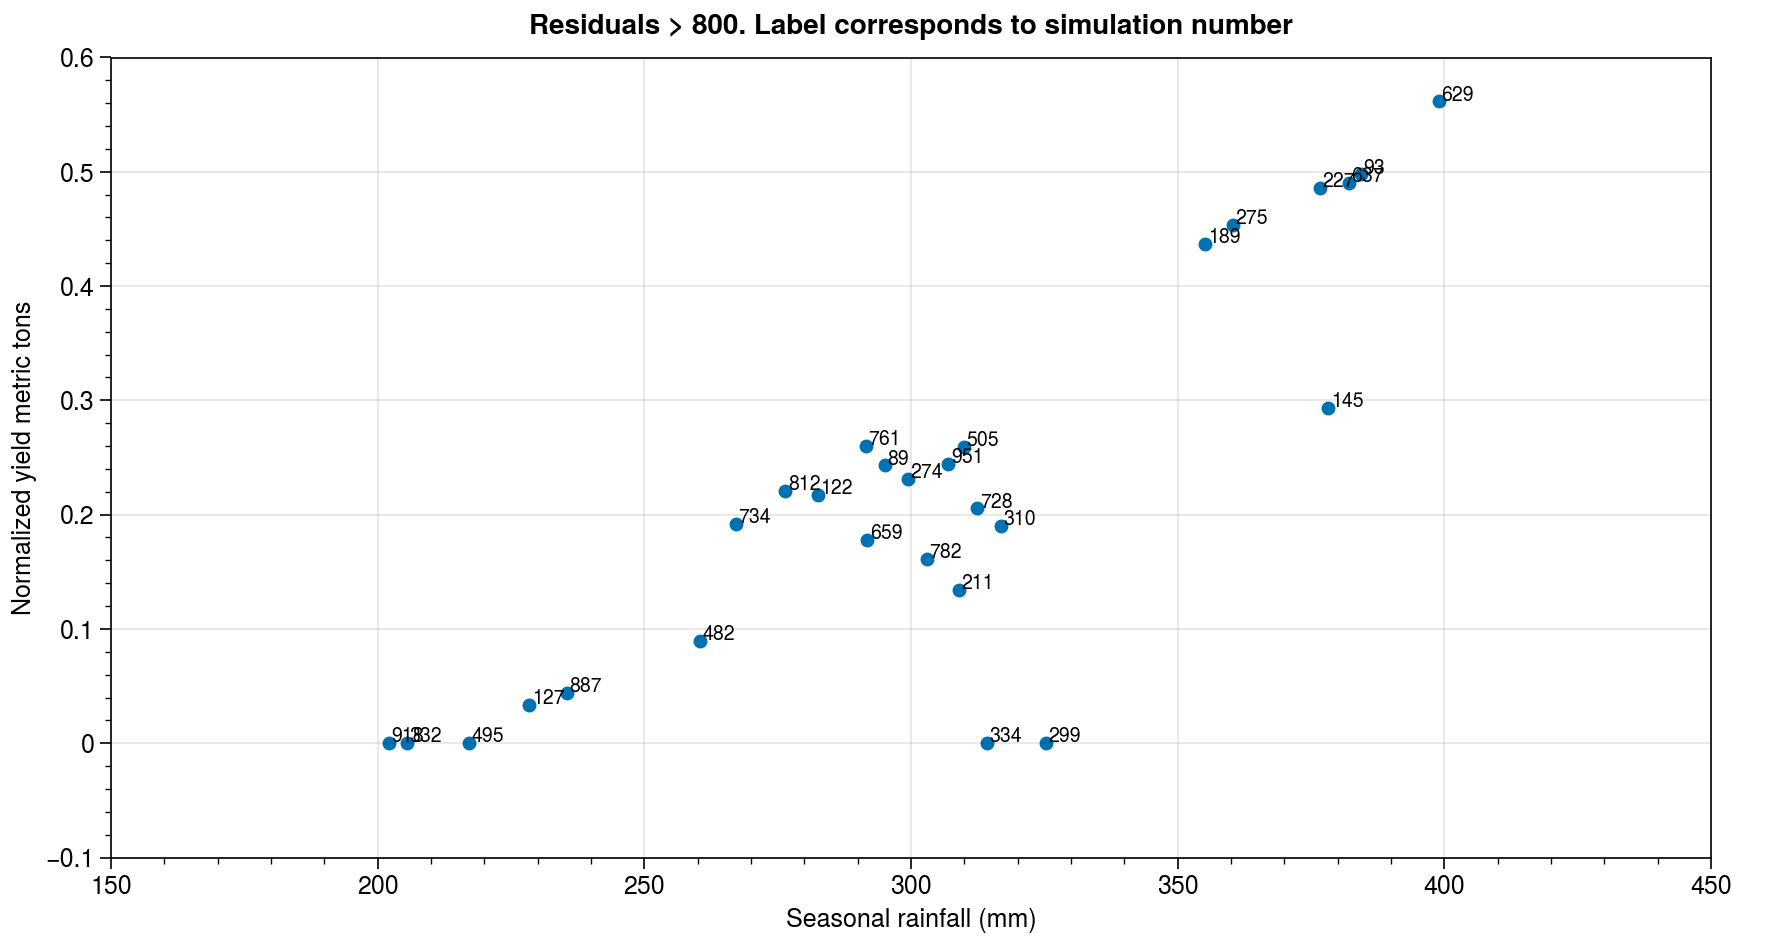

In [16]:
# Plot these points

len(x[x.index.isin(bimod.index)])

xdat=x[x.index.isin(bimod.index)]
ydat=y[y.index.isin(bimod.index)]

ydat_max_yield = ydat/max(df.Yield)

fig, ax = plot.subplots(axwidth=8, aspect=2) #width=6
ax.scatter(x[x.index.isin(bimod.index)], ydat_max_yield, lw=2) # color='blue'
ax.format(suptitle='Residuals > 800. Label corresponds to simulation number', xlabel='Seasonal rainfall (mm)', ylabel='Normalized yield metric tons')
ax.format(ylim=(-0.1, 0.6))
ax.format(xlim=(150, 450))

# need to run the columns below first
enumerate(colnames)
colnames

for i in colnames:
    ax.annotate(i, (xdat[i]+0.45, ydat_max_yield[i]+0.001), fontsize=7)

In [17]:
# these are the indixes of the bimodal simulations
good = bimod.index
df1 = df[df.index.isin(good)]
df2 = df[~df.index.isin(good)]

print(len(df))
print(len(df1))
print(len(df2))

1000
29
971


Text(0.5, 0, 'Rainfall (mm)')

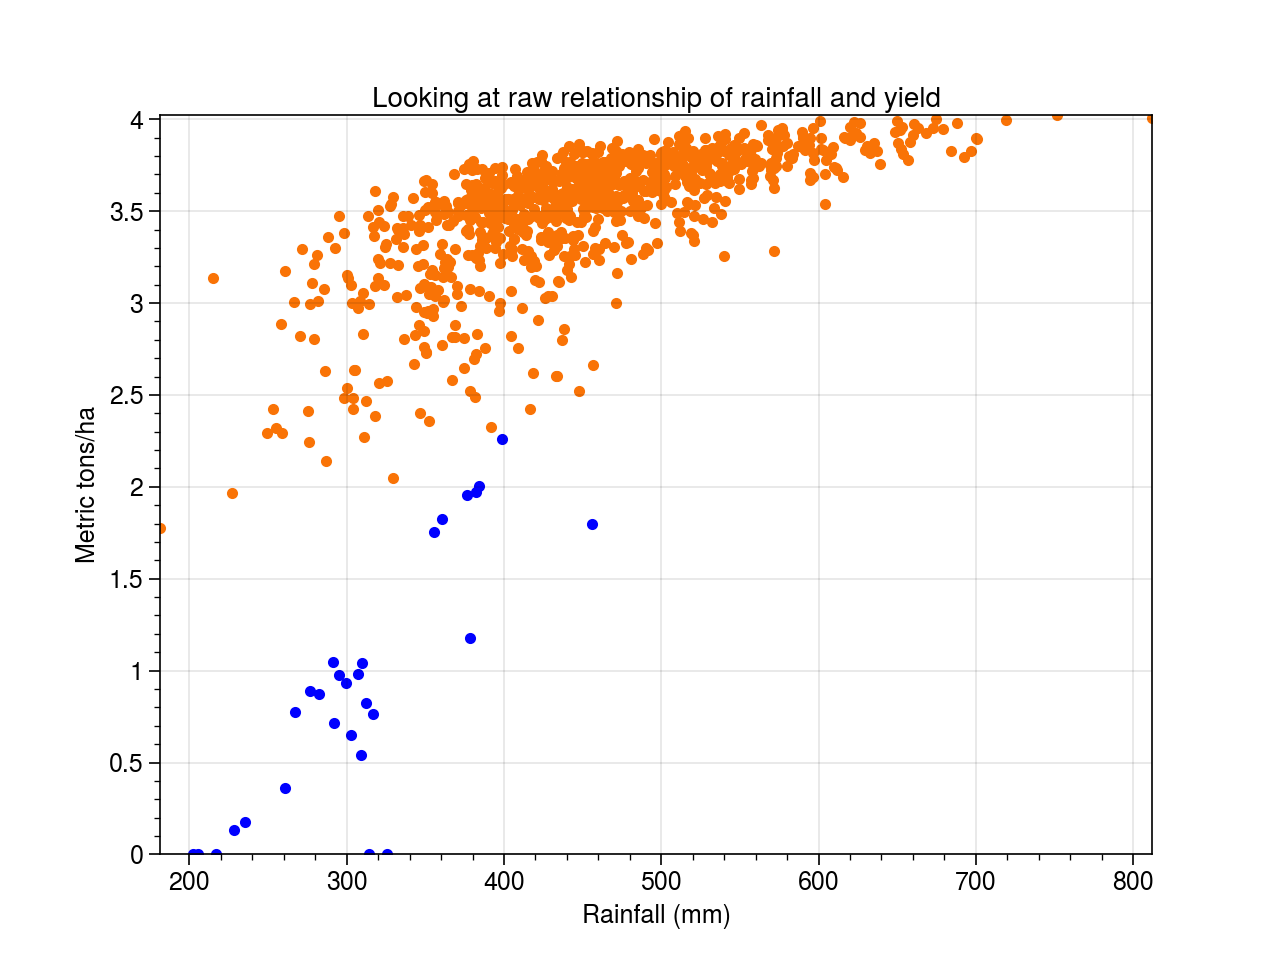

In [18]:
# Plot all the points with these residual simulations highlighted

plt.scatter(df1.RF, df1.Yield/1000, color='blue')
plt.scatter(df2.RF, df2.Yield/1000, color='orange')
#plt.ylim(-.10,1.10)
#plt.xlim(100,900)
plt.title('Looking at raw relationship of rainfall and yield')
plt.ylabel('Metric tons/ha')
plt.xlabel('Rainfall (mm)')

## Q4. What are the initial values of s when the model starts? <a id='s02'></a>

Maybe the crop is not consistently stressed for all of the model runs

count    29.000000
mean      0.628859
std       0.042312
min       0.548977
25%       0.590630
50%       0.633357
75%       0.659233
max       0.689878
Name: 0, dtype: float64
count    971.000000
mean       0.697502
std        0.066826
min        0.529309
25%        0.648262
50%        0.696527
75%        0.744581
max        0.864435
Name: 0, dtype: float64


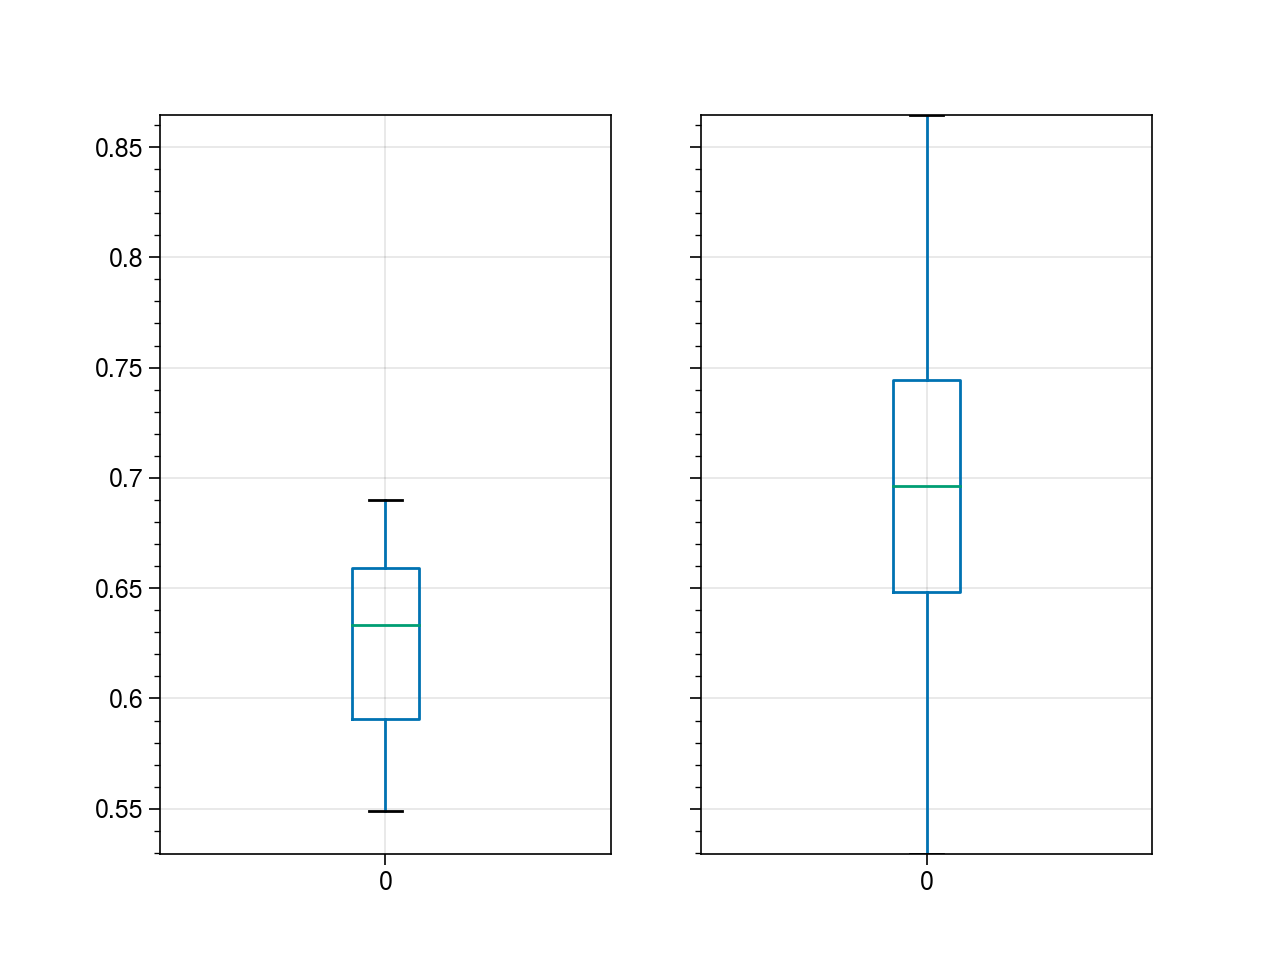

In [19]:
s0 = pd.DataFrame(list(zip(*sat))[0]).reset_index()

# check out some summary statistics
s0[0].describe()

# now subdivide by two categories
d1 = s0[s0.index.isin(good)]
d2 = s0[~s0.index.isin(good)]

# summary stats again
print(d1[0].describe())
print(d2[0].describe())

# this is maybe a little more promising
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
d1[0].plot.box(ax=ax[0]) 
d2[0].plot.box(ax=ax[1]) 

In [20]:
# st0 = pd.DataFrame(list(zip(*stress))[0]).reset_index()

# # check out some summary statistics
# st0[0].describe()

# # now subdivide by two categories
# d1 = st0[st0.index.isin(good)]
# d2 = st0[~st0.index.isin(good)]

# # summary stats again
# print(d1[0].describe())
# print(d2[0].describe())

# # not a clear difference here
# fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
# d1[0].plot.box(ax=ax[0]) 
# d2[0].plot.box(ax=ax[1]) 

### Prognosis so far...

Jacked up simulations to 10,000 and resulted in image below. This was using the residuals below -570 or so. Basically used the histogram to find a split and then took those simulations to plot in yellow. 
- I think it has to do with different lines or trajectories that we need to figure out what it's related to..
- There's something about these simulations and it doesn't have to do with whether a simulation crosses s_star, because as we saw before some of the simulations that dn't cross s-star still result in higher yields.
- There are distinct trajectory lines, which is confirmed in this plot of static stress against dynamic stress

### In terms of the initial values of s0..
- There are differences in s0 between trajectories. 
- Do we want to standardize this by cranking up the number of days before the model starts
- Or use some other planting metric like stress is below 0.9 or something
- Decision: stick with 60 days after model starts to make the initial values of s more similar.
- possible TODO: Could write up a little function to have the model start once there is a 20 + 25mm event. This is a little more complicated, especially in scenarios where this doesn't happen. Does the model then never start?
From [Senay (2004)](https://iridl.ldeo.columbia.edu/documentation/usgs/adds/wrsi/WRSI_readme.pdf): `The onset-of-rains (SOS) is determined using a threshold amount and distribution of rainfall received in three consecutive dekads. SOS is established when there is at least 25 mm of rainfall in an initial dekad followed by a total of at least 20 mm of rainfall in the following two consecutive dekads. 2) on the second method SOS is determined when the ratio between rainfall and PET in a given dekad is greater than 0.5 (Hare and Oglallo, 1993; Mersha, 2001)). The two methods generally provide similar results for most areas. However, the first method tends to be too strict in semi-arid areas, preventing the establishment of an SOS in some years. While the first method is used for monitoring activities using observed rainfall, the CHARM-WRSI is generated using the second method.`

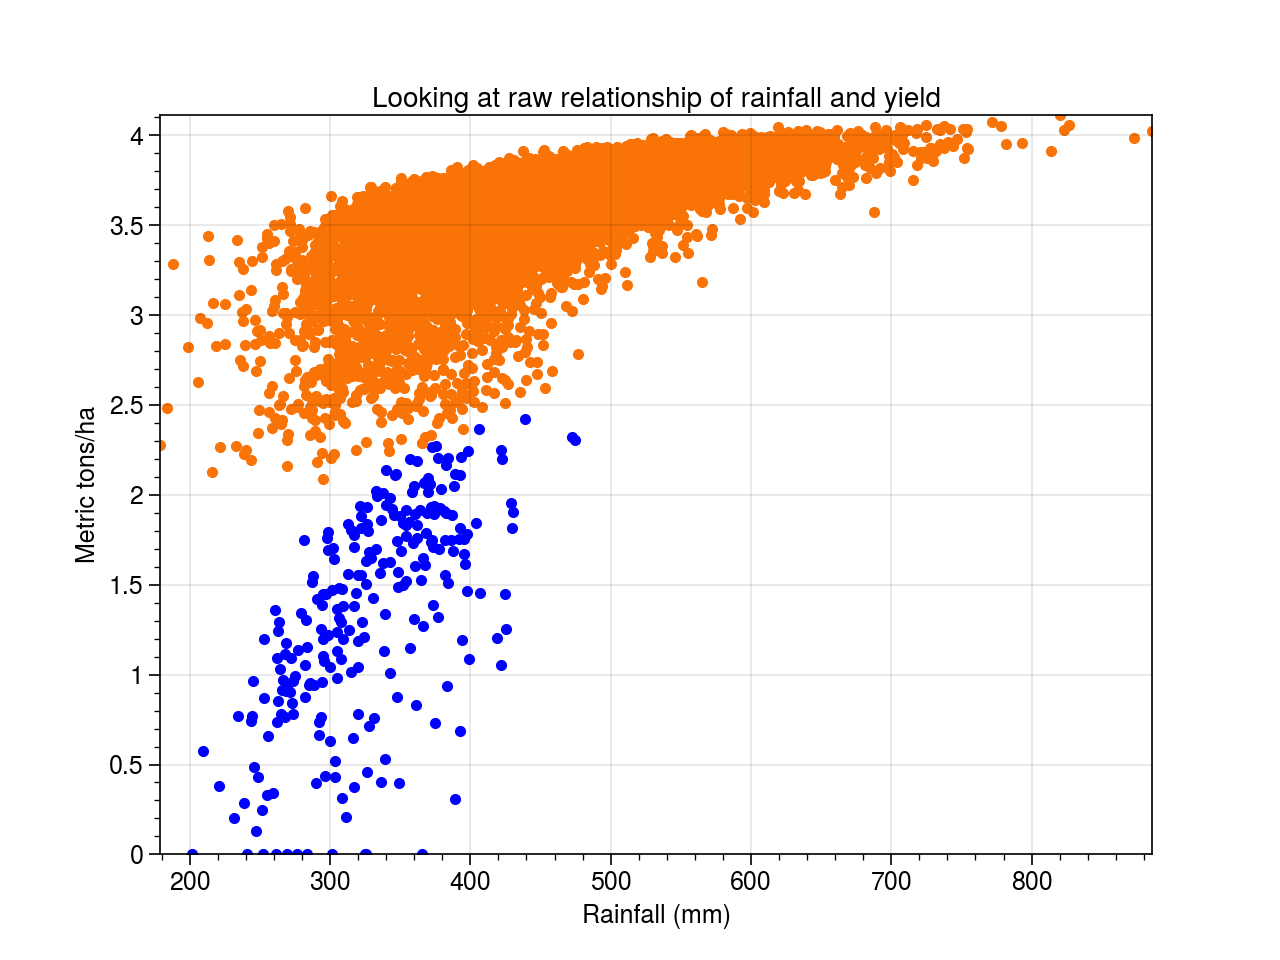

Text(0.5, 0, 'Static stress')

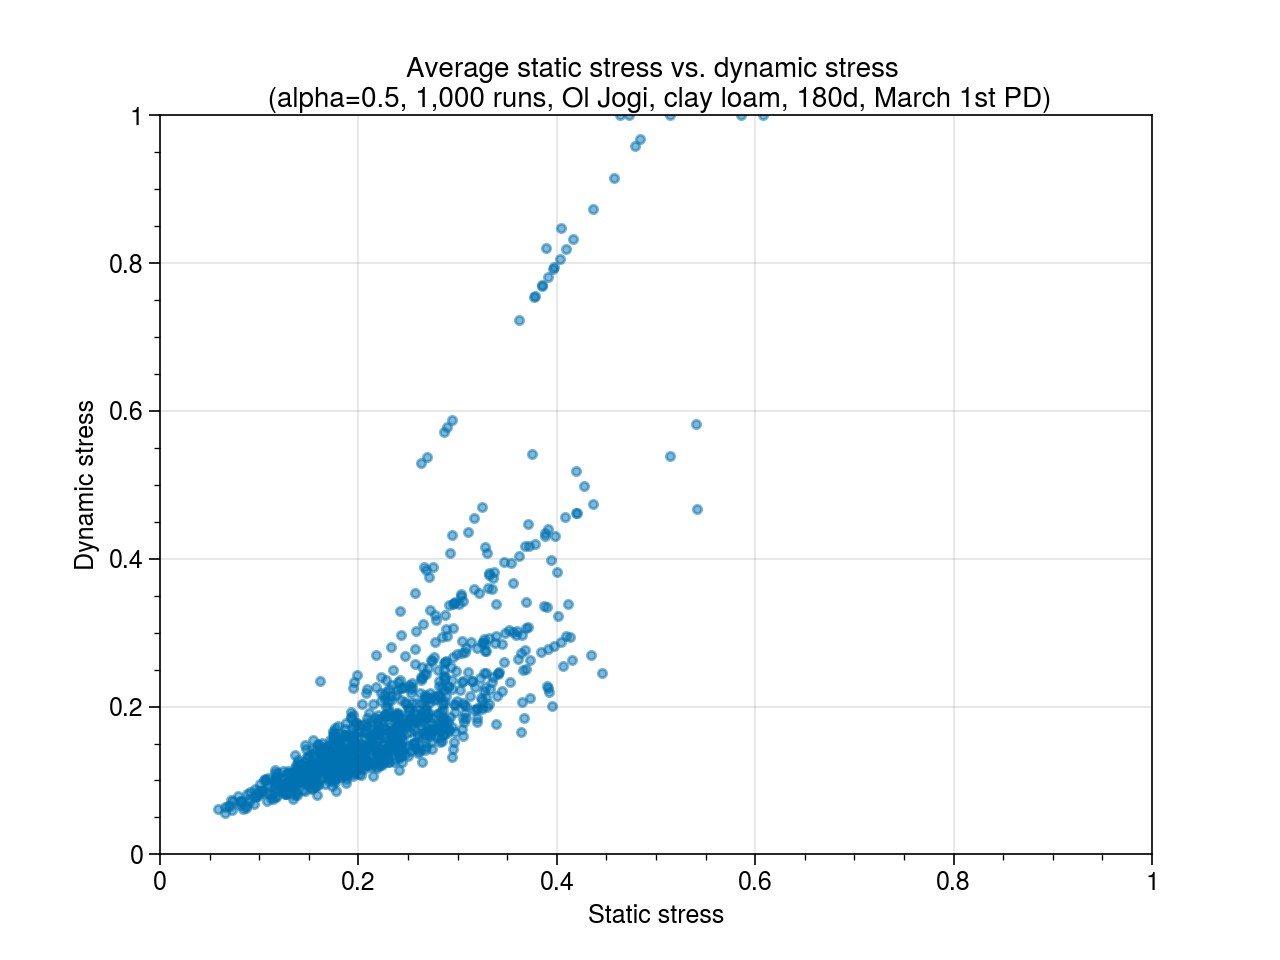

In [21]:
plt.scatter(df.AvgStress2, df.DynamicStress, alpha=0.5)
plt.ylim(0,1)
plt.xlim(0,1)
plt.title('Average static stress vs. dynamic stress \n (alpha=0.5, 1,000 runs, Ol Jogi, clay loam, 180d, March 1st PD)')
plt.ylabel('Dynamic stress')
plt.xlabel('Static stress')

## Q5. Summary statistics of the orange and blue simulations <a id='stats'></a>

Aha. In the blue points, we see that the dynamic stress behaves as a normal distribution. Is there something happening in the dynamic stress of the orange points that's causing them to behave in a nonlinear-ish fashion?

In the equation for dynamic water stress its either the n_star or r that is causing it to go linear.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8dc1fa2b50>,
      dtype=object)

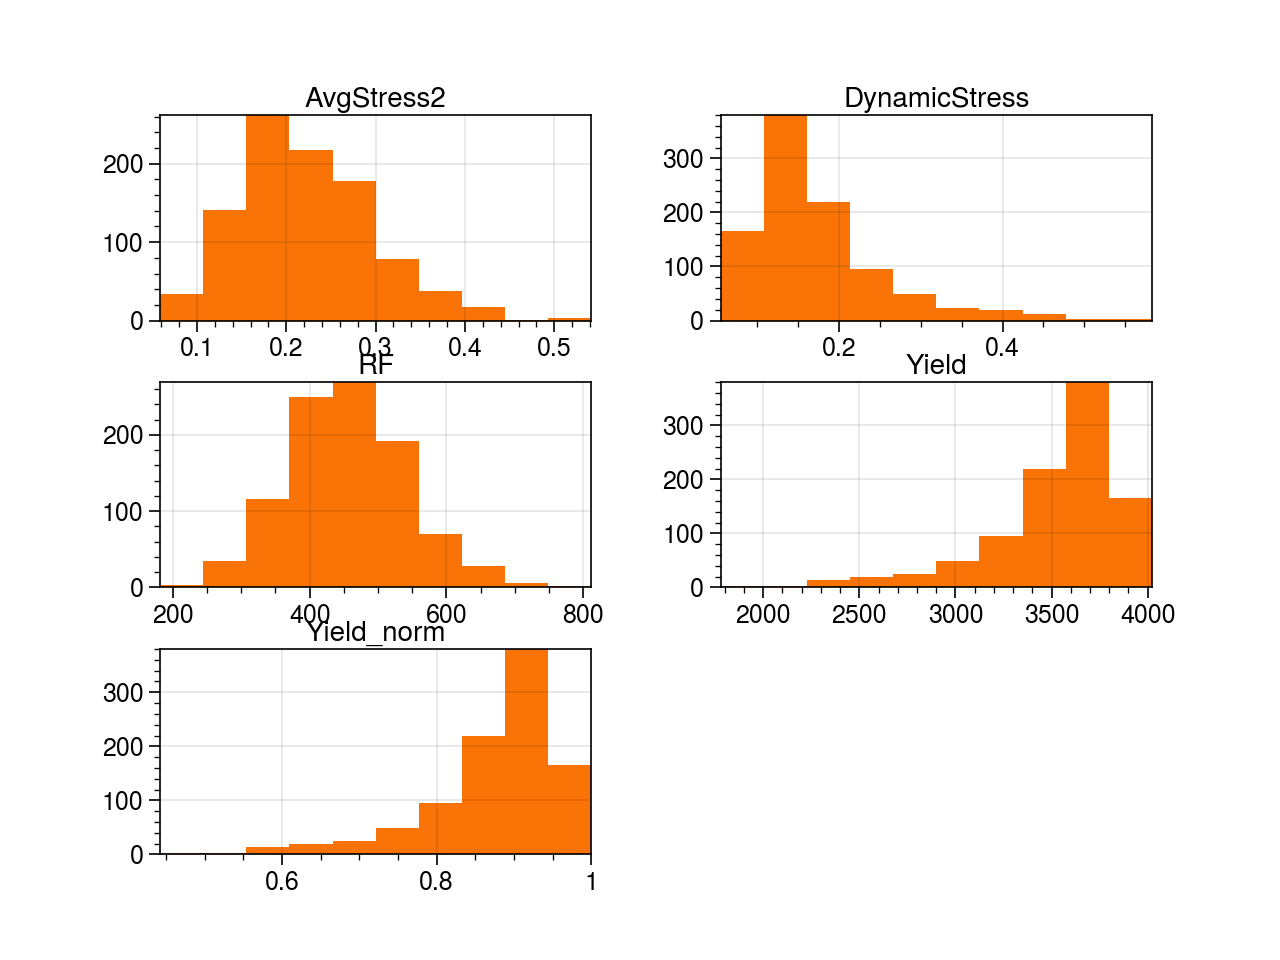

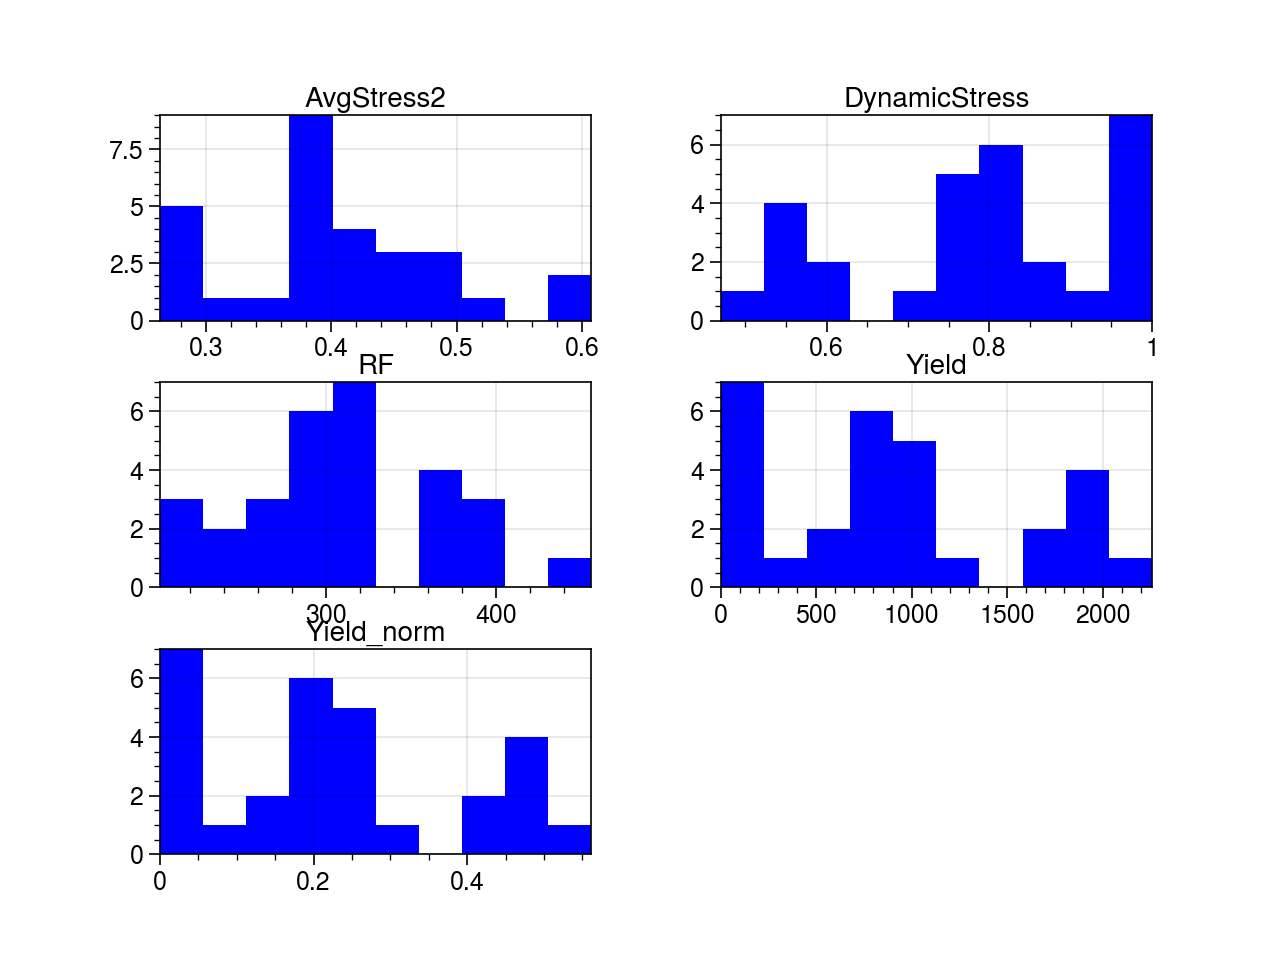

In [22]:
df2.hist(color='orange')
df1.hist(color='blue')

## Q6. Select intervals of low rainfall with different yields <a id='rf'></a>

Why are there vastly different yields for low rainfall simulations?

In [23]:
# select a few examples where rainfall is between 250 and 350 mm but yield differs
# then select rows with five highest yields and five lowest yields

df = df[(df['RF'] >= 250) & (df['RF'] <= 300)].sort_values(by=['Yield'])
print(len(df))

# Select the indices of head(5) and tail(5)
# Note these are zero-indexed so will need to add 1. 
h = df.head(5).index.array
t = df.tail(5).index.array

# the length of this should be 10
h_ = df[df.index.isin(h)]
t_ = df[df.index.isin(t)]

df_ = pd.concat([h_,t_])

print(len(df_) == 10) # this should be true

# change to t/ha
df['Yield2'] = df['Yield']/1000

33
True


In [24]:
# use this to get the time series
# convert list of lists into pandas dataframe
df_sat = pd.DataFrame(sat).reset_index().drop(['index'], axis=1); df_sat
bimod_sat = df_sat[df_sat.index.isin(df_.index)]
len(bimod_sat) == len(df_) # True! great!
bimod_sat = bimod_sat.reset_index()
colnames = bimod_sat['index'].tolist()
bimod_sat = bimod_sat.T 
bimod_sat.columns = colnames
bimod_sat = bimod_sat.drop(['index'],axis=0)
# currently index goes from 60 to 180, which is day of simulation, but I want day of year
bimod_sat.index = bimod_sat.index - 59
bimod_sat


122       153       237       256       257       482       659  \
1    0.614208  0.755030  0.723658  0.753561  0.736588  0.663565  0.689878   
2    0.608873  0.773441  0.712642  0.740866  0.724852  0.655763  0.680696   
3    0.699867  0.802544  0.702231  0.774243  0.713769  0.648362  0.672000   
4    0.690149  0.802861  0.692386  0.760358  0.703297  0.641337  0.663761   
5    0.680953  0.820000  0.683070  0.747274  0.693394  0.634667  0.655949   
..        ...       ...       ...       ...       ...       ...       ...   
176  0.561391  0.622919  0.579226  0.593038  0.655517  0.600623  0.568732   
177  0.558125  0.620549  0.574378  0.586959  0.643814  0.621672  0.564816   
178  0.555148  0.612005  0.625830  0.581423  0.633172  0.622595  0.647772   
179  0.552434  0.604229  0.616811  0.576380  0.623491  0.613867  0.641325   
180  0.554634  0.597150  0.608603  0.571785  0.614682  0.605924  0.630908   

          734       812       967  
1    0.686273  0.630412  0.698385  
2    0.677282  0.624285  0.688748  
3    0.668766  0.618460  0.703273  
4    0.660695  0.612919  0.693371  
5    0.653041  0.607646  0.684003  
..        ...       ...       ...  
176  0.630283  0.544203  0.556811  
177  0.620862  0.562143  0.553950  
178  0.612290  0.558810  0.551341  
179  0.604489  0.555773  0.548963  
180  0.597386  0.553003  0.552597  

[180 rows x 10 columns]

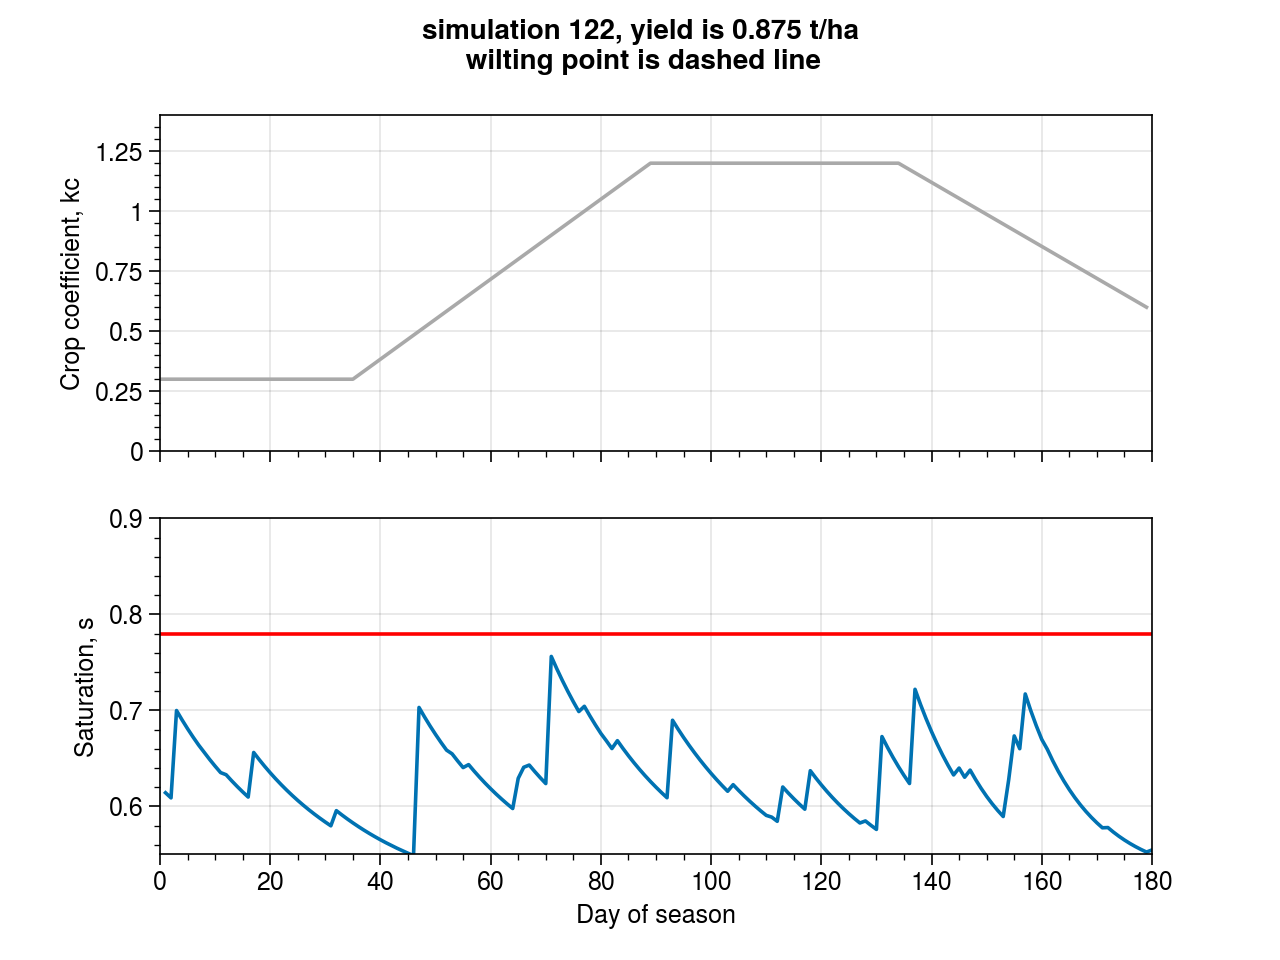

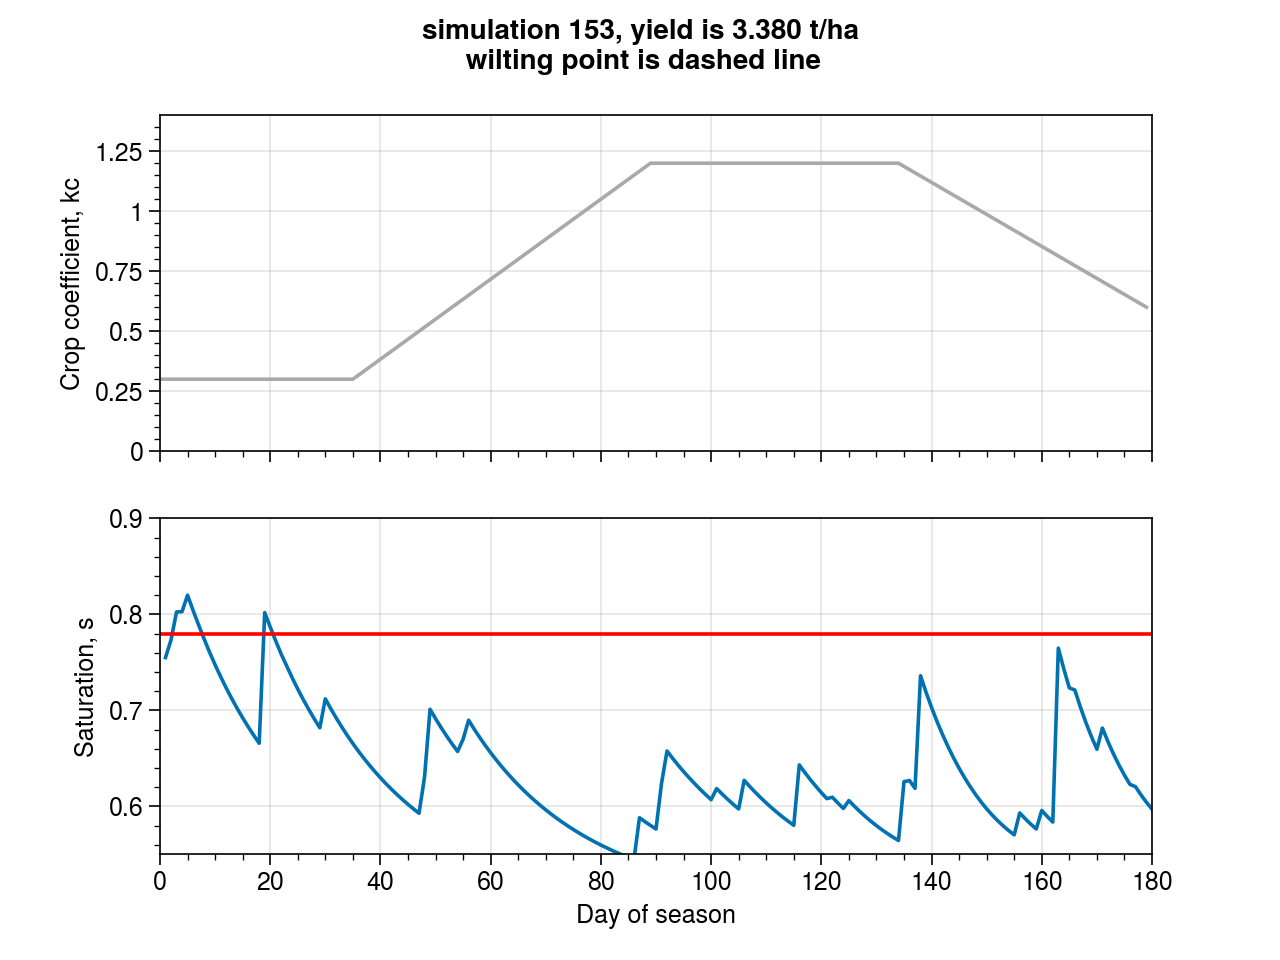

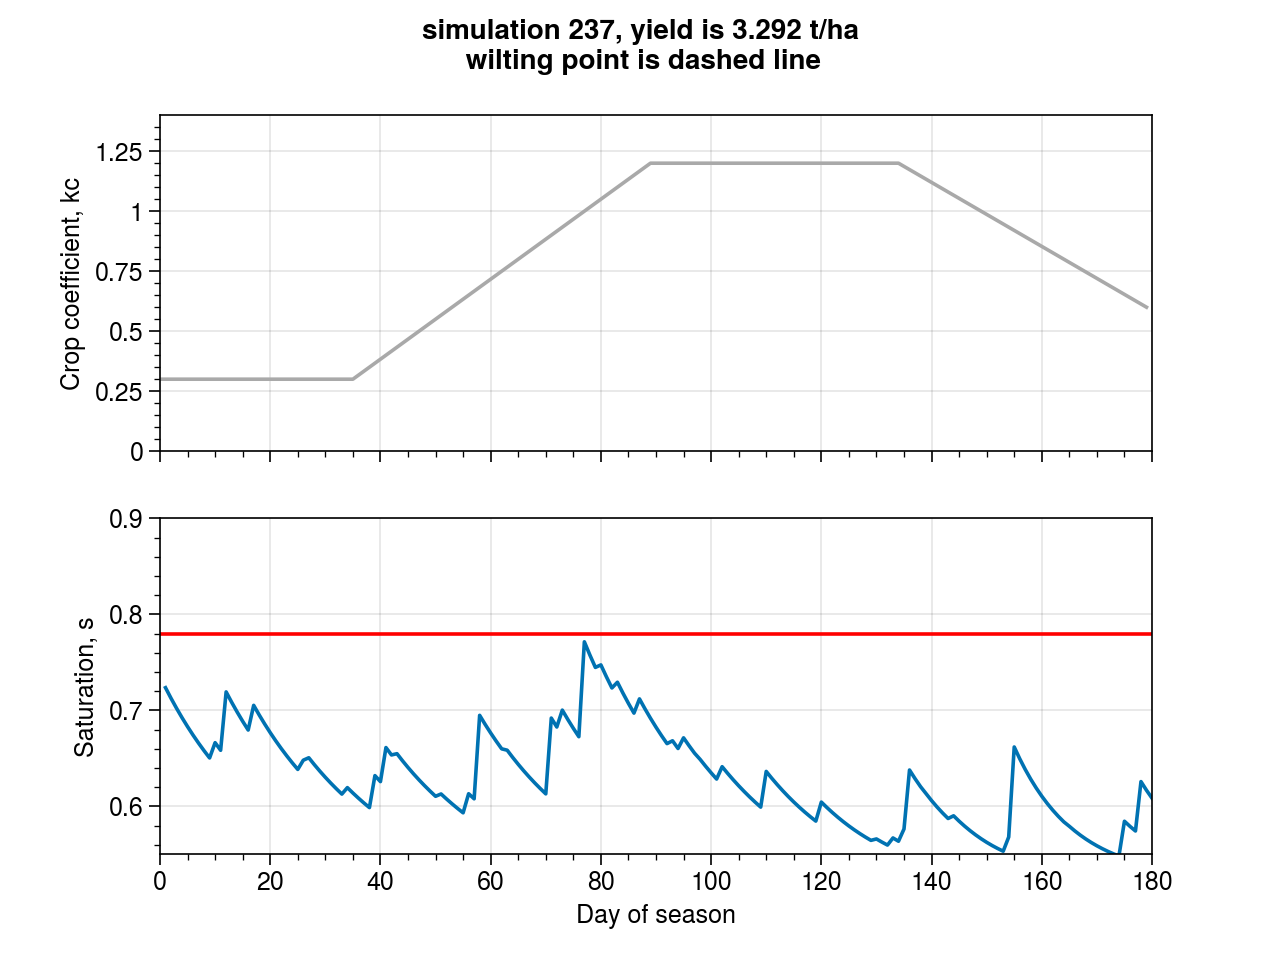

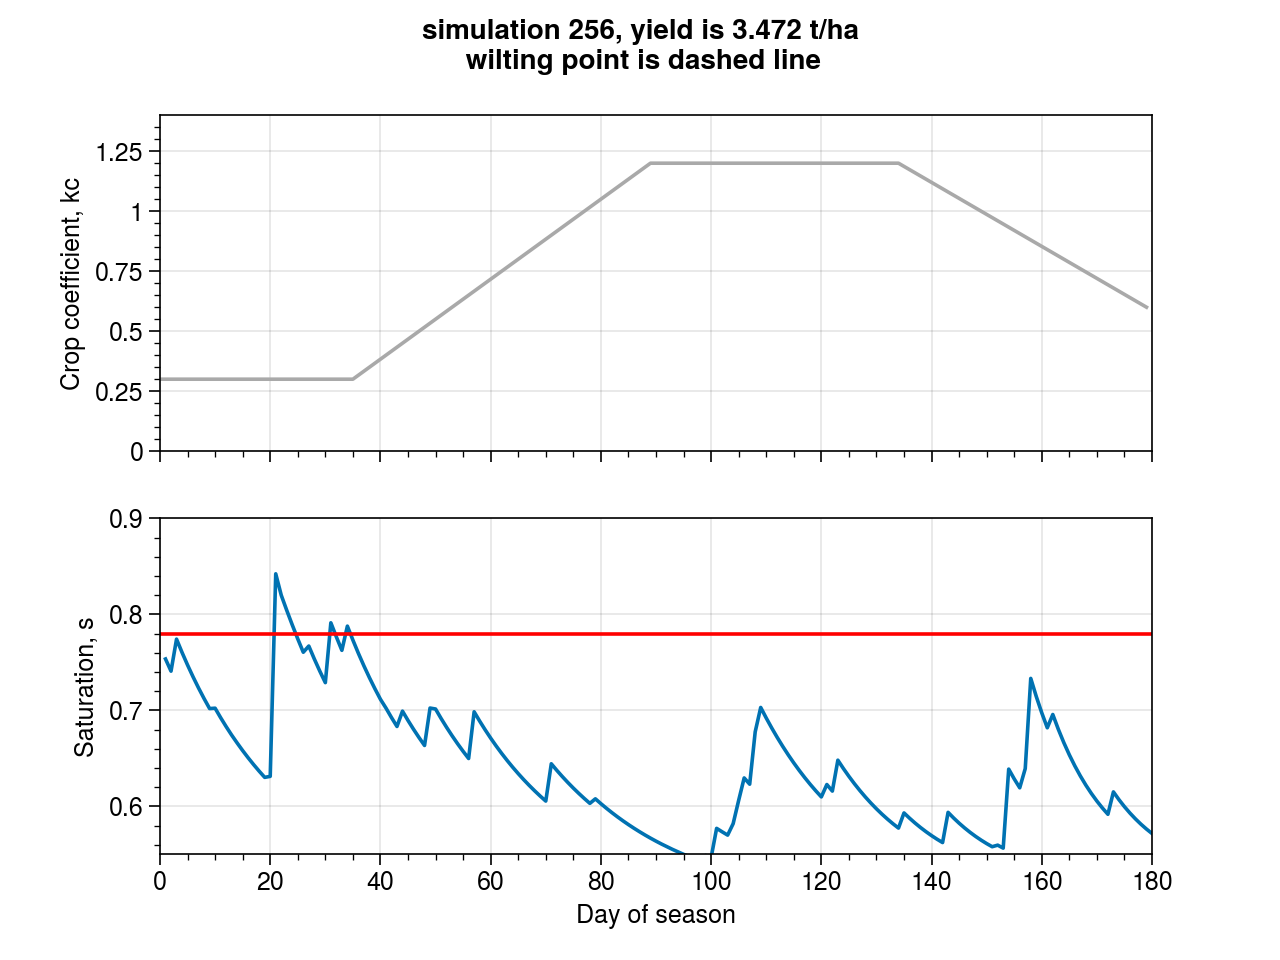

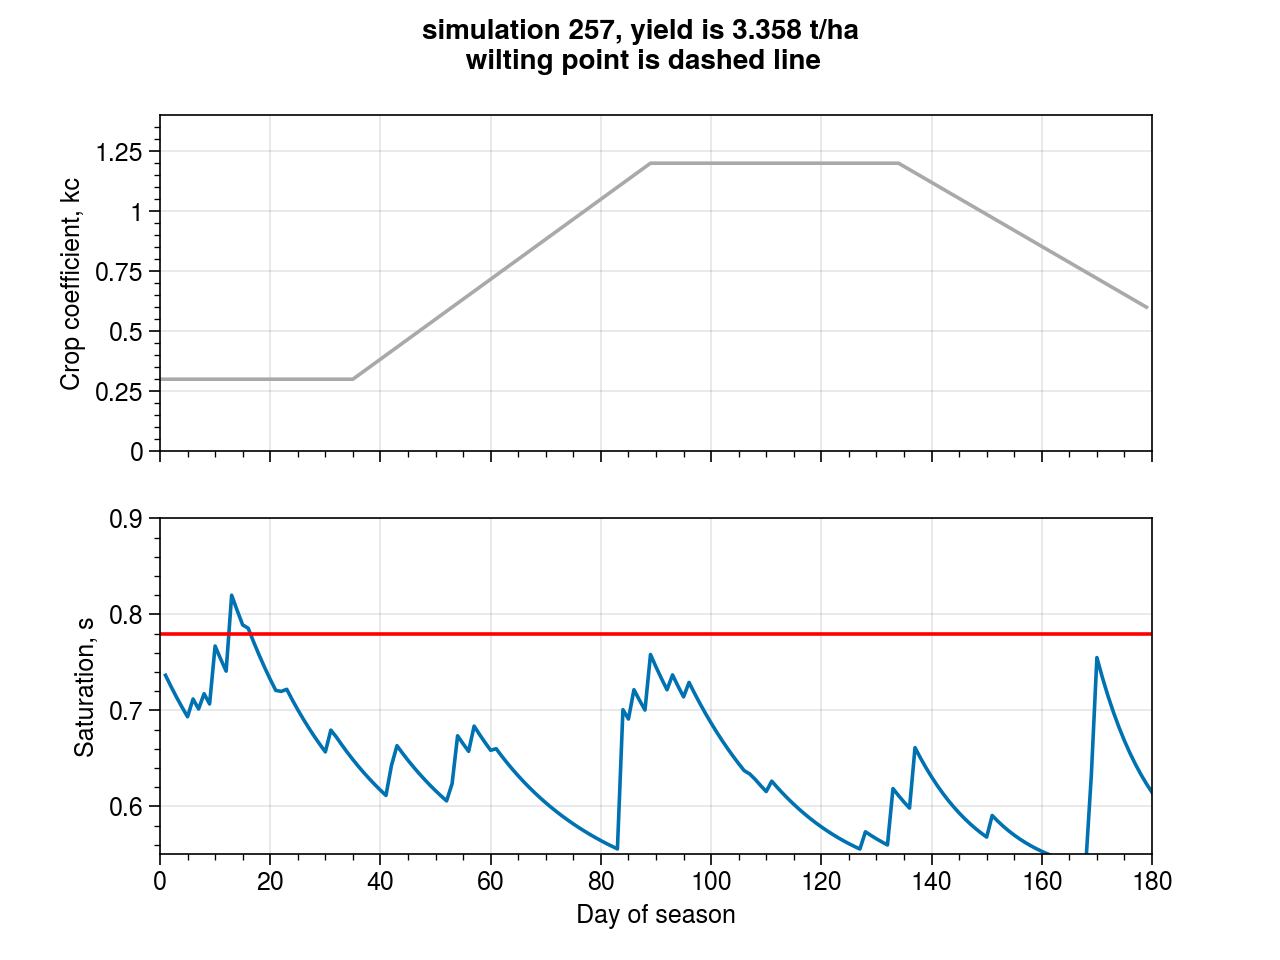

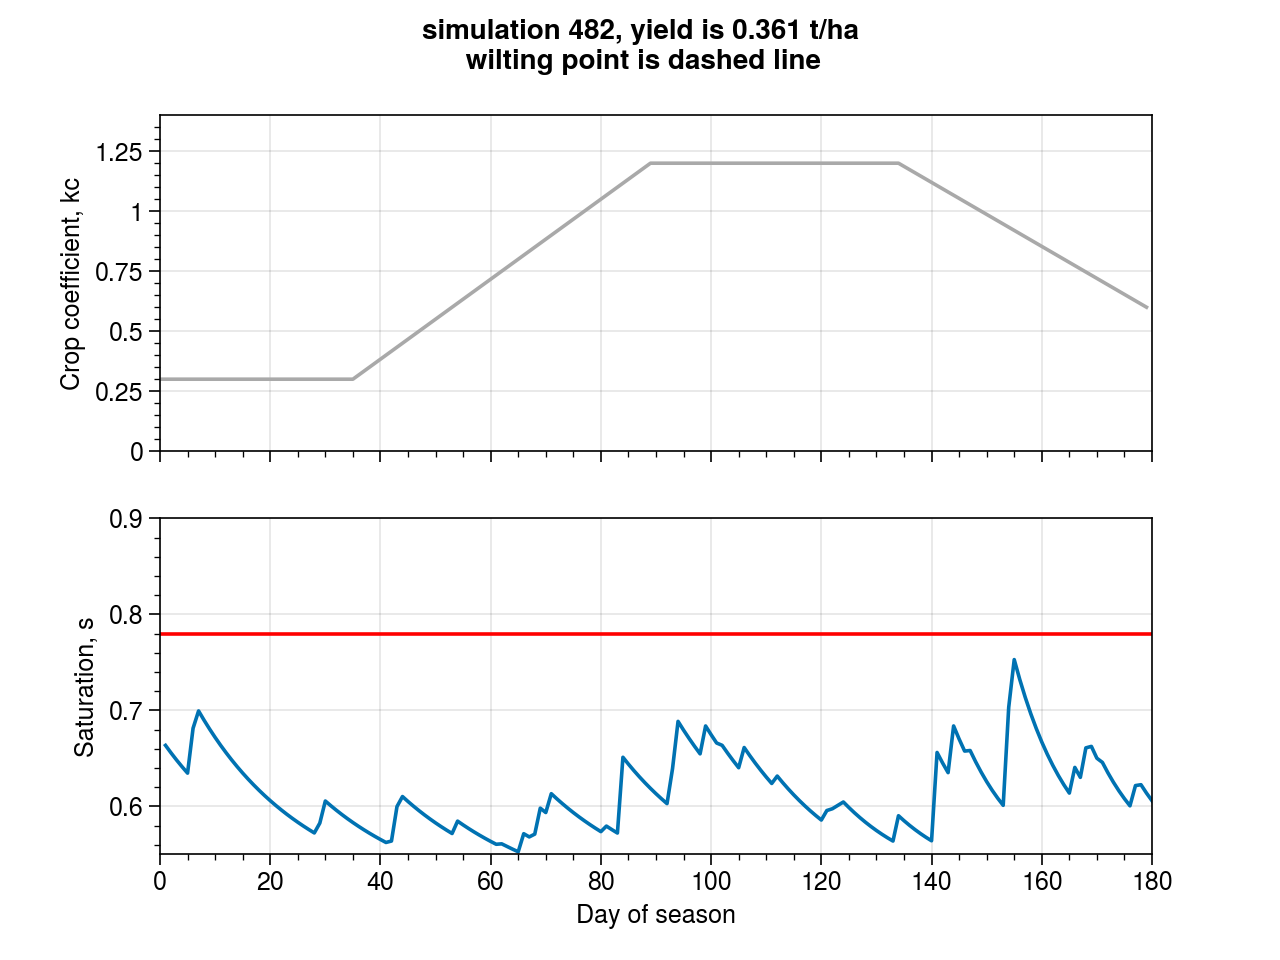

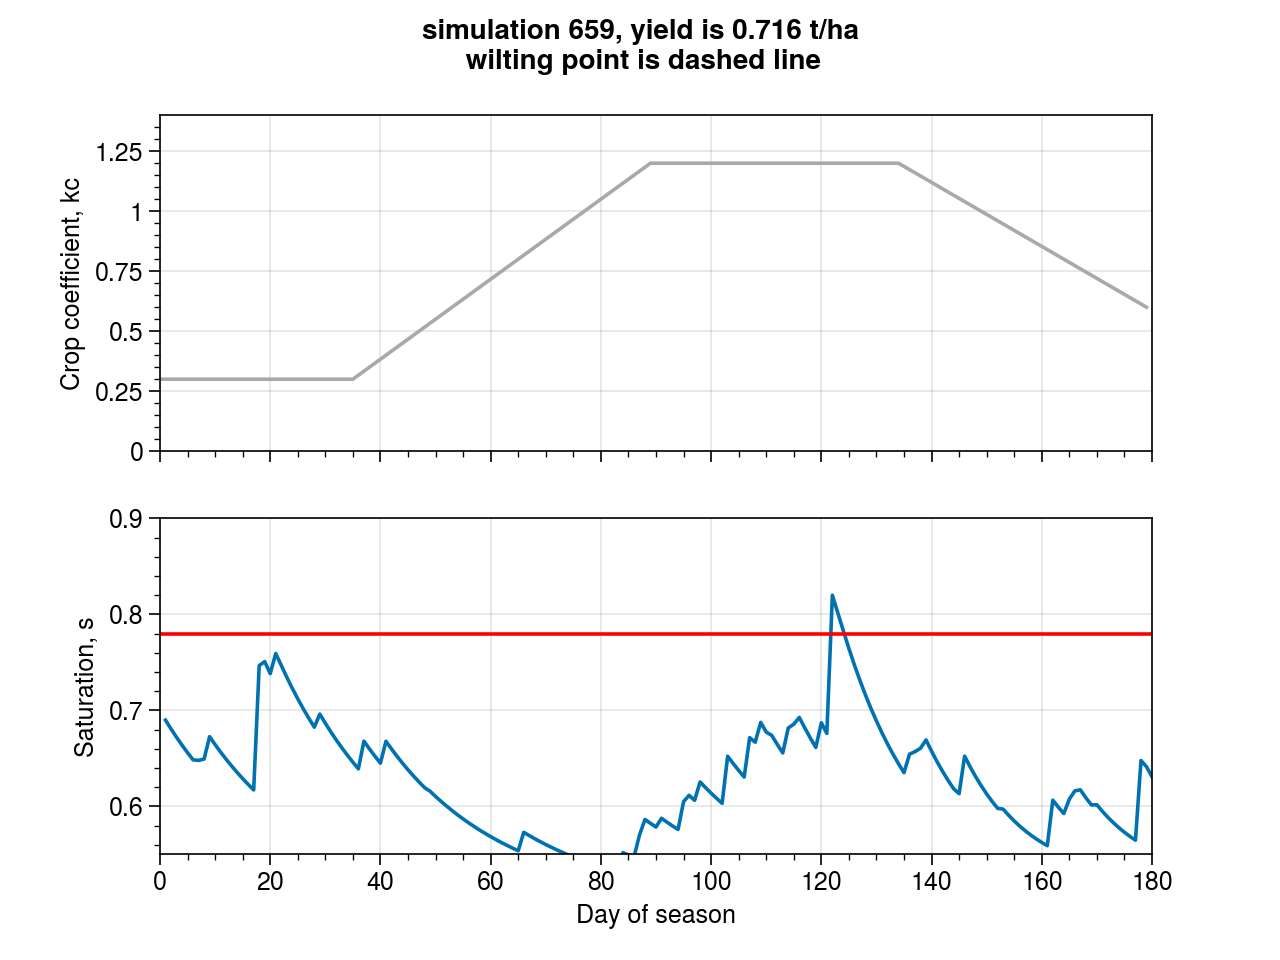

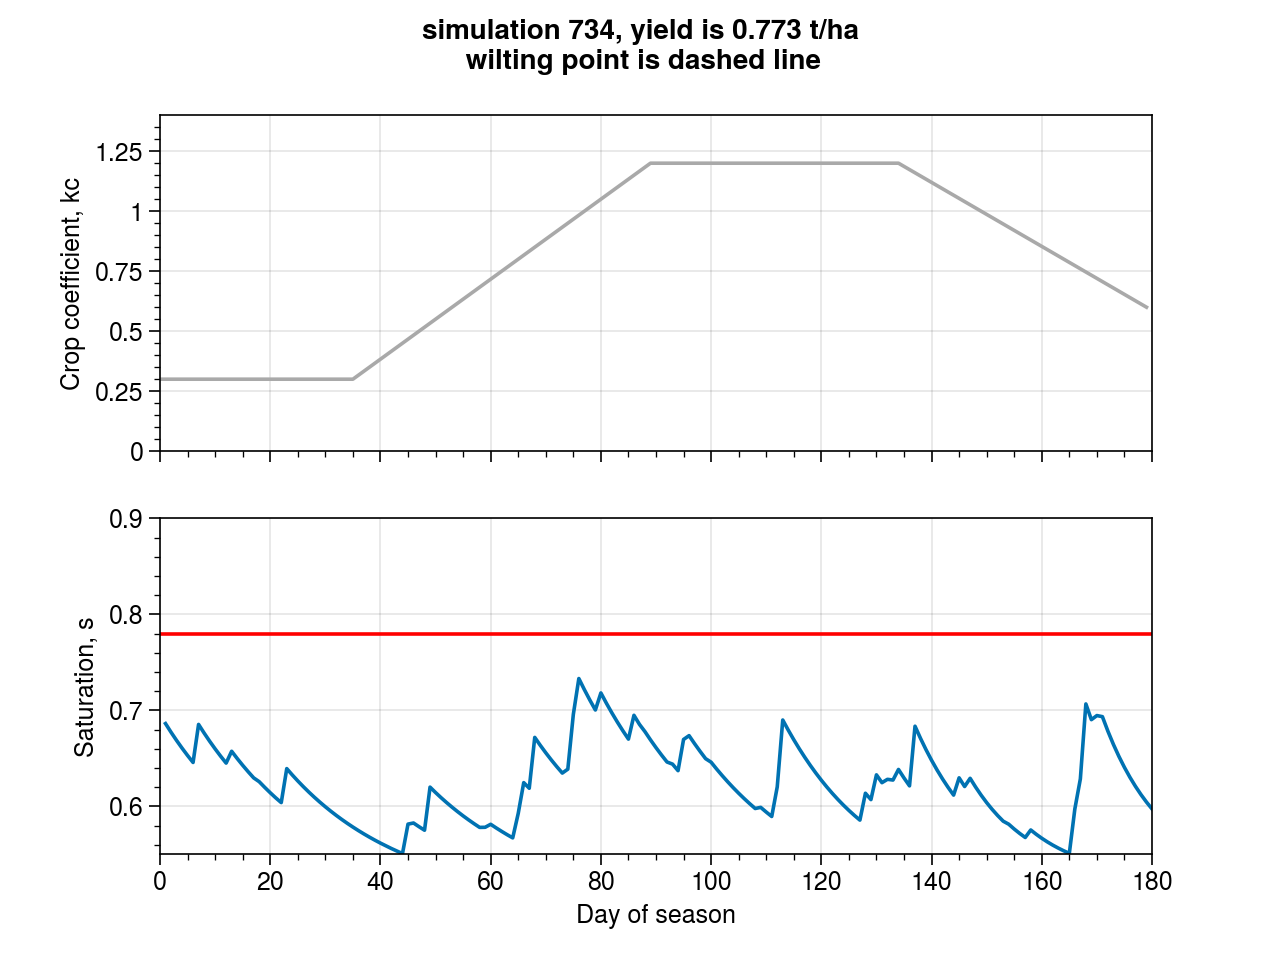

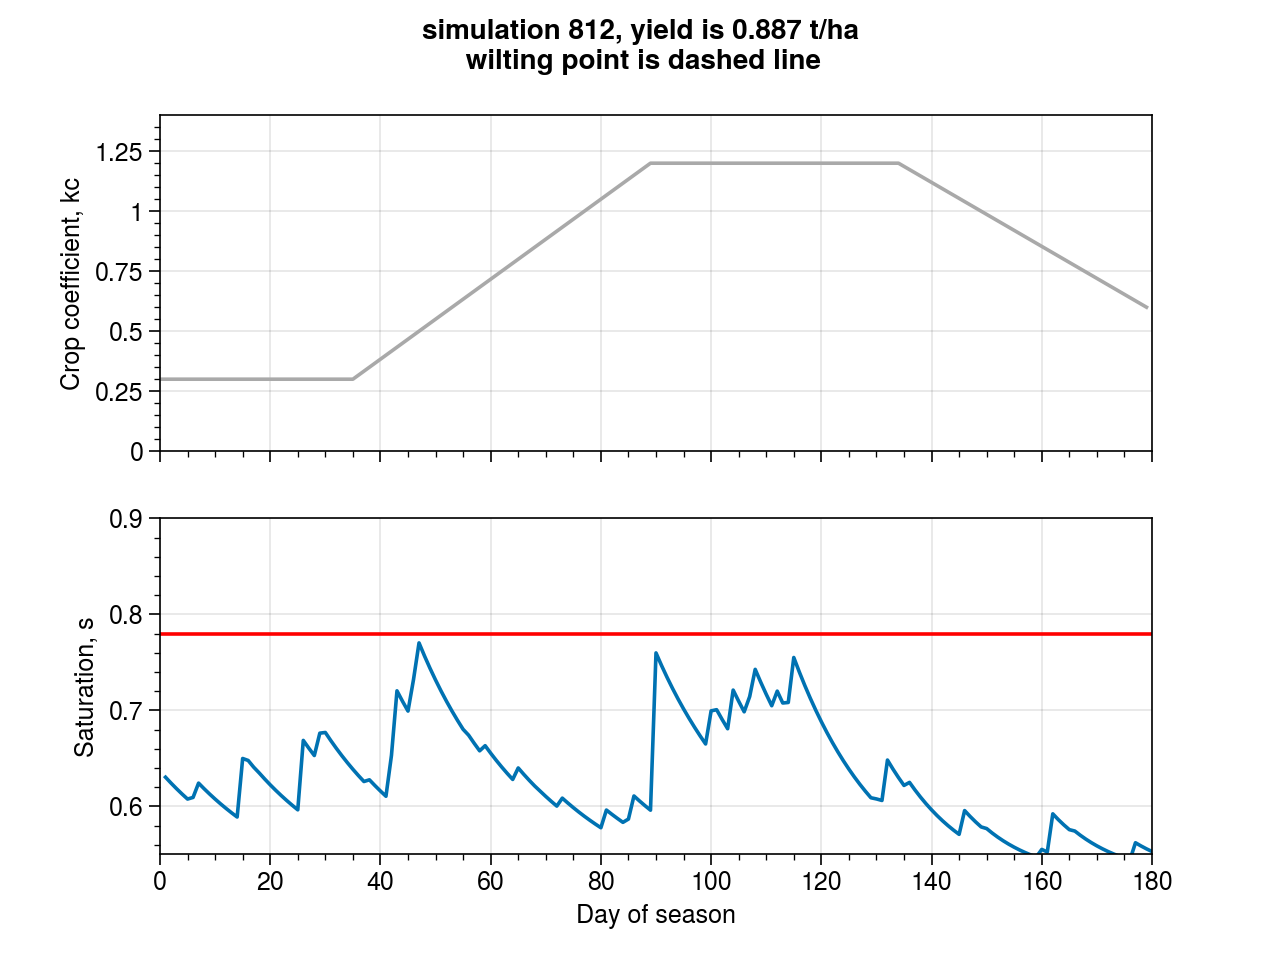

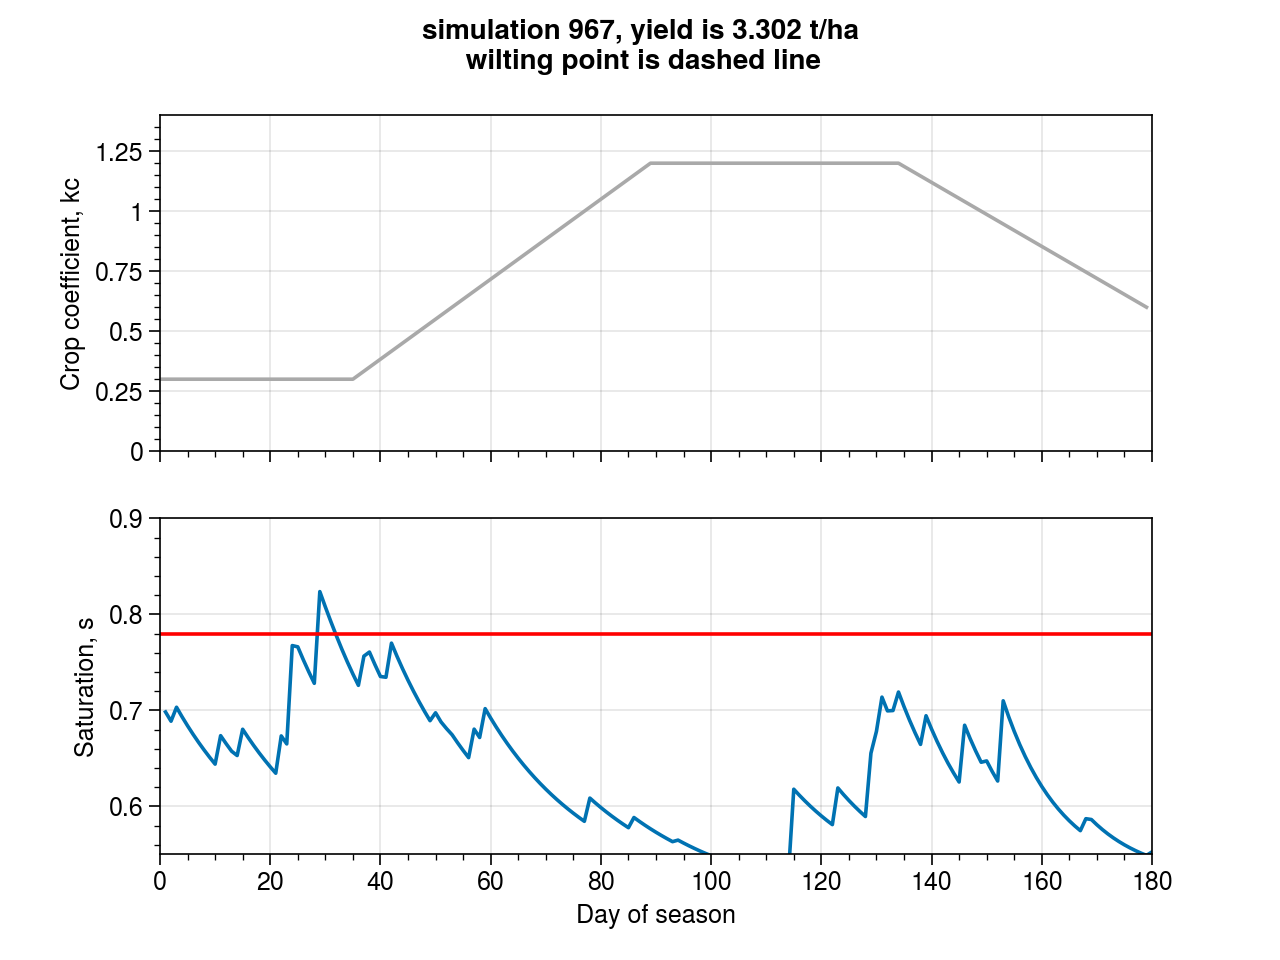

In [25]:
# print the time series

for i in bimod_sat.columns:
    fig, ax = plt.subplots(nrows=2, sharex = True) #constrained_layout=True
    bimod_sat[i].plot() # color='blue'
    #plt.title('wilting point is dashed line')
    plt.ylabel('Saturation, s')
    plt.xlabel('Day of season')
    plt.axhline(y=crop.s_star, color='r', linestyle='-')
    plt.axhline(y=crop.sw, color='r', linestyle='--')
    ax[1].set_ylim([0.55, 0.9])
    # get the yield
    y = df.loc[i,'Yield2']

    #secondary axis was too messy so adding secondary plot
    fig.suptitle('simulation %d' %i + ', yield is %.3f' %y + ' t/ha'
                 '\n wilting point is dashed line')
    ax[0].plot(kc, color='darkgray') # , marker='o'
    ax[0].set_ylim([0, 1.4]) #xlim=(0, 0.4), 
    ax[0].set_ylabel('Crop coefficient, kc') # r'p($\bar{s}$)'
    #ax.format(xlabel='Volumetric Water Content (mm)')
    
    #plt.savefig(str(i)+'_saturation.png')
    
    

## Possible re-exploration of n_star and r in dynamic stress <a id='nr'></a>


## Q7. Second group related to time series w/ values below wilting point? 

Or consider some other metric of excursions below wilting point or proximity to wilting point?

In [26]:
# Test space
# For any simulation, we can see whether there is a value of s less than or equal to sw
i = 4
if len(output[i][output[i].s <= crop.sw]) > 0:
    print('True')


# This tells us where in the time series s crosses sw
indx_memb = np.where(output[i].s <= crop.sw)
indx_memb # in this case never

# This is a dataframe of those occurrences
output[i][output[i].s <= crop.sw]

Empty DataFrame
Columns: [kc, LAI, stress, R, s, E, ET, T, L, dsdt, dos, doy]
Index: []

In [27]:
# Get all of the simulations that cross sw

s_min = []
n_sim = 1000
no_sims = np.arange(0,n_sim)

# figure out index number for simulation
for i in no_sims:
    # What this does is if the length of the dataframe is greater than 0 then it prints the 
    # simulation number which means that it has a crossing
    if len(output[i][start:end][output[i].s <= crop.sw]) > 0:
        s_min.append(i)
    #s_min.append(_s_min)
    
result = pd.DataFrame({'sim_no':s_min}).sim_no.tolist()

<ipython-input-27-94b748eeccd0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(output[i][start:end][output[i].s <= crop.sw]) > 0:


33
8
25


Text(0.5, 0, 'Rainfall (mm)')

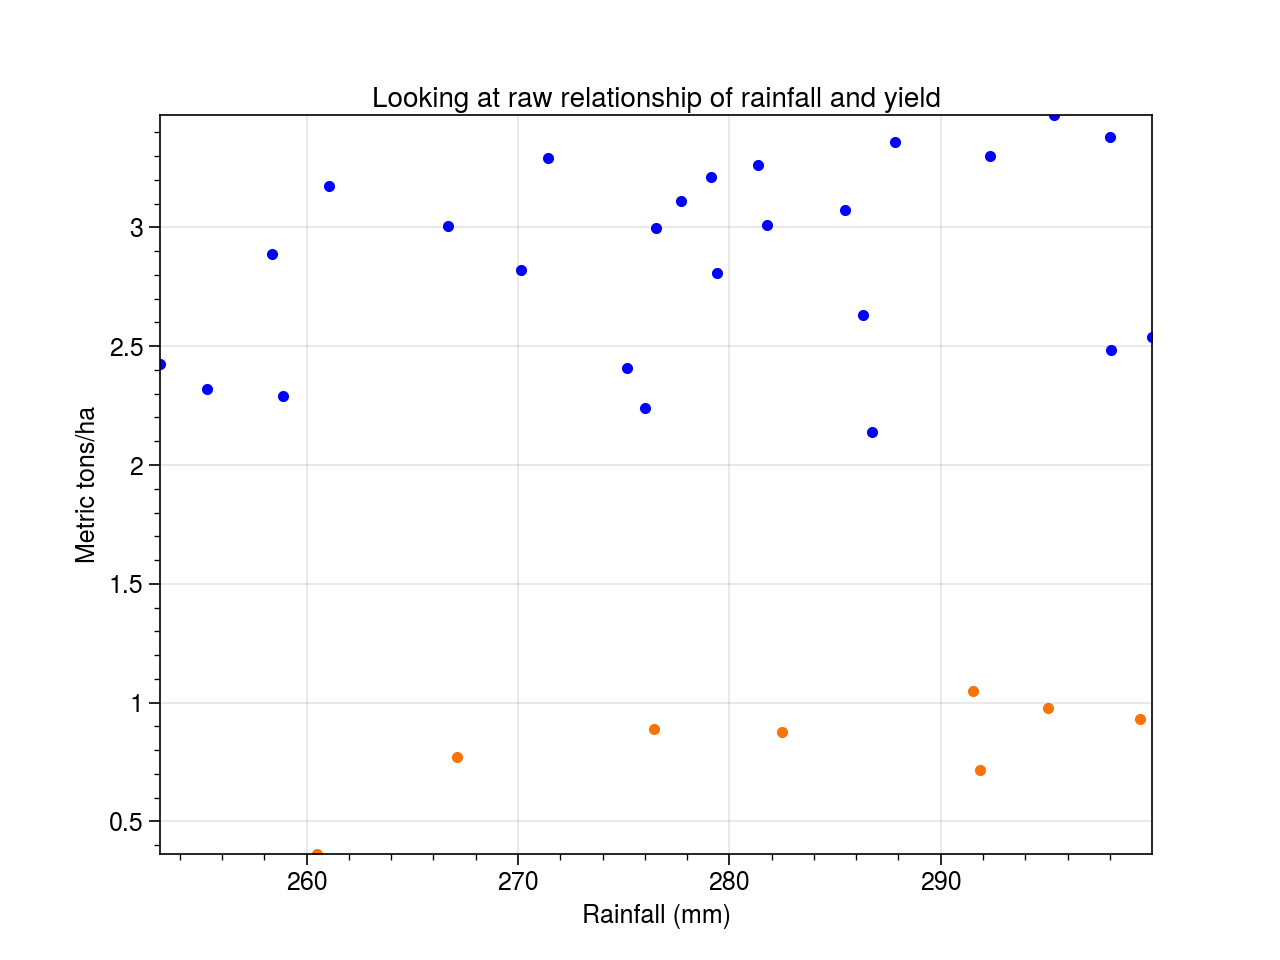

In [28]:
# Put all those indices together and change the color of the scatterplot

# How many simulations do cross sw
len(good)

# this is not the smartest way of doing this, but I need two dataframes one with the sims that cross star and the other one that doesnt
#result['flag'] = result.loc[result.index.isin(good)]
#result
df1 = df[df.index.isin(good)]
df2 = df[~df.index.isin(good)]

print(len(df))
print(len(df1))
print(len(df2))

# scatter plot of raw data
max(df.Yield)

#df1['Yield_norm'] = df.Yield/max(df.Yield)
#df1['Yield_norm'] = df1.Yield/max(df1.Yield)

plt.scatter(df1.RF, df1.Yield/1000, color='orange')
plt.scatter(df2.RF, df2.Yield/1000, color='blue')
#plt.ylim(-.10,1.10)
#plt.xlim(100,900)
plt.title('Looking at raw relationship of rainfall and yield')
plt.ylabel('Metric tons/ha')
plt.xlabel('Rainfall (mm)')

Oh, wow. So very clearly these are just related to the instances that cross wilting point. Makes sense. 
This explains why you can have really low yields for a 450 mm rainfall event say. It all falls along one trajectory.

Questions for Kelly:

1. Are these acceptable products of model assumptions that we can talk about in the real world?
2. Question to myself: Do I have anectodotal evidence about some really bad seasons vs. fine ones. Either in my notes or through the household survey. 

## So we know that n-star affects this second trajectory. Is there something that we're changing in `r` that is making this better or worse?

## Now try a for-loop where we have outputs for say five values of r...

In [29]:
# We can change the values of r using this function
def _calc_dstress(s, stress, K_PAR = 0.55, R_PAR=0.2, Y_MAX=4260): # got rid of self
        '''Calculates dyamic water stress (theta) which is a measure of total water stress during the growing season
        as proposed in Porporato et al. (2001). Considers the duration and frequency of water defict periods below a 
        critical value. The function also calculates yield based on dynamic water stress and returns three items in a
        list: average static water stress, dynamic water stress, and yield in kg per ha. 
        
        Usage: calc_dstress(s, stress):

            s = relative saturation [0-1]
            stress = static stress [0-1]

        Default values:
            mstr_memb = average static stress [0-1]
            mcrs_memb = average duration of water stress [days]
            ncrs_memb = average frequency of water stress [dim]
            self.lgp = length of the growing season [days]
            K_PAR = fraction of growing season before crop fails [dim]
            R_PAR = effect of number of excursions below stress point [dim]
            INVL_SIMU = number of daily timesteps used in calculating the soil moisture time series [dim]

        Returns:
            mstr_memb = np.mean(((self.s_star - s)/(self.s_star - self.sw))**q) # average static water stress
            dstr_memb = (mstr_memb * mcrs_memb) / (K_PAR * self.lgp))**(ncrs_memb**-R_PAR) # dynamic water stress
            yield_kg_ha = Y_MAX * (1 - dstr_memb) # yield in kg per ha
        
        '''
        # REMOVED SELF FROM THIS FUNCTION
        
        # Step 0. Define variables
        K_PAR = K_PAR
        R_PAR = R_PAR 
        INVL_SIMU = 1
        # added this
        lgp = 180
        # Step 1. Calculate average static stress
        if len(stress) > 0:
            # Subset the growing period and get avg soil moisture
            start = 60 
            end = start + lgp
            stress_subset = stress[start:end]
            mstr_memb = np.mean(stress_subset)
        else:
            mstr_memb = 0.

        # Step 2. Calculate threshold crossing parameters
        # Select indices of s time series where s is below wilting point
        indx_memb = np.where(s >= crop.s_star) 
        # Append to an array using np.append where last value is lgp+1 and INVL_SIMU is how many simulations are being run
        # Then have zero be the first item and 
        # with np.diff give the difference to find the soil moisture difference between s_star and the excursion
        ccrs_memb = np.diff(np.append(0, np.append(indx_memb, INVL_SIMU * lgp + 1))) - 1 # play around with this to figure it out 
        # The duration of water stress events where there is stress because value is greater than 0
        ccrs_memb = ccrs_memb[ccrs_memb > 0]
        # Variable with number of excursions below wilting point (frequency)
        ncrs_memb = len(ccrs_memb)  # dim 
        if ncrs_memb > 0:
            # if there are more than 0 excursions then calculate mean of duration of water stress and divide by INVL_SIMU
            mcrs_memb = np.mean(ccrs_memb) / INVL_SIMU # days
        else:
            mcrs_memb = 0.
            
        # Step 3. Calculate dynamic stress
        dstr_memb = ((mstr_memb * mcrs_memb) / (K_PAR * lgp))**(ncrs_memb**-R_PAR)
        if dstr_memb > 1.:
            dstr_memb = 1.

        # Step 4. Calculate yield
        yield_kg_ha = Y_MAX * (1 - dstr_memb)

        return mstr_memb, dstr_memb, yield_kg_ha

In [30]:
# Then we call on calc_dstress with this function

def dyn_stress(n_sim = 1000, station = 'OL JOGI FARM', texture = 'clay loam', lgp=180, pd_sim=60): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]
    # added this
    lgp = 180
    # Part 5. Subset the growing period and get avg stress, total rf
    start = 60 
    end = start + lgp
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]

    # dont need this but helpful for debugging
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]
    sat = [df[start:end]['s'] for df in output]
    stress = [df[start:end]['stress'] for df in output]
    
    o = output
    
    # New thing: Try different values of r parameter
    result = []
    rs = [0.05, 0.2, 0.4, 0.6, 0.8, 1.1]

    for i in rs:
        # Part 6. Output the dynamic stress and yield values
        # prev crop.calc_dstress
        x = [_calc_dstress(s=df.s, stress=df.stress, R_PAR=i) for df in o] #for i in np.arange(n_sim)
        data_tuples = list(zip(x))
        df = pd.DataFrame(data_tuples, columns=['x']) # 
        result.append(df)
        df['R_PAR'] = i
        df['TotalRF'] = total_rf

    result = pd.concat(result)
    df = result
    # Need to seperate the tuples
    df[['AvgStress', 'DynamicStress','Yield']] = pd.DataFrame(df['x'].tolist(), index=df.index) 
    r_test = df[['R_PAR','AvgStress','DynamicStress','Yield','TotalRF']]
    
    # Part 7. TODO: Define kc, a little janky and needs to be automated
    start = 60
    end = 60 + 180
    kc = o[1][start:end]['kc'].tolist()
    print('done')
    return  total_rf, r_test, rs #output, avg_stress, total_stress, total_rf, mstr_memb, dstr_memb, yield_kg_ha
    # x, total_rf, sat, stress, o, crop, output, kc, start, end, 
    
# TODO: There's got to be a better way than to return all of these variables.
# But also maybe this is temporary for testing
total_rf, r_test, rs = dyn_stress()

# data, rf, sat, stress, o, crop, output, kc, start, end, result

done


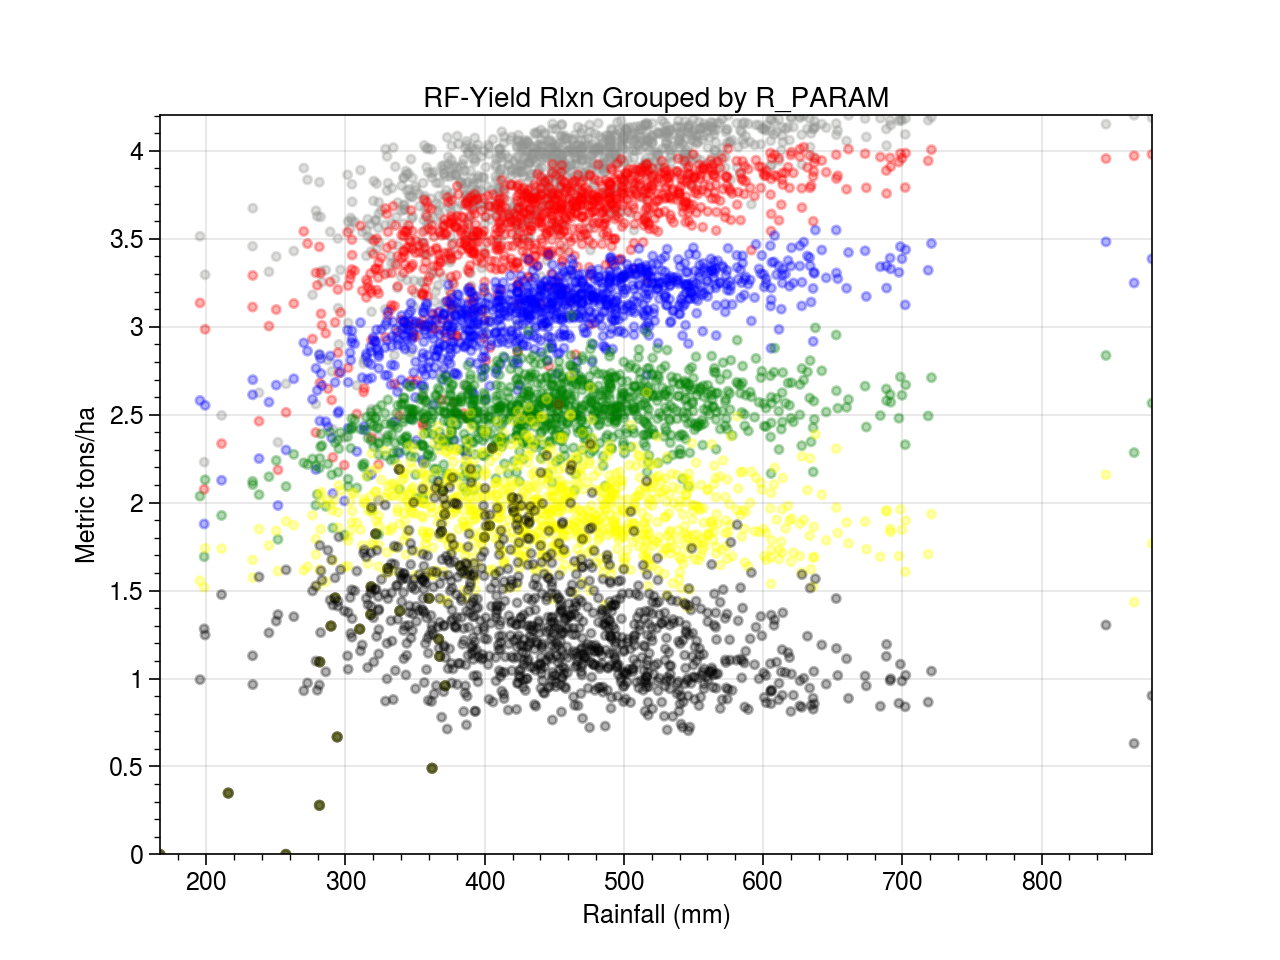

In [31]:
# got total rainfall onto that dataframe
# This might require some testing..?
r_test
len(total_rf)
r_test.AvgStress.nunique()
r_test.TotalRF.nunique()

# now want a figure of total rf vs yield where r parameters have different colors
r_test

fig, ax = plt.subplots()

colors = {0.05:'gray', 0.2:'red', 0.4:'blue', 0.6:'green', 0.8:'yellow', 1.1:'black'}

ax.scatter(r_test['TotalRF'], r_test['Yield']/1000, c=r_test['R_PAR'].apply(lambda x: colors[x]), alpha=0.3)
plt.title('RF-Yield Rlxn Grouped by R_PARAM')
plt.ylabel('Metric tons/ha')
plt.xlabel('Rainfall (mm)')
handles, labels = ax.get_legend_handles_labels()
#plt.legend(loc="upper left")

plt.show()

(200.0, 800.0)

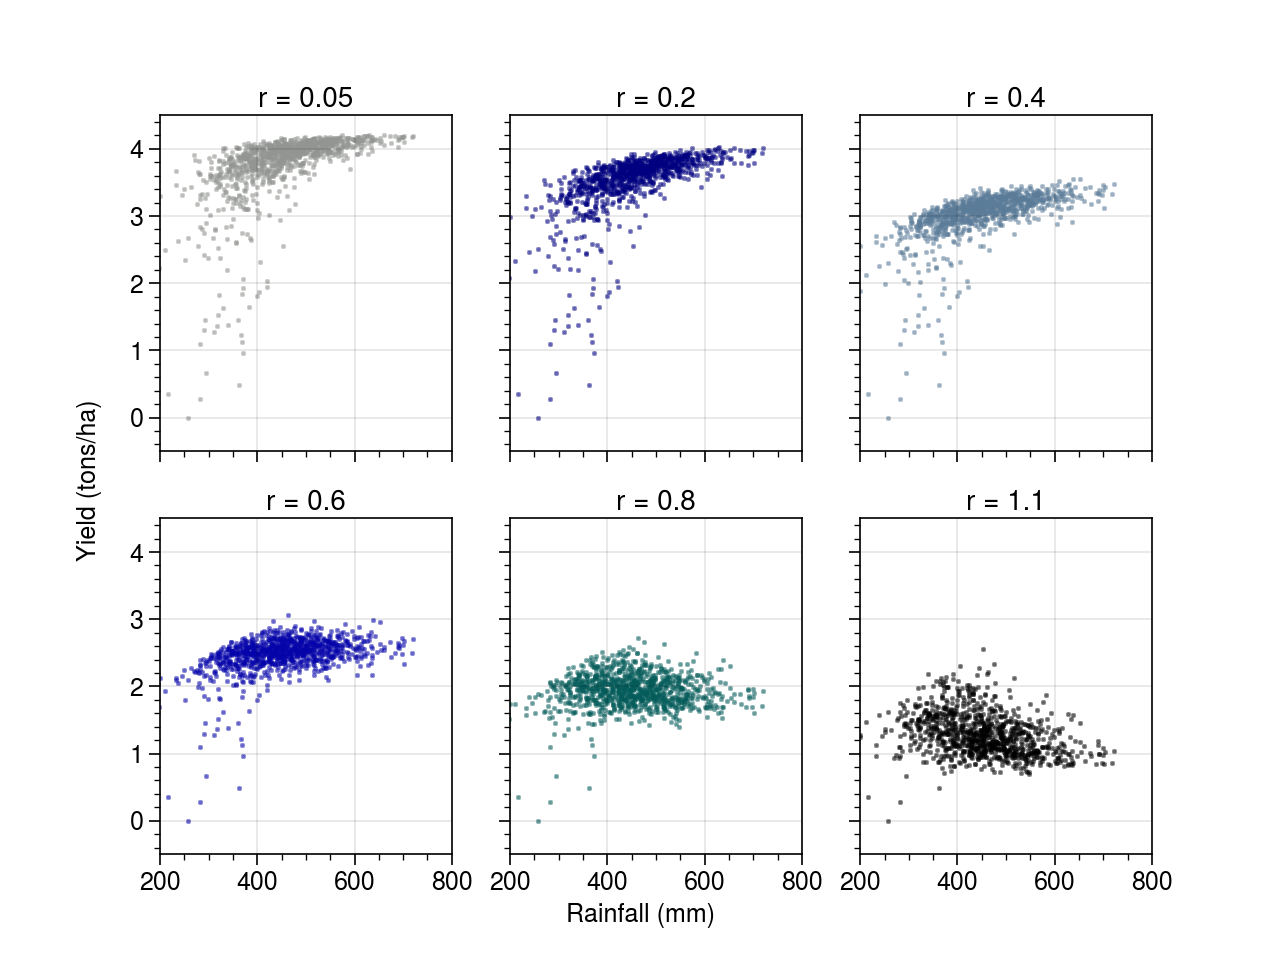

In [32]:
# Maybe I should make these different plots instead

fig, ax = plt.subplots(nrows = 2, ncols = 3, sharey=True, sharex=True)

#for i in rs:
#    select_color = r_test.loc[r_test['R_PAR'] == i]
#    select_color
   
select_color = r_test.loc[r_test['R_PAR'] == 0.05]
sc2 = r_test.loc[r_test['R_PAR'] == 0.2]
sc4 = r_test.loc[r_test['R_PAR'] == 0.4]
sc6 = r_test.loc[r_test['R_PAR'] == 0.6]
sc8 = r_test.loc[r_test['R_PAR'] == 0.8]
sc1 = r_test.loc[r_test['R_PAR'] == 1.1]

ax[0,0].scatter(select_color['TotalRF'], select_color['Yield']/1000,  s=0.4,marker='s', alpha=0.5,color='gray')
ax[0,1].scatter(sc2['TotalRF'], sc2['Yield']/1000, marker='s',  s=0.4,alpha=0.5, color="Navy")
ax[0,2].scatter(sc4['TotalRF'], sc4['Yield']/1000, marker='s',  s=0.4,alpha=0.5,color="Slate Blue")
ax[1,0].scatter(sc6['TotalRF'], sc6['Yield']/1000, marker='s',  s=0.4,alpha=0.5,color="Royal Blue")
ax[1,1].scatter(sc8['TotalRF'], sc8['Yield']/1000, marker='s', s=0.4, alpha=0.5,color="Dark Turquoise")
ax[1,2].scatter(sc1['TotalRF'], sc1['Yield']/1000, marker='s', s=0.4, alpha=0.5,color='black')

ax[0,0].set_title('r = 0.05')
ax[0,1].set_title('r = 0.2')
ax[0,2].set_title('r = 0.4')
ax[1,0].set_title('r = 0.6')
ax[1,1].set_title('r = 0.8')
ax[1,2].set_title('r = 1.1')

#for ax in ax.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

fig.text(0.5, 0.04, 'Rainfall (mm)', ha='center')
fig.text(0.06, 0.5, 'Yield (tons/ha)', va='center', rotation='vertical')
plt.ylim(-0.5,4.5)
plt.xlim(200,800)

Conclusions so far: Different values of r parameter still result in disjunctness until you get to r parameter above 1. 
There still seems to be a gap, which is interesting. And those lines. The lines are perhaps a little less evidence for r parameter of 0.6, so perhaps go with that. 0.6 also makes sense if the max yields of smallholders are closer to 2 t/ha.

For next thing to try see comment below.

- This is going to be really hammer headed but what are the values of n_star for the blue points versus the yellow points?

- Need to import dynamic stress function to test this out 

### What about k parameter's effect?

In [33]:
# New function to test values of k 

# Then we call on calc_dstress with this function

def dyn_stress(n_sim = 1000, station = 'OL JOGI FARM', texture = 'clay loam', lgp=180, pd_sim=60): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]
    # added this
    lgp = 180
    # Part 5. Subset the growing period and get avg stress, total rf
    start = 60 
    end = start + lgp
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]

    # dont need this but helpful for debugging
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]
    sat = [df[start:end]['s'] for df in output]
    stress = [df[start:end]['stress'] for df in output]
    
    o = output
    
    # New thing: Try different values of r parameter
    result = []
    ks = [0.05, 0.2, 0.4, 0.5, 0.6, 0.8]

    for i in ks:
        # Part 6. Output the dynamic stress and yield values
        # prev crop.calc_dstress
        x = [_calc_dstress(s=df.s, stress=df.stress, K_PAR=i, R_PAR=0.2) for df in o] #for i in np.arange(n_sim)
        data_tuples = list(zip(x))
        df = pd.DataFrame(data_tuples, columns=['x']) # 
        result.append(df)
        df['K_PAR'] = i
        df['TotalRF'] = total_rf

    result = pd.concat(result)
    df = result
    # Need to seperate the tuples
    df[['AvgStress', 'DynamicStress','Yield']] = pd.DataFrame(df['x'].tolist(), index=df.index) 
    k_test = df[['K_PAR','AvgStress','DynamicStress','Yield','TotalRF']]
    
    # Part 7. TODO: Define kc, a little janky and needs to be automated
    start = 60
    end = start + 180
    kc = o[1][start:end]['kc'].tolist()
    print('done')
    return  total_rf, k_test, rs #output, avg_stress, total_stress, total_rf, mstr_memb, dstr_memb, yield_kg_ha
    # x, total_rf, sat, stress, o, crop, output, kc, start, end, 
    
total_rf, k_test, rs = dyn_stress()



done


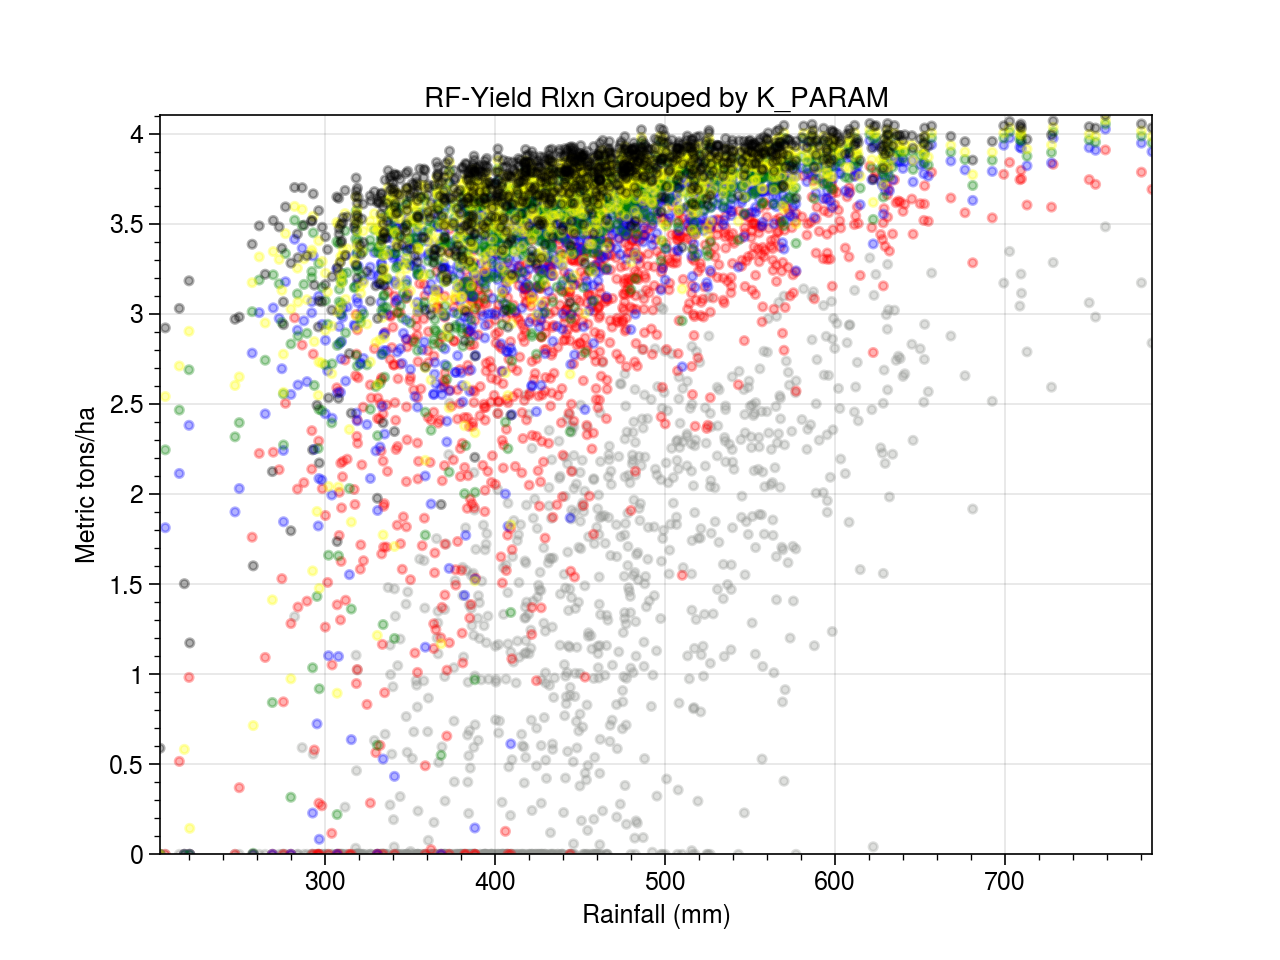

In [34]:
# Figure of k params
fig, ax = plt.subplots()

colors = {0.05:'gray', 0.2:'red', 0.4:'blue', 0.5:'green', 0.6:'yellow', 0.8:'black'}

ax.scatter(k_test['TotalRF'], k_test['Yield']/1000, c=k_test['K_PAR'].apply(lambda x: colors[x]), alpha=0.3)
plt.title('RF-Yield Rlxn Grouped by K_PARAM')
plt.ylabel('Metric tons/ha')
plt.xlabel('Rainfall (mm)')
handles, labels = ax.get_legend_handles_labels()
#plt.legend(loc="upper left")

plt.show()

(200.0, 800.0)

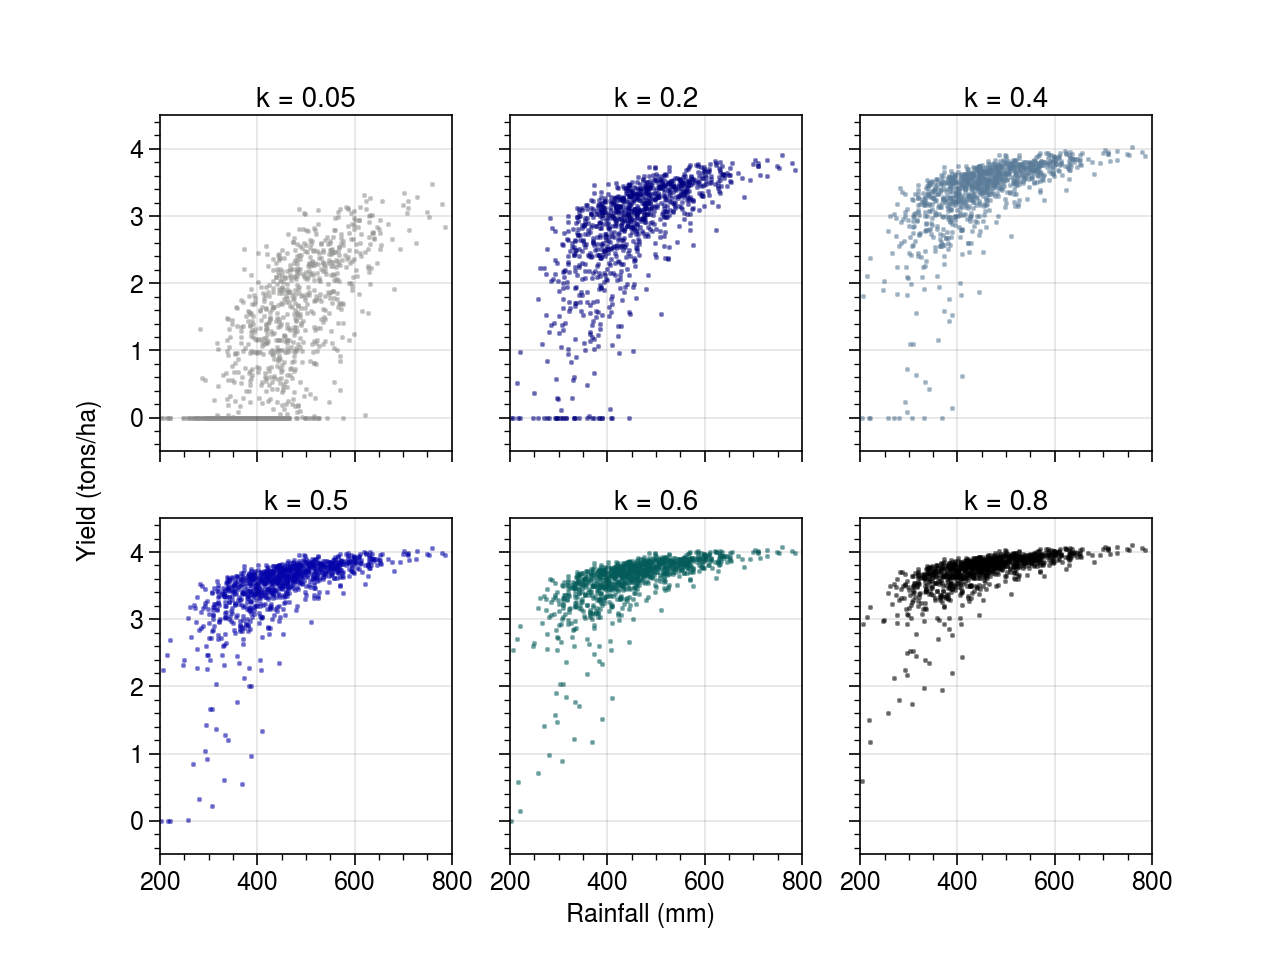

In [35]:
# Maybe I should make these different plots instead

fig, ax = plt.subplots(nrows = 2, ncols = 3, sharey=True, sharex=True)
   
select_color = k_test.loc[k_test['K_PAR'] == 0.05]
sc2 = k_test.loc[k_test['K_PAR'] == 0.2]
sc4 = k_test.loc[k_test['K_PAR'] == 0.4]
sc6 = k_test.loc[k_test['K_PAR'] == 0.5]
sc8 = k_test.loc[k_test['K_PAR'] == 0.6]
sc1 = k_test.loc[k_test['K_PAR'] == 0.8]

ax[0,0].scatter(select_color['TotalRF'], select_color['Yield']/1000, s=0.4,marker='s', alpha=0.5,color='gray')
ax[0,1].scatter(sc2['TotalRF'], sc2['Yield']/1000, marker='s',  s=0.4,alpha=0.5, color="Navy")
ax[0,2].scatter(sc4['TotalRF'], sc4['Yield']/1000, marker='s',  s=0.4,alpha=0.5,color="Slate Blue")
ax[1,0].scatter(sc6['TotalRF'], sc6['Yield']/1000, marker='s',  s=0.4,alpha=0.5,color="Royal Blue")
ax[1,1].scatter(sc8['TotalRF'], sc8['Yield']/1000, marker='s', s=0.4, alpha=0.5,color="Dark Turquoise")
ax[1,2].scatter(sc1['TotalRF'], sc1['Yield']/1000, marker='s', s=0.4, alpha=0.5,color='black')

ax[0,0].set_title('k = 0.05')
ax[0,1].set_title('k = 0.2')
ax[0,2].set_title('k = 0.4')
ax[1,0].set_title('k = 0.5')
ax[1,1].set_title('k = 0.6')
ax[1,2].set_title('k = 0.8')

#for ax in ax.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

fig.text(0.5, 0.04, 'Rainfall (mm)', ha='center')
fig.text(0.06, 0.5, 'Yield (tons/ha)', va='center', rotation='vertical')
# gah I quit on making this complicated
plt.ylim(-0.5,4.5)
plt.xlim(200,800)

## A-ha!

- K param might be the culprit here. When we use a value of k=0.2 we don't get that second trajectory (as much).
- Is this something worth discussing in the paper?

- Thoughts: Change k or r doesn't seem to affect whether the bifurcation is there. So we can continue with the story that it has to do with dips below wilting point.
- From an agronomic or smallholder perspective, what causes these dips below wilting point?

## Justification for K PARAM.

Yes, we'll go with 0.2. But there is perhaps some literature backing up a value of 0.5. 


How the WRSI considers crop failure, from [Senay (2004)](https://iridl.ldeo.columbia.edu/documentation/usgs/adds/wrsi/WRSI_readme.pdf): `At the end of the crop growth cycle, or up to a certain dekad in the cycle, the respective sums of crop actual evapotranspiration (AETc) and crop potential evapotranspiration (PETc) are used to calculate WRSI (equation 1). A case of “no deficit” will result in a WRSI value of 100, which corresponds to the absence of yield reduction related to water deficit. A seasonal WRSI value less than 50 is regarded as a crop failure condition (Smith, 1992).`

Original reference:
Smith, M., 1992. Expert consultation on revision of FAO methodologies for crop water
requirements. FAO, Rome, Publication 73. [Read in UCSB library here](https://babel.hathitrust.org/cgi/pt?id=uc1.31210024984104&view=1up&seq=5).

Also go back to Thornton figure. 

## I'll come back to this in a little bit

This tells me it's maybe not just crossing s star but some threshold above or nearby s_star? 

## Old figures

Text(0.5, 1.0, 'Histograms of Rainfall (blue) and Yield (orange)')

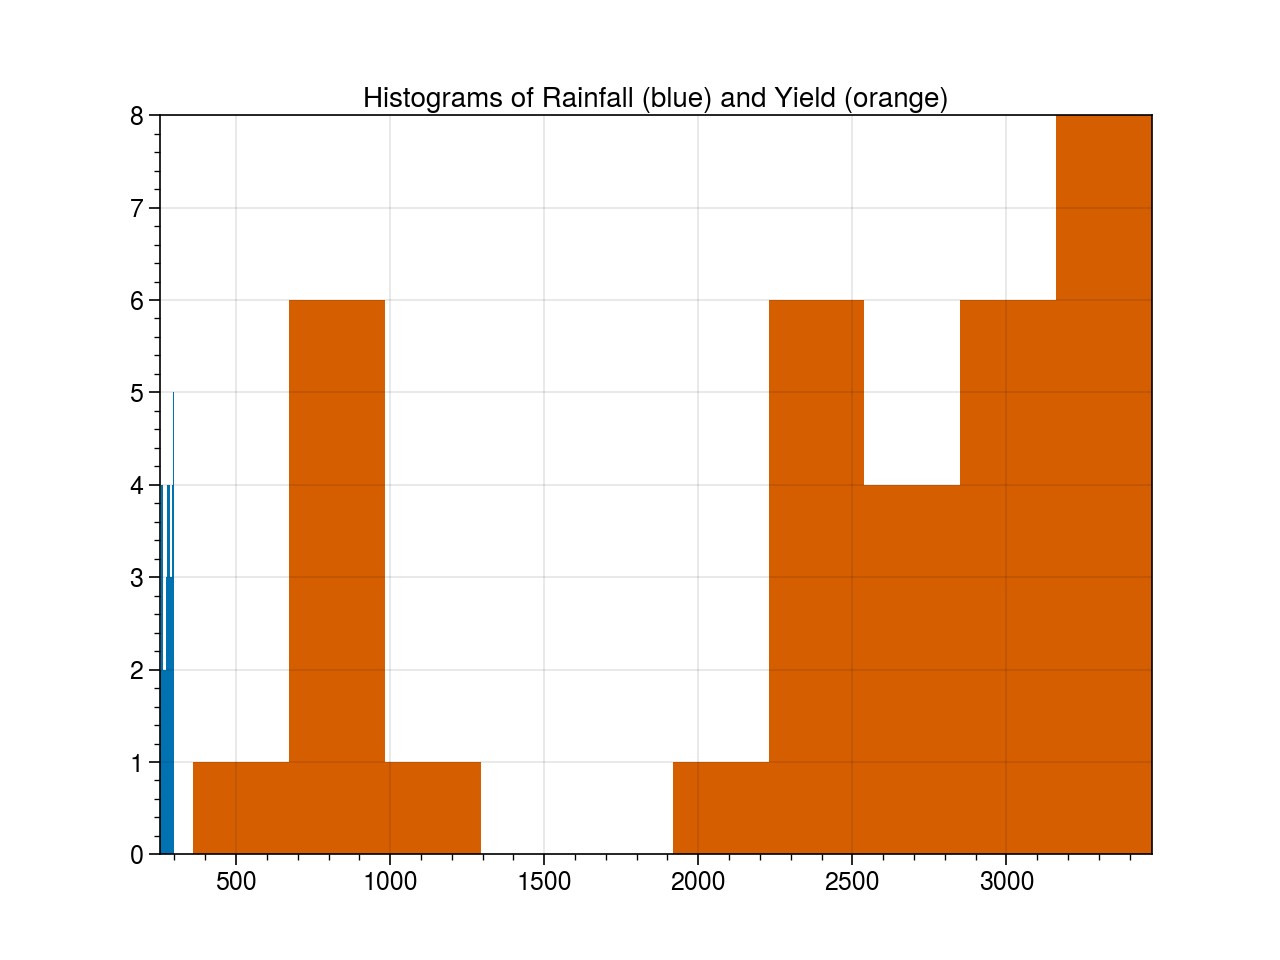

In [36]:
# distributions of yield and rainfall
df.RF.hist()
df.Yield.hist()
plt.title('Histograms of Rainfall (blue) and Yield (orange)')


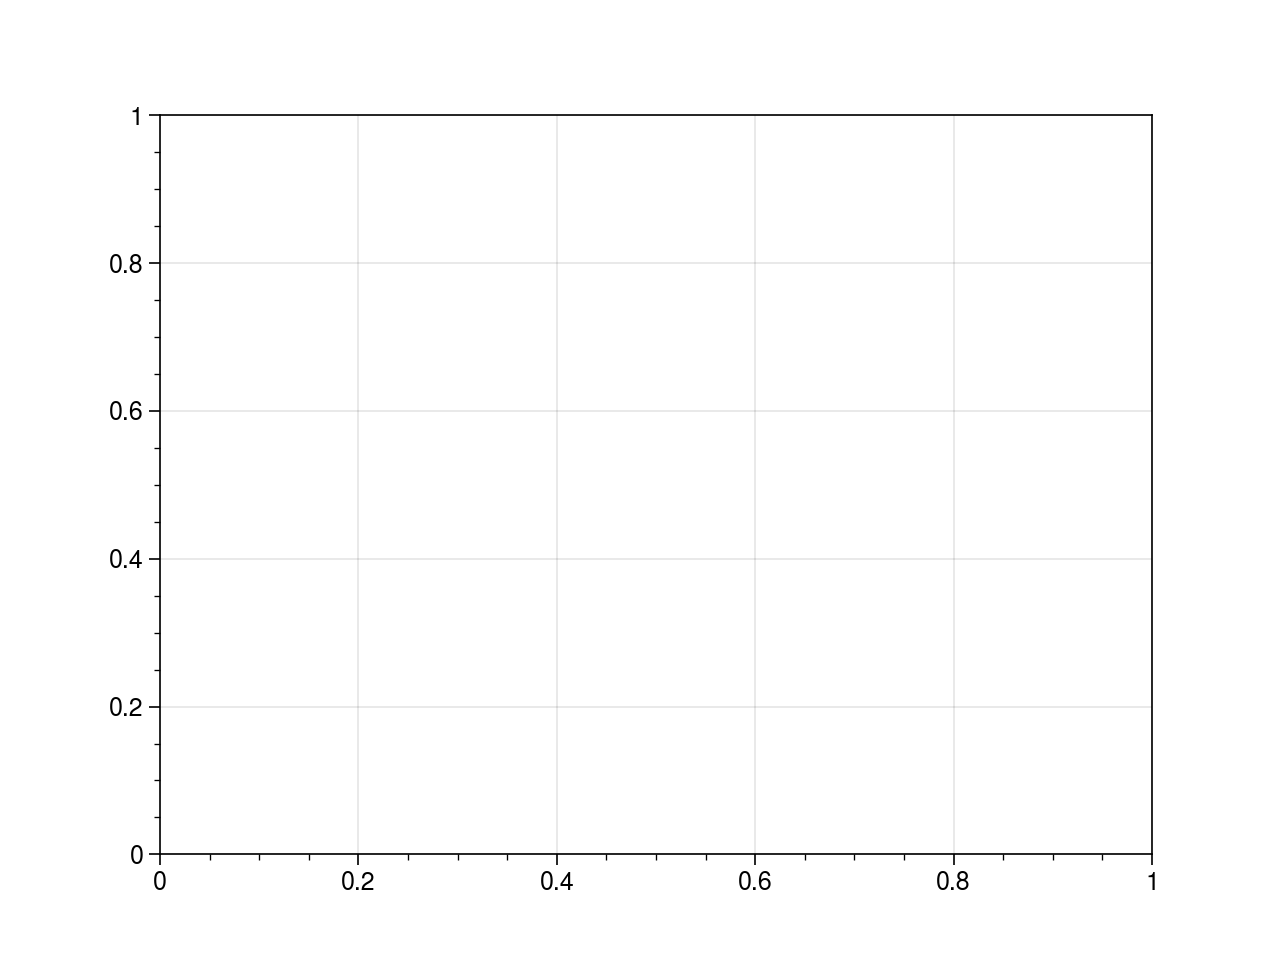

In [37]:
# To add annotations to the yellows, use this. Warning it gets a little messy
enumerate(df1.index)
df1.index

xdat = df1.RF
ydat = df1.Yield/1000

for i in df1.index:
    plt.annotate(i, (xdat[i]+0.45, ydat[i]+0.001), fontsize=7)


In [38]:
df

AvgStress2  DynamicStress        Yield          RF  Yield_norm    Yield2
482    0.457630       0.915259   360.996007  260.505155    0.089746  0.360996
659    0.415990       0.831980   715.764048  291.840148    0.177944  0.715764
734    0.409300       0.818600   772.762097  267.138428    0.192114  0.772762
122    0.397312       0.794625   874.897895  282.496116    0.217506  0.874898
812    0.395908       0.791816   886.862860  276.452647    0.220481  0.886863
274    0.390814       0.781629   930.262481  299.448891    0.231270  0.930262
89     0.385268       0.770535   977.520225  295.062827    0.243019  0.977520
761    0.377130       0.754260  1046.852409  291.520902    0.260255  1.046852
633    0.427413       0.497830  2139.245389  286.758200    0.531833  2.139245
18     0.435997       0.473698  2242.046763  276.010072    0.557390  2.242047
713    0.419150       0.462274  2290.714303  258.886734    0.569489  2.290714
769    0.407780       0.455774  2318.401352  255.285477    0.576372  2.318401
218    0.387869       0.434216  2410.240843  275.158825    0.599204  2.410241
371    0.388537       0.430610  2425.601686  253.063497    0.603023  2.425602
447    0.372479       0.417127  2483.040208  298.062744    0.617303  2.483040
361    0.361845       0.403641  2540.489895  299.997046    0.631585  2.540490
840    0.399708       0.382457  2630.734801  286.328569    0.654021  2.630735
997    0.368980       0.341088  2806.966956  279.430910    0.697833  2.806967
940    0.411546       0.338217  2819.197286  270.153165    0.700874  2.819197
649    0.401149       0.321920  2888.622068  258.356645    0.718133  2.888622
499    0.364697       0.296758  2995.809143  276.536385    0.744781  2.995809
695    0.408851       0.294795  3004.173383  266.675850    0.746860  3.004173
925    0.413272       0.293743  3008.653234  281.759853    0.747974  3.008653
410    0.391599       0.278279  3074.531201  285.493730    0.764352  3.074531
545    0.434730       0.270009  3109.761375  277.698547    0.773110  3.109761
219    0.405800       0.254670  3175.107855  261.081089    0.789356  3.175108
33     0.340429       0.245785  3212.957326  279.144079    0.798765  3.212957
974    0.352381       0.233859  3263.758969  281.372637    0.811395  3.263759
237    0.390229       0.227198  3292.137703  271.398642    0.818450  3.292138
967    0.391358       0.224774  3302.464118  292.351461    0.821018  3.302464
257    0.373052       0.211750  3357.943505  287.849626    0.834810  3.357944
153    0.364847       0.206625  3379.775826  298.017297    0.840238  3.379776
256    0.366450       0.184888  3472.377085  295.365750    0.863259  3.472377